# Imports

Import Packages

In [1]:
#for reading files
import glob
import tifffile

#math computation and data organization
import numpy as np
import math
import scipy
from scipy.ndimage import binary_erosion, binary_fill_holes
from scipy import optimize
from scipy.optimize import curve_fit
import pandas as pd

# For loading bars
from tqdm.notebook import tqdm as tqdm

#For image plotting
import skimage.io

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian, threshold_mean
from skimage.measure import regionprops
import cv2

#for fitting
from lmfit import minimize, Parameters, fit_report

#for image registration
from skimage.registration import phase_cross_correlation
import os

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import gridspec

import seaborn as sns

#Movie
import celluloid as cell
import matplotlib.animation as animation

#for saving data
import csv
import h5py

#custom analysis packages
import aster_packages as ap

# Thing to enable lovely parallelization
import concurrent.futures

# Enable repeat from itertools for parallel
import itertools

Stylistic parameters for plots

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:

# Figure Formatting
import matplotlib.pyplot as plt
import matplotlib as mpl

figwidth = 4
plt.rcParams["figure.figsize"] = [figwidth, figwidth * 1105 / 1920
                                  ]  # figure size in inches
plt.rcParams["lines.linewidth"] = 2  # line width in points
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"

plt.rcParams["font.style"] = "normal"
plt.rcParams["font.weight"] = "heavy" #chick this later maybe the source of weirdness in labels (ANA READ THIS)
plt.rcParams["font.size"] = 13.0
plt.rcParams["axes.labelweight"] = "bold"  # weight of the x and y labels
plt.rcParams["axes.spines.right"] = True
plt.rcParams[
    "axes.formatter.useoffset"] = True  # If True, the tick label formatter
plt.rcParams["xtick.major.size"] = 10  # major tick size in points
plt.rcParams["xtick.minor.size"] = 4  # minor tick size in points
plt.rcParams["xtick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.major.size"] = 10  # major tick size in points
plt.rcParams["ytick.minor.size"] = 4  # minor tick size in points
plt.rcParams["ytick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["legend.fontsize"] = 10
plt.rcParams[
    "legend.labelspacing"] = 0.1  # the vertical space between the legend entries in fraction of fontsize
plt.rcParams["legend.shadow"] = False
plt.rcParams[
    "legend.frameon"] = True  # whether or not to draw a frame around legend
plt.rcParams[
    'axes.unicode_minus'] = False  # fix glyph error by using normal hyphens
plt.rcParams.update({"text.usetex": True, 
             "font.family": "Times"})
mpl.rc("figure", dpi=200)

color_background = '#E5E0D5'

# Data Imports

Function to import aster images into a list of length 3 each containing an image array for each channel with shape (lenth of frames, n by m image shape)

In [3]:
def parse_ome(file, channel_list=['405', '480', 'Cherry']):
    """
    Extracts image arrays from an ome.tif file.
    
    Parameters:
    file (string): Data file path.
    channel_list (list of strings): Names of fluorescent channels taken in this dataset
    
    Returns:
    (list): List of images (as 3D numpy.ndarrays) for each fluorescent channel with shape (# images, m, n).
    """
    
    images = []
    # Open and read the OME-TIFF file
    with tifffile.TiffFile(file) as tif:

        for i, page in enumerate(tif.pages):
            image_data = page.asarray()
            images.append(image_data)

        # Access the OME metadata if needed
        ome_metadata = tif.ome_metadata

    ch1 = images[0::3]
    ch2 = images[1::3]
    ch3 = images[2::3]
    
    return [np.array(ch1), np.array(ch2), np.array(ch3)]

Set a data path and convert to arrays

In [4]:
#gabes version of file name
gname ='../../data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif'
arrs = parse_ome(gname)

Function to parse experimental info from the data path name

In [5]:
def grab_expparams_ome(gname):
    """
    Parses a file name to fine experimental parameters.
    
    Parameters:
    gname (string): data file path.
    
    Returns:
    exp_file (string): Saves the ome.tif name of the dataset.
    interval (integer): The time interval between images in seconds.
    motor_conc (float): The total concentration of motor proteins in µM.
    motor_type (string): The motor species, i.e. NCD or K401.
    ATP_conc (float): The inital concentration of ATP in µM.
    tubulin_conc (float): The concentration of tubulin (in the form of MT) in µM
    probe_conc (float): The concentration of the ATP probe in µM.
    probe_type (string): the species of ATP probe, i.e. A81D or ATeam
    """
    exp_file = gname.split('/')[-1]
    interval = int(exp_file.split('sInter')[0])
    motor_conc = float(exp_file.split('_')[1].split('uM')[0])
    motor_type = exp_file.split('_')[2]
    ATP_conc = float(exp_file.split('_')[4].split('uM')[0])
    tubulin_conc = float(exp_file.split('_')[5].split('uM')[0])
    probe_conc = float(exp_file.split('_')[7].split('uM')[0])
    probe_type = exp_file.split('_')[8]
    
    exp_params = {'exp_file':exp_file,
                 'interval':interval,
                 'motor_conc':motor_conc,
                 'motor_type':motor_type,
                 'ATP_conc':ATP_conc,
                 'tubulin_conc':tubulin_conc,
                 'probe_conc':probe_conc,
                 'probe_type':probe_type}
    return exp_params

Find experimental parameters and save as a dictionary

In [6]:
exp_params = grab_expparams_ome(gname)

In [7]:
exp_params

{'exp_file': '20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif',
 'interval': 20,
 'motor_conc': 0.6,
 'motor_type': 'NCD',
 'ATP_conc': 500.0,
 'tubulin_conc': 1.3,
 'probe_conc': 2.8,
 'probe_type': 'A81D'}

Function to import dark images

In [8]:
def grab_dark_avg(file_path_dark):
    """
    Imports a dark image.
 
    Parameters:
    file_path_dark (string): Data path for a dark image.
    
    Returns:
    dark_avg (numpy.ndarray): Dark image as a 2D array.
    """
    dark_files = np.sort(glob.glob(file_path_dark))
    dark_ims = ap.file_to_image(dark_files)
    dark_avg = np.average(dark_ims, axis=0)
    return dark_avg

Import dark image

In [9]:
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
dark_avg = grab_dark_avg(file_path_dark)

Function to read calibration parameters

In [10]:
def grab_calparams(file_path_cal):
    """
    Imports ATP calibration parameters as a DataFrame.
    
    Parameters:
    file_path_cal (string): Data path to a text file with fitting parameters for ATP calibration
    
    Returns:
    cal_params (pd.DataFrame): DataFrame with ATP calibration fitting parameters.
    """
        
    #read the DataFrame
    cal_params = pd.read_csv(cal_file_path+cal_file_folder+cal_file_name)

    #add hill=1 if no hill specified
    if len(cal_params)==3:
        cal_params.loc[-1] = [3, 'nhill', 1, 0]
    
    #reindex
    cal_params = cal_params.set_index('Param')
    
    #drop the unnamed colum (from index of text file)
    cal_params = cal_params.drop(columns='Unnamed: 0')
    
    return cal_params

Read Calibration parameters

In [11]:
cal_file_path = '../../analyzed_data/atp_cal/'
cal_file_folder = '2023-12-16_A81D_Cal/'
cal_file_name = 'df_fit_example'
cal_params = grab_calparams(cal_file_path+cal_file_folder+cal_file_name)

## Normalize Images
This corrects for uneven illumination. The light gradient that comes from instrumentation "should" be the same for each frame. Here, take the first frame of the image sequence and create a normalization matrix. This matrix is created by dividing each pixel in the image by the maximum pixel value, so that when you multiply the original image by the normalization matrix, the first frame will be a homogeneous image with the highest pixel value. All future frames can be multiplied by the matrix to remove the systematic light gradient

In [12]:
def backSubtract(arrs, dark_avg):
    """
    Subtracts camera dark noise from images
    
    Parameters:
    arrs (lsit): list of 3D numpy.ndarray's containing aster images where each array is from a different fluorescent channel.
    dark_avg (numpy.ndarray): 2D array image taken with the camera shutter closed of shape (m, n)
    
    Returns:
    (list): list of 3D numpy.ndarray's with dark camera noise subtracted.
    """
    return [arr-dark_avg for arr in arrs] # save processed images

Subtract background

In [13]:
arrs_sub = backSubtract(arrs, dark_avg)

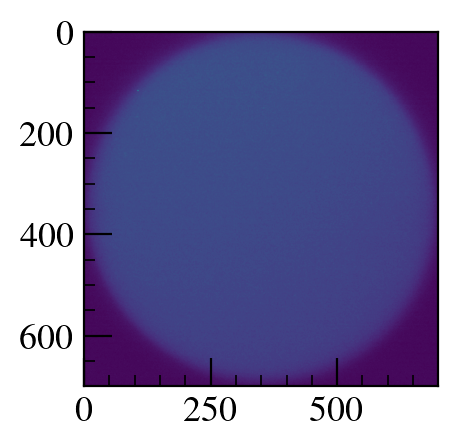

In [14]:
plt.imshow(arrs_sub[0][0][250:950, 620:1320])

Find pixels illuminated in the ATP channels for all timepoints

In [15]:
def intersect(arrs):
    """
    The camera has an occasional jitter, illuminating slightly different fields of view. This function finds pixels illluminated in all frames
    
    Parameters:
    arrs (lsit): list of 3D numpy.ndarray's containing aster images where each array is from a different fluorescent channel.
    
    Returns:
    (tuple): tuple containing the pixel coordinates for pixels illuminated in all images. The tuple has two 1D arrays, one for each image dimension.
    """
    _, numRows, numCols=arrs[0].shape
    
    #iterate through frame numbers
    severeIntersection=np.ones_like(arrs[0][0]);
    
    for fr in range(arrs[0].shape[0]): # for every timepoint
        #iterate through channels:
        ## Process the ATP channels first!
        im_bins=[]
        for arr in arrs[:2]: #exclude the motor channel!
            im_bin = (arr[fr,:,:] > threshold_otsu(arr[fr,:,:])).astype(np.uint8)
            im_bins.append(im_bin)
        intersectionBinImg=np.multiply(*im_bins) # This is defined for each frame/timepoint; it is the intersection between both channels' masks
        severeIntersection=np.multiply(severeIntersection, intersectionBinImg) # This accumulates the most severe intersection possible such that after iteration over all frames, all pixels not = 0 are visible/illuminated in every frame and every channel

    return np.where(severeIntersection.astype(int)) #returns where =1 (or True)

In [16]:
mask_coords=intersect(arrs_sub)
allmask_coords = np.s_[:, mask_coords[0], mask_coords[1]]

In [17]:
def fit_bivariate_quadratic_anyShape(vals, coord):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    binary_im (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Flatten the matrices for the least squares fitting
    I_flat = coord[0]
    J_flat = coord[1]
    Z_flat = vals

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly_anyShape(vals,coord):
    """ Given coordinates, this function returns the best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic_anyShape(vals, coord);
    I, J = coord[0], coord[1]
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted

In [18]:
def norm_unev(arrs_sub, mask_coords, allmask_coords):
    """
    Corrects uneven illumination by fitting an image to a bivariate polynomial, normalizing the polynomial, and dividing an array of images by this normalized matrix.
    
    Parameters:
    arrs_sub (list): Dark image subtracted list of image arrays.
    mask_coords (length 2 tuple): illumination mask coordinates (for one image)
    allmask_coords (slice): slice containing all the illumination coordinates with an extra dimension to account for all timepoints
    
    Returns:
    arr_ev (list): list of image arrays after the evening process.
    """
    #norm_mats = []
    arrs_ev = []
    
    for arr in arrs_sub:
        #compute the bivariate filter
        biv_filt = np.zeros_like(arr[0])
        biv_filt[mask_coords] = evaluateBivPoly_anyShape(arr[0, :, :][mask_coords], mask_coords)
        #norm_mats.append(norm_mat)
        
        #scale the normalization matrix such that the average value after multiplication is the same as the bs image
        scalar = np.mean(arr[0][mask_coords])/np.mean(arr[0][mask_coords]/biv_filt[mask_coords])
        norm_mat = scalar/biv_filt
        
        arrs_ev_temp = np.zeros_like(arr)
        arrs_ev_temp[allmask_coords]=arr[allmask_coords]*norm_mat[mask_coords]
        
        arrs_ev.append(arrs_ev_temp)
        
    return arrs_ev

Even the image arrays

In [20]:
arrs_norm=norm_unev(arrs_sub, mask_coords, allmask_coords)

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_91038/2823317895.py:24: RuntimeWarning: divide by zero encountered in true_divide
  norm_mat = scalar/biv_filt


# Ratio

compute the ratio of the ATP channels

In [21]:
ratios = arrs_norm[0][allmask_coords]/arrs_norm[1][allmask_coords]

Write a function to crop array values to a range

In [22]:
def replace_out_of_range_values(arr, min_value, max_value):
    """
    Crop the intensities of an array to be withing a defined range.
    
    Parameters:
    arr (numpy.ndarray): images array.
    min_value (float): minimum value below which all other values are set to the minimum
    max_value (float): maximum value above which all other values are set to the maximum
    
    Returns:
    arr_copy (numpy.ndarray): image array cropped to the set intensity range.
    """
    arr_copy = np.copy(arr)
    mask_min = arr < min_value
    mask_max = arr > max_value
    arr_copy[mask_min] = min_value
    arr_copy[mask_max] = max_value
    return arr_copy

write a function for the equation to convert to concentration values

In [23]:
def ATP_conc_to_ratio(array, Km, Rmax, Rmin, nhill):
    """Given a set of concentrations, returns ratio values based on provided Hill equation coefficients"""
    return (Rmax-Rmin)*((array/Km)**nhill/(1 + (array/Km))**nhill) + Rmin

def ATP_ratio_to_conc(array, Km, Rmax, Rmin, nhill):
    """Given a set of ratios, returns concentration values based on provided Hill equation coefficients"""
    return Km * ((Rmin - array) / (array - Rmax)) ** (1/nhill)

Write a function to convert arrays of ratios to concentrations

In [24]:
def infer_concs(ratios, exp_params, cal_params, allmask_coords, shape):
    """
    Convert ratios images to concentrations. (outputs an image array)
    
    Parameters:
    ratios (numpy.ndarray): ratio array of shape (# timepoints, #of ratio values to convert).
    exp_params (dictionary): dictonary of experimental parameters
    cal_params (dictionary): maximum value above which all other values are set to the maximum
    allmask_coords (slice): coordinates for multiple timepoints 
    shape (tuple): shape of image array
    
    Returns:
    ratios_conc_ims (numpy.ndarray): image array in concentration units.
    """
    #Find the ratio value for the inital ATP conc value based on calibration curve equation
    RinitATP = ATP_conc_to_ratio(exp_params['ATP_conc'], 
                                 cal_params.loc['Km']['Value'], 
                                 cal_params.loc['Rmax']['Value'],
                                 cal_params.loc['Rmin']['Value'], 
                                 cal_params.loc['nhill']['Value'])
    #Crop the ratios to within range
    ratios_inrange = replace_out_of_range_values(ratios, 
                                                 cal_params.loc['Rmin']['Value'], 
                                                 RinitATP)
    #convert ratios to concentrations
    ratios_conc = ATP_ratio_to_conc(ratios_inrange, cal_params.loc['Km']['Value'], 
                                     cal_params.loc['Rmax']['Value'],
                                     cal_params.loc['Rmin']['Value'], 
                                     cal_params.loc['nhill']['Value'])
    #put ratios array into an imag
    ratios_conc_ims = np.zeros(shape)
    ratios_conc_ims[allmask_coords] = ratios_conc
    
    return ratios_conc_ims

In [25]:
def infer_concs_listsave(ratios, exp_params, cal_params, allmask_coords, shape):
    """
    Convert ratios images to concentrations. outputs list of ATP values not as image as np.float32 type
    
    Parameters:
    ratios (numpy.ndarray): ratios 2D array of shape (# timepoints, #of ratio values to convert).
    exp_params (dictionary): dictonary of experimental parameters
    cal_params (dictionary): maximum value above which all other values are set to the maximum
    allmask_coords (slice): coordinates for multiple timepoints 
    shape (tuple): shape of image array
    
    Returns:
    ratios_conc (np.ndarray): 2D array of shape (# timepoints, #of ratio values to convert).
    """
    #Find the ratio value for the inital ATP conc value based on calibration curve equation
    RinitATP = ATP_conc_to_ratio(exp_params['ATP_conc'], 
                                 cal_params.loc['Km']['Value'], 
                                 cal_params.loc['Rmax']['Value'],
                                 cal_params.loc['Rmin']['Value'], 
                                 cal_params.loc['nhill']['Value'])
    #Crop the ratios to within range
    ratios_inrange = replace_out_of_range_values(ratios, 
                                                 cal_params.loc['Rmin']['Value'], 
                                                 RinitATP)
    #convert ratios to concentrations
    ratios_conc = ATP_ratio_to_conc(ratios_inrange, cal_params.loc['Km']['Value'], 
                                     cal_params.loc['Rmax']['Value'],
                                     cal_params.loc['Rmin']['Value'], 
                                     cal_params.loc['nhill']['Value']).astype(np.float32)

    
    return ratios_conc

Convert ratio values to concentrations

In [26]:
ratios_conc = infer_concs_listsave(ratios, 
                              exp_params, 
                              cal_params, 
                              allmask_coords, 
                              arrs_sub[0].shape)

# Motor Calibration
here we will have a temporary function turning intensity values to uM. for now just return the same thing

In [27]:
def mot_inten_to_conc(arr, allmask_coords):
    arr1 = arr[allmask_coords].astype(np.float32)
    return arr1

In [28]:
def linear_mot_cal(arr, allmask_coords, exp_params):
    init_mot = exp_params['motor_conc']
    protein_per_fluo = init_mot/np.average(arr[allmask_coords][0]) 
    arr1 = (arr[allmask_coords]*protein_per_fluo).astype(np.float32)
    return arr1

# function to run the whole adventure and save h5py

In [29]:
def save_ATPconc_images(iterable, return_flag=False):
    
    gname, file_path_dark, cal_file_path, save_name = iterable
    
    arrs = parse_ome(gname)
    print(arrs[0].shape)
    exp_params = grab_expparams_ome(gname)
    print(exp_params)
    dark_avg = grab_dark_avg(file_path_dark)
    print(dark_avg.shape)
    cal_params = grab_calparams(cal_file_path)
    print(cal_params)
    arrs_sub = backSubtract(arrs, dark_avg)

    mask_coords=intersect(arrs_sub)
    allmask_coords = np.s_[:, mask_coords[0], mask_coords[1]]

    arrs_norm=norm_unev(arrs_sub, mask_coords, allmask_coords)

    ratios = arrs_norm[0][allmask_coords]/arrs_norm[1][allmask_coords]

    ratios_conc = infer_concs_listsave(ratios, 
                                  exp_params, 
                                  cal_params, 
                                  allmask_coords, 
                                  arrs_sub[0].shape)
    
    mot_conc = linear_mot_cal(arrs_norm[2], allmask_coords, exp_params)
    
    # mkdir should not overwrite if already exists
    #desiredSavePathName=gname.split('/')[-4]
    desiredSavePathName=gname.split('data')[0]+'analyzed_data'+gname.split('data')[1]
    os.system("mkdir -p "+desiredSavePathName)
#     currDir=os.getcwd();
#     os.chdir(desiredSavePathName)
    
    #save ATP concentration images
    # permits saving into the new directory we just created
    localNewDirName=desiredSavePathName.split('/')[-1]
    with h5py.File(desiredSavePathName+'/'+localNewDirName+save_name+'ATP.h5', 'w') as h5file: #h5py.File(desiredSavePathName+save_name+'ATP.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'ATP', data=ratios_conc)
    with h5py.File(desiredSavePathName+'/'+localNewDirName+save_name+'mot.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'mot', data=mot_conc)
    with h5py.File(desiredSavePathName+'/'+localNewDirName+save_name+'mask_coords.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'mask_coords', data=mask_coords)
    with h5py.File(desiredSavePathName+'/'+localNewDirName+save_name+'imshape.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'imshape', data=dark_avg.shape)

#     os.chdir(currDir)
        # h5file.create_dataset(desiredSavePathName+save_name+'_mot', data=mot_conc)
        # h5file.create_dataset(desiredSavePathName+save_name+'_MangoMask', data=mask_coords)
        # h5file.create_dataset(desiredSavePathName+save_name+'_imshape', data=dark_avg.shape)
        
    if return_flag:
        return (ratios_conc, mot_conc, mask_coords, dark_avg.shape)

# Run the save

Specify params

In [30]:
#gname = '../../data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/Pos1/'
#for ome
gname ='../../data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif'
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
#cal_file_path = '../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/df_fit_example' 
#cal_file_path = '../../analyzed_data/atp_cal/'+'2023-12-16_A81D_Cal/'+'df_fit_example'
cal_file_path = '../../analyzed_data/atp_cal/'
cal_file_folder = '2023-12-16_A81D_Cal/'
cal_file_name = 'df_fit_example'
cal_dir = cal_file_path+cal_file_folder+cal_file_name

save_name = '20241111' #'../../analyzed_data/aster/2023-12-12_NCD_Aster/SAVE1OMG.h5'
iterable = (gname, file_path_dark, cal_dir, save_name)

actually run

In [47]:
ratios_conc, mot_conc, mask_coords, bearshape= save_ATPconc_images(iterable, return_flag=True)

(200, 1200, 1920)
{'exp_file': '20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif', 'interval': 20, 'motor_conc': 0.6, 'motor_type': 'NCD', 'ATP_conc': 500.0, 'tubulin_conc': 1.3, 'probe_conc': 2.8, 'probe_type': 'A81D'}
(1200, 1920)
           Value  Uncertainty
Param                        
Km     70.232953           10
Rmax    3.718097           10
Rmin    1.036695           10
nhill   1.000000            0


/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_44219/2823317895.py:24: RuntimeWarning: divide by zero encountered in true_divide
  norm_mat = scalar/biv_filt


In [33]:
os.chdir('/Users/anaduarte/RPgroup/am_atp/analysis/aster/')

Locally define variables if you don't wanna parse

# Parallelize

version 1 process pool is less good than thread pool

thread pool ftw! (faster version) ~circa 1min

In [20]:
## Now, try parallel!
results=list(concurrent.futures.ThreadPoolExecutor().map(save_ATPconc_images, 
                                                                      (iterable,)))


(200, 1200, 1920)
{'exp_file': '20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif', 'interval': 20, 'motor_conc': 0.6, 'motor_type': 'NCD', 'ATP_conc': 500.0, 'tubulin_conc': 1.3, 'probe_conc': 2.8, 'probe_type': 'A81D'}
(1200, 1920)
           Value  Uncertainty
Param                        
Km     70.232953           10
Rmax    3.718097           10
Rmin    1.036695           10
nhill   1.000000            0


/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_38871/2823317895.py:24: RuntimeWarning: divide by zero encountered in true_divide
  norm_mat = scalar/biv_filt


# Stage 2 woo

# Import h5py save result from stage 1

THIS IS THE READ CODE TO KEEP!!!!!

In [137]:
def read_h5py(path_name, excludes=[]):
    # Glob for directory parsing to get all .h5 files in the specified path
    h5files = glob.glob(path_name + '/*.h5')
    for excl in excludes:
        h5files=[file for file in h5files if excl not in file]
        
    #print("HDF5 files found:", h5files)
    
    # Dictionary to store arrays from each file
    all_data = {}
    
    for file in h5files:
        file_data = []  # List to hold datasets for the current file
        
        with h5py.File(file, 'r') as h5file:
            def load_data(name, obj):
                if isinstance(obj, h5py.Dataset):
                    file_data.append(obj[:])  # Append dataset as a NumPy array
            
            # Visit all datasets in the file and load them into file_data
            h5file.visititems(load_data)
        
        #slice by 8 since the date has 8 didgits
        field_name = file.split('.h5')[0].split('tif')[-1][8:]
        #print(file + '\n')
        #print(field_name+ '\n')
            
        # Add this file's data to all_data with the filename as the key
        all_data[field_name] = file_data[0]
        
        
    return all_data

Read in the h5s

In [23]:
path_name = '/Users/anaduarte/RPgroup/am_atp/analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/'
h5dic = read_h5py(path_name)
h5dic

{'imshape': array([1200, 1920]),
 'mot': array([[0.6003709 , 0.60643196, 0.66066694, ..., 3.811617  , 3.8371367 ,
         3.8476048 ],
        [0.5620493 , 0.64473295, 0.66066694, ..., 3.841768  , 3.8371367 ,
         3.8476048 ],
        [0.6003709 , 0.64473295, 0.62255156, ..., 3.811617  , 3.8220398 ,
         3.8476048 ],
        ...,
        [0.5237278 , 0.52983004, 0.54632074, ..., 3.811617  , 3.8220398 ,
         3.8324864 ],
        [0.48540625, 0.49152905, 0.5844361 , ..., 3.811617  , 3.8371367 ,
         3.8324864 ],
        [0.5620493 , 0.56813097, 0.50820535, ..., 3.7513144 , 3.7616522 ,
         3.7871315 ]], dtype=float32),
 'ATP': array([[500.      , 500.      , 272.23868 , ...,  -0.      ,  -0.      ,
          -0.      ],
        [500.      , 339.56754 , 500.      , ...,  -0.      ,  -0.      ,
          -0.      ],
        [500.      , 500.      , 500.      , ...,  -0.      ,  -0.      ,
          -0.      ],
        ...,
        [ 35.98688 ,  16.128048,  52.602627, .

# Center Identification

In [51]:
def makeImFromValsList(valuesList, mask_coords, imshape):
    """ valuesList: numTimepoints x numValues, such that valuesList[t,:] is the list of values we populate in the returned image/array
        mask_coords: tuple of length 2; the first entry is 1d array of rowNums and the second entry is 1d array of colNums, of length = numValues (defined in mask)
        imshape: numImgRows x numImgCols.
        
        Returns imgArrayTotal = (numTimepoints x numImgRows x numImgCols) array where things are zero when outside the mask and otherwise populated by the provided valuesList in appropriate positions.
    """
    imgArrayTotal = np.zeros((len(valuesList), imshape[0], imshape[1]))
    for t in range(len(valuesList)):
        imgArrayTotal[t,mask_coords[0], mask_coords[1]]=valuesList[t,:]
    
    return imgArrayTotal

In [26]:
ATP_conc_ims = makeImFromValsList(h5dic['ATP'], h5dic['mask_coords'], h5dic['imshape'])
mot_conc_ims = makeImFromValsList(h5dic['mot'], h5dic['mask_coords'], h5dic['imshape'])
mango_mask = makeImFromValsList(np.ones((len(h5dic['mot']), len(h5dic['mask_coords'][0]))), h5dic['mask_coords'], h5dic['imshape'])[0].astype('int')

# ATP_conc_ims = makeImFromValsList(ratios_conc, mask_coords, bearshape)
# mot_conc_ims = makeImFromValsList(mot_conc, mask_coords, bearshape)
# mango_mask = makeImFromValsList(np.ones((200, len(mask_coords[0]))), mask_coords, bearshape)[0]

In [52]:
def coords_to_mask(coords, imshape):
    mask = np.zeros(imshape)
    mask[coords]  = 1
    return mask

In [54]:
def center_identification(image, mask_coords, area_thresh=0):
    #blur
    image_blur = gaussian(image, sigma=50)
    
    #threshold
    thresh = threshold_otsu(image_blur[mask_coords]) #Otsu threshold method
    binary = (image_blur>thresh).astype(np.uint8)
    
    #create a contour
    contours, hierarchy = cv2.findContours(binary, 1, 2)
    
    #iterate through contours (for most connected region)
    max_area = 0
    max_index = None

    #Find the contour that encomppasses the largest area, this will be 
    #the best center circle guess
    for j, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_index = j
            
    #Conditional to find the center - only look if the contour is bigger
    #than a threshold radius defined above
    if (max_area >= area_thresh):
        cnt = contours[max_index]
        #Find a circle that best encloses the contour
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        return (x,y), radius
    
    else:
        return "No Center Found"

In [27]:
## Now, try parallel!
frameList=mot_conc_ims #mot_conc_ims[0,:,:], mot_conc_ims[-1,:,:]
coordsRepeatList=itertools.repeat(tuple(h5dic['mask_coords']), len(frameList))#(mask_coords,mask_coords)
cent_and_radii=list(concurrent.futures.ThreadPoolExecutor().map(
    center_identification, # the function
    frameList,
    coordsRepeatList, # the list of things to evaluate the function on
    )) # the second argument of the function

In [ ]:
# #come back here if we need to non-parallelize at this part of the analysis
# center_identification(mot_conc_ims[0], tuple(h5dic['mask_coords']))

save centers and radii

In [28]:
centers=np.array([cr[0] for cr in cent_and_radii])
radii=np.array([cr[1] for cr in cent_and_radii])

minimum radius from center to mango mask

In [55]:
def find_contour(mask):
    #Find contours of binary image
    contours, heirarchy = cv2.findContours(mask.astype(np.uint8), 1, 2)
    #iterate through contours (for most connected region)
    max_area = 0
    max_index = None
    for j, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_index = j

    #Find the coordinates of the illumination pattern contour
    cnt = contours[max_index]
    cnt = np.array(cnt)
    cnt = np.squeeze(cnt)
    return cnt

In [56]:
def min_radius(mango_mask, centers):
    mango_skin_coords = find_contour(mango_mask)
    #reshapes stuff and broadcasts to do subtraction
    dists = np.sqrt(np.sum((mango_skin_coords[:, np.newaxis, :] - centers[np.newaxis, :, :])**2, axis=2))
    #find the minimum distance
    min_dist = np.min(dists)
    # #find the time and position corresponding to the minimum distance
    # min_dist_point, min_dist_time = np.where(dists==min_dist)
    # #find the coordinate of the minimimum distance
    # min_dist_coord = mango_skin_coords[min_dist_point]
    return min_dist

In [31]:
min_dist = min_radius(mango_mask, centers)

In [57]:
def centered_crop(arr, centers, min_dist):
    arr_cropped = np.zeros((int(centers.shape[0]), 2*int(min_dist), 2*int(min_dist)))
    
    xmin = (np.round(centers[:, 0]) - int(min_dist)).astype(int)
    xmax = (np.round(centers[:, 0]) + int(min_dist)).astype(int)
    ymin = (np.round(centers[:, 1]) - int(min_dist)).astype(int)
    ymax = (np.round(centers[:, 1]) + int(min_dist)).astype(int)
    for t in range(centers.shape[0]):
        crop = np.s_[ymin[t]:ymax[t], xmin[t]:xmax[t]]
        arr_cropped[t] = arr[t][crop]
        
    
    return arr_cropped

In [45]:
ATP_conc_ims_cropped = centered_crop(ATP_conc_ims, centers, min_dist)
mot_conc_ims_cropped = centered_crop(mot_conc_ims, centers, min_dist)

# Stage 2 Saving - omg it worked!

In [216]:
def mangoCoring(dirname, save=False):
    """
    Find the center of the mango masks and crop accordingly
    
    Inputs
    -----
    dirname: directory path
    """
    #read in dataframes
    h5spath = dirname.split('data')[0]+'analyzed_data'+gname.split('data')[1]+'/'
    h5dic = read_h5py(h5spath)#, excludes=['_centCrop'])
    #print(len(h5dic.keys()))
    
    #Turn data into an image shape (parse)
    ATP_conc_ims = makeImFromValsList(h5dic['ATP'], h5dic['mask_coords'], h5dic['imshape'])
    mot_conc_ims = makeImFromValsList(h5dic['mot'], h5dic['mask_coords'], h5dic['imshape'])
    mango_mask = makeImFromValsList(np.ones((len(h5dic['mot']), len(h5dic['mask_coords'][0]))), h5dic['mask_coords'], h5dic['imshape'])[0].astype('int')

    #Identify centers (currently parallel! may need to not do that if nested issues)
    frameList=mot_conc_ims #mot_conc_ims[0,:,:], mot_conc_ims[-1,:,:]
    coordsRepeatList=itertools.repeat(tuple(h5dic['mask_coords']), len(frameList))#(mask_coords,mask_coords)
    cent_and_radii=list(concurrent.futures.ThreadPoolExecutor().map(
        center_identification, # the function
        frameList,
        coordsRepeatList, # the list of things to evaluate the function on
        )) # the second argument of the function
    
    #save centers and radii as comprehensible arrays
    centers=np.array([cr[0] for cr in cent_and_radii])
    radii=np.array([cr[1] for cr in cent_and_radii])
    
    #Find the minimum distance between the centers and the skin of the mango
    min_dist = min_radius(mango_mask, centers)
    
    #crop according to centers and minimum distance
    ATP_conc_ims_cropped = centered_crop(ATP_conc_ims, centers, min_dist)
    mot_conc_ims_cropped = centered_crop(mot_conc_ims, centers, min_dist)
    
    if save:            
        save_name = glob.glob(h5spath + '*mot.h5')[0].split('/')[-1].strip('mot.h5')
        with h5py.File(h5spath+save_name+'ATP_centCrop.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'ATP_centCrop', data=ATP_conc_ims_cropped)
        with h5py.File(h5spath+save_name+'mot_centCrop.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'mot_centCrop', data=mot_conc_ims_cropped)

        
    
    return ATP_conc_ims_cropped, mot_conc_ims_cropped

#run it

In [140]:
#path_name = '/Users/anaduarte/RPgroup/am_atp/analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/'
gname ='../../data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif'

mangoCoring(gname, save=True)

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],


# Stage 3: Radial Traces!

In [217]:
np.convolve?

Signature: np.convolve(a, v, mode='full')
Docstring:
Returns the discrete, linear convolution of two one-dimensional sequences.

The convolution operator is often seen in signal processing, where it
models the effect of a linear time-invariant system on a signal [1]_.  In
probability theory, the sum of two independent random variables is
distributed according to the convolution of their individual
distributions.

If `v` is longer than `a`, the arrays are swapped before computation.

Parameters
----------
a : (N,) array_like
    First one-dimensional input array.
v : (M,) array_like
    Second one-dimensional input array.
mode : {'full', 'valid', 'same'}, optional
    'full':
      By default, mode is 'full'.  This returns the convolution
      at each point of overlap, with an output shape of (N+M-1,). At
      the end-points of the convolution, the signals do not overlap
      completely, and boundary effects may be seen.

    'same':
      Mode 'same' returns output of length ``max(M

In [295]:
def spaceTimeAvg(imgArray, numTimesWindow, spatialBlock, downsampMode = np.nanmean, mode='valid', clip=True):
    """ Also try mode='valid' if you want to only compute time points where the window fits """
    #Do the time averaging assuming numTimesWindow >1
    if numTimesWindow > 1:
        # first, take time running average
        window = np.ones(numTimesWindow) / numTimesWindow
        # 0 refers to first axis (assumed to be time, if imgArray = numTimes x height x width)
        timeAvgd= np.apply_along_axis(lambda m: np.convolve(m, window, mode=mode), 0, imgArray)
    else:
        timeAvgd = imgArray
        
    # next, do space average assuming spatialBlock >1
    if max(spatialBlock) > 1:  
        spaceTimeAvgd=np.zeros((timeAvgd.shape[0], timeAvgd.shape[1]//spatialBlock[0], timeAvgd.shape[1]//spatialBlock[0]))
        for t in range(timeAvgd.shape[0]):
            spaceTimeAvgd[t,:,:]=skimage.measure.block_reduce(timeAvgd[t,:,:],block_size=spatialBlock, func=downsampMode)
    else:
        spaceTimeAvgd = timeAvgd
    
    ## optionally, clip to 99th percentile
    if clip:
        percentile=99.99
        for t in range(spaceTimeAvgd.shape[0]):
            cutOff=np.percentile(spaceTimeAvgd[t,:,:].flatten(), percentile)
            spaceTimeAvgd[t,:,:]=np.where(spaceTimeAvgd[t,:,:]>cutOff, np.nan, spaceTimeAvgd[t,:,:])
    
    return spaceTimeAvgd

In [204]:
### hackish binning alternative
## assume square
def cartesianToPolar(image):
    """ Assumes image is a m x m (square, 2d) array, and the origin is the closest-to-central pixel.
        Returns:
            list of all r values of each pixel
    """
    
    m = image.shape[0]
    center = (m // 2, m // 2)
    
    # Create grid of coordinates
    y, x = np.indices((m, m))
    x = x - center[1]
    y = y - center[0]
    
    # Convert to polar coordinates
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    
    return r, theta

def polarAverage(image, bins=20, rTraceMode=np.nanmean):
    r, theta = cartesianToPolar(image)
    
    if type(bins)==int:
        # if just an integer, automatically find the radial bins
        max_radius = np.max(r)
        radial_bins = np.linspace(0, max_radius, bins)
        radial_profile = np.zeros(bins - 1) #preallocate
    
    else:
        # else, if bins is an array, assume that the bin edges are supplied explicitly.
        radial_bins=bins;
        radial_profile = np.zeros(bins.shape[0] - 1)
    
    for i in range(len(radial_bins) - 1):
        mask = (r >= radial_bins[i]) & (r < radial_bins[i + 1])
        radial_profile[i] = rTraceMode(image[mask])
    
    return (radial_bins[:-1]+radial_bins[1:])/2, radial_profile # this returns the MIDPOINT of the radii defining the annuli bins

def getSensibleBins(image, numBins=15):
    rmax=image.shape[0]//2
    return np.linspace(0, rmax, numBins)

In [308]:
def perform_downsamp(arr, timewin, pixelwin, mode=np.nanmean):
    """
    executes the downsampling function safely for a given array and returns a time array
    
    Inputs:
    -------
    arr (np.array): 3d image array of shape
    timewin (integer): number of timesteps to downsample over
    pixelwin (integer): number of pixels to downsample over
    mode (function): method of averaging (i.e. np.nanmean or np.nanmedian)
    
    Returns:
    --------
    times (np.array): 1D array of the frame number corresponding to downsampled images
    arr_downsamped (3d np.array): image array of downsampled data
    """
    
    #Establish time array
    n=arr.shape[0]; #the number of timepoints for this array
    times=1/2*(np.arange(0, n-(timewin-1))+np.arange((timewin-1), n)) 
    
    ###execute the down space timesampling###
    #if pixelwin is not a multiple of the array shape, crop the edge pixels
    if pixelwin != 0:
        offset = arr.shape[-1]%pixelwin
    else:
        offset=0
        
    if offset%2==0:
        if offset==0:
            #dont do anyting
            arr_cropped = arr
        else:
            # trim each side of array evenly
            offset=int(offset/2)
            arr_cropped = arr[:, offset:-offset, offset:-offset]
    else:
        #trim unevenly, we arbitrarily chose
        offset=math.ceil(offset/2)
        arr_cropped = arr[:, (offset-1):-offset, (offset-1):-offset]
        
    #do the downsampling
    arr_downsamped = spaceTimeAvg(arr_cropped, timewin, (pixelwin, pixelwin), downsampMode=mode)
    
    return times, arr_downsamped

In [316]:
def radialTraces(gname, ATPtimewin, ATPpixelwin, Mottimewin, Motpixelwin, dsmode = np.nanmean, numRbins=30, rTraceMode = np.nanmean, save=False):
    """
    downsamp = list --> if length zero, do not downsample
                    --> if length 2, First element is the # of timepoints (scalar), 
                    Second element is # of pixels length 2 tuple, i.e. [2, (6,6)] Tuple should be same integer in each dimension
    """
    exp_params = grab_expparams_ome(gname)
    
    #read in h5s
    h5spath = gname.split('data')[0]+'analyzed_data'+gname.split('data')[1]+'/'
    h5dic = read_h5py(h5spath);
    
    ATP = h5dic['ATP_centCrop']
    mot = h5dic['mot_centCrop']
    
    #downsample ATP
    timesATP, ATP = perform_downsamp(ATP, ATPtimewin, ATPpixelwin, mode=dsmode)
    timesMot, mot = perform_downsamp(mot, Mottimewin, Motpixelwin, mode=dsmode)
    
    timesATP = timesATP*exp_params['interval']
    timesMot = timesMot*exp_params['interval']
    
    ####radially average####
    ### Motors ###
    # preallocate arrays
    all_rMotbins=np.zeros((mot.shape[0], numRbins-1))
    all_rMotavgs=np.zeros((mot.shape[0], numRbins-1))
    
    for t in range(mot.shape[0]):
        frame=mot[t,:,:]
        rbins_thist, radAvgmot_thist= polarAverage(frame, getSensibleBins(frame, numBins=numRbins), rTraceMode=rTraceMode)
        all_rMotbins[t, :]=rbins_thist
        all_rMotavgs[t, :]=radAvgmot_thist
        
    ### ATP ###
    # preallocate arrays
    all_rATPbins=np.zeros((ATP.shape[0], numRbins-1))
    all_rATPavgs=np.zeros((ATP.shape[0], numRbins-1))

    for t in range(ATP.shape[0]):
        frame=ATP[t,:,:]
        rbins_thist, radAvgATP_thist= polarAverage(frame, getSensibleBins(frame, numBins=numRbins), rTraceMode=rTraceMode)
        all_rATPbins[t, :]=rbins_thist
        all_rATPavgs[t, :]=radAvgATP_thist
    
    if save:
        save_name = glob.glob(h5spath + '*mot.h5')[0].split('/')[-1].strip('mot.h5')
        #Motor h5s
        with h5py.File(h5spath+save_name+'timesMot.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'timesMot', data=timesMot)
        with h5py.File(h5spath+save_name+'all_rMotbins.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'all_rMotbins', data=all_rMotbins)
        with h5py.File(h5spath+save_name+'all_rMotavgs.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'all_rMotavgs', data=all_rMotavgs)
        #ATP h5s    
        with h5py.File(h5spath+save_name+'timesATP.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'timesATP', data=timesATP)
        with h5py.File(h5spath+save_name+'all_rATPbins.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'all_rATPbins', data=all_rATPbins)    
        with h5py.File(h5spath+save_name+'all_rATPavgs.h5', 'w') as h5file:
            h5file.create_dataset(h5spath+save_name+'all_rATPavgs', data=all_rATPavgs)
        
    return timesMot, all_rMotbins, all_rMotavgs, timesATP, all_rATPbins, all_rATPavgs

In [317]:
#testradtraces = radialTraces(gname, downsamp = [3, (10,10)])
testradtraces = radialTraces(gname, ATPtimewin=2, ATPpixelwin=6, Mottimewin=1, Motpixelwin=1, save = True)

# Do all the saves!!

In [320]:
gname ='../../data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif'
#dark im
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
#cal curve
cal_file_path = '../../analyzed_data/atp_cal/'
cal_file_folder = '2023-12-16_A81D_Cal/'
cal_file_name = 'df_fit_example'
cal_dir = cal_file_path+cal_file_folder+cal_file_name

save_name = '20241113' #'../../analyzed_data/aster/2023-12-12_NCD_Aster/SAVE1OMG.h5'
iterable = (gname, file_path_dark, cal_dir, save_name)

###
import time
startTime=time.time()

#Run save 1
save_ATPconc_images(iterable, return_flag=False)

#Run save 2
mangoCoring(iterable[0], save=True);

#Run save 3
radialTraces(iterable[0], ATPtimewin=2, ATPpixelwin=6, Mottimewin=1, Motpixelwin=1, save = True);
print(time.time()-startTime)

(200, 1200, 1920)
{'exp_file': '20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif', 'interval': 20, 'motor_conc': 0.6, 'motor_type': 'NCD', 'ATP_conc': 500.0, 'tubulin_conc': 1.3, 'probe_conc': 2.8, 'probe_type': 'A81D'}
(1200, 1920)
           Value  Uncertainty
Param                        
Km     70.232953           10
Rmax    3.718097           10
Rmin    1.036695           10
nhill   1.000000            0


/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_44219/2823317895.py:24: RuntimeWarning: divide by zero encountered in true_divide
  norm_mat = scalar/biv_filt


70.92965888977051


ana start here make downsample function for atp and motors and then save radial traces

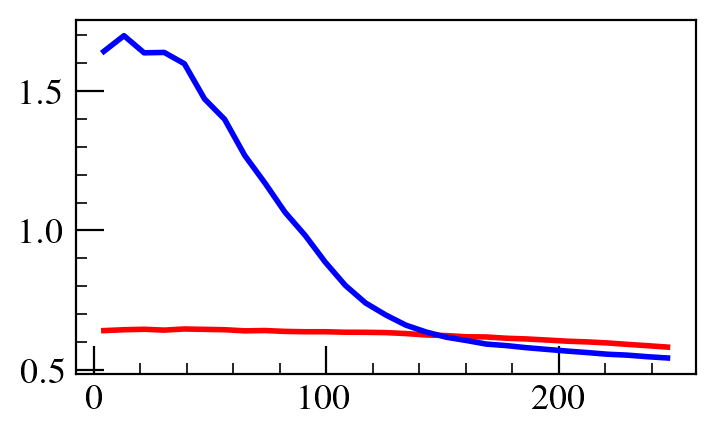

In [315]:
plt.plot(testradtraces[1][0,:], testradtraces[2][0,:], 'r-')
plt.plot(testradtraces[1][100,:], testradtraces[2][100,:], 'b-')

In [155]:
h5dic['ATP_centCrop'].shape

(200, 502, 502)

In [171]:
math.ceil((h5dic['ATP_centCrop'].shape[-1]-int(h5dic['ATP_centCrop'].shape[-1]/6)*6)/2)

2

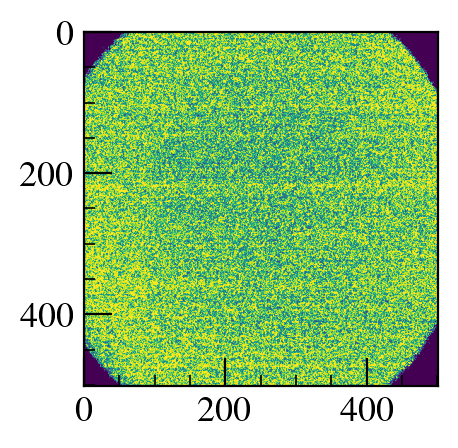

In [179]:
plt.imshow(h5dic['ATP_centCrop'][0])

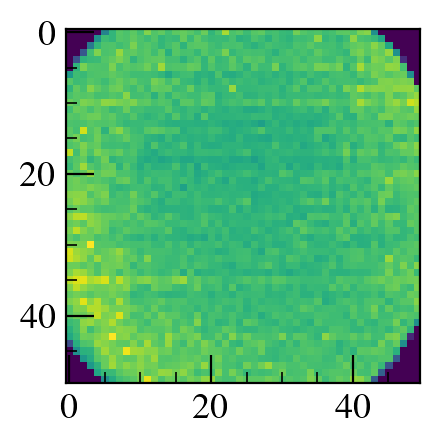

In [195]:
plt.imshow(radialTraces(gname, downsamp = [2, (10,10)], aggmode=np.median)[0])

# Find radial Traces

In [141]:
def profile_fn(arr,
               um_per_pixel,
               r_min=0,
               dr=1.5,
               r_max=None,
               avg_method='median',
               n_positions=100,
               n_wedge=16,):
    """
    Calculate the radial intensity profile of an image, 
    assuming that the (0,0) coordinate is at the center of the image.
    
    Parameters
    ----------
    arr : numpy array
        The series of cropped images of the aster (grayscale).
      
    r_min : float
        Minimum radius beyond which the intensity profile is calculated [px].
    
    dr : float
        Radial binning size [px].
    
    avg_method : string
        The method used for doing a radial average of intensities.
        'median' - median averaging
        'mean' - mean averaging
        
    n_positions : integer
        Number of uniformly spaced radial positions where the average
        intensity is calculated.
        
    n_wedge : integer
        Number of angular bins
        
                      
    Returns
    -------
    profile_output : dictionary
        Dictionary of different outputs listed below
    
      r_unif_ls : numpy array
          Uniformly spaced radii where the average intensity is evaluated.
          
      avg_ls : numpy array
          Average intensities evaluated at 'n_positions' different uniformly
          spaced radii.
          
      std_ls : numpy array
          Standard deviations of intensity values in differents wedges
          
      avg_bin_mat : numpy array
          Two dimensional array to store the average fluorescence values
          at each of 'n_positions' radii and for each angular bin
          
      angles : numpy array
          List of average angles at different bins. E.g., if the upper and
          lower θ-limits are (30° and 60°), then the corresponding element
          in angles will be 45°.
          
      r_ls : numpy array
          Radial distances of all image pixels from the image center.
          
      im_ls : numpy array
          All pixel intensities in the same order as 'r_ls'.
    """

    # Ensure that the image is a numpy array
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)

    # Dimensions of the image
    T, H, W = arr.shape

    # Array of the radial distance of each point from the center
    x_mat, y_mat = np.meshgrid(np.arange(W), np.arange(H))
    x_center = 0.5 * W - 0.5
    y_center = 0.5 * H - 0.5
    
    r_mat = np.sqrt((x_mat - x_center)**2 + (y_mat - y_center)**2)
    # Convert 2d arrays into 1d arrays
    r_ls = r_mat.flatten()
    r_unif_ls = np.linspace(r_min, r_max, n_positions)
    deltar = (r_unif_ls[1]-r_unif_ls[0])/2
    angle_mat = np.mod(np.arctan2(y_mat - y_center, x_mat - x_center),
                       2 * np.pi)
    # List of bin angles
    angle_bins = np.radians(np.linspace(0, 360, n_wedge + 1))
    angles = 0.5 * (angle_bins[1:] + angle_bins[0:-1])
    angle_ls = angle_mat.flatten()

    #     Uniformly spaced radii, starting with r_min and
    # ending with the smallest dimension of the image halved,
    # if r_max is not explicitly specified
    if not r_max:
        r_max = 0.5 * np.min([H, W]) - 0.5
        
    
    #iterate over times:
    
    avg_data_list = []
    for t in range(T):
        im = arr[t]
        im_ls = im.flatten()
        
        # Matrix to store average profiles in each radial bin
        avg_bin_mat = [[] for _ in range(n_wedge)]
        
        for i, r in enumerate(r_unif_ls):
            #dat = im_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]
            dat = im_ls[(r_ls > r - deltar) & (r_ls < r + deltar)]
            #angle_disk = angle_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]
            angle_disk = angle_ls[(r_ls > r - deltar) & (r_ls < r + deltar)]

            for k in range(n_wedge):
                dat_bin = dat[(angle_disk > angle_bins[k])
                              & (angle_disk <= angle_bins[k + 1])]

                if avg_method == 'median':
                    avg_dat_bin = np.median(dat_bin)
                elif avg_method == 'mean':
                    avg_dat_bin = np.mean(dat_bin)
                avg_bin_mat[k].append(avg_dat_bin)

        avg_bin_mat = np.array(avg_bin_mat)
        
        avg_data_list.append(avg_bin_mat)
    avg_bin_arr = np.array(avg_data_list)
    print(avg_bin_arr.shape)     
    if avg_method == 'median':
        avg_ls = np.nanmedian(avg_bin_arr, axis=(1))
    elif avg_method == 'mean':
        avg_ls = np.nanmean(avg_bin_arr, axis=(1))
    else:
        raise ValueError('Incorrect averaging method specified.')

    std_ls = np.std(avg_bin_arr, axis=(1))

    # # Keep only the points inside the disk
    # im_ls = im_ls[r_ls <= r_max]
    # r_ls = r_ls[r_ls <= r_max]
        
        

    profile_output = {
        "r_unif_ls": r_unif_ls,
        "r_unif_ls_um": r_unif_ls * um_per_pixel,
        "avg_ls": avg_ls,
        "std_ls": std_ls,
        "avg_bin_mat": avg_bin_arr,
        "angles": angles,
        #"r_ls": r_ls,
        #"im_ls": im_ls
    }

    return profile_output

In [142]:
um_per_pixel = 0.59/2 #microscope thought that the magnification was 5x when it was actually 10x meaning there are fewer um for the same amount of pixels

motorSummary = profile_fn(mot_conc_ims_cropped,
           um_per_pixel,
           r_min=0,
           dr=1.5,
           r_max=int(min_dist),
           avg_method='median',
           n_positions=100,
           n_wedge=16)

NameError: name 'mot_conc_ims_cropped' is not defined

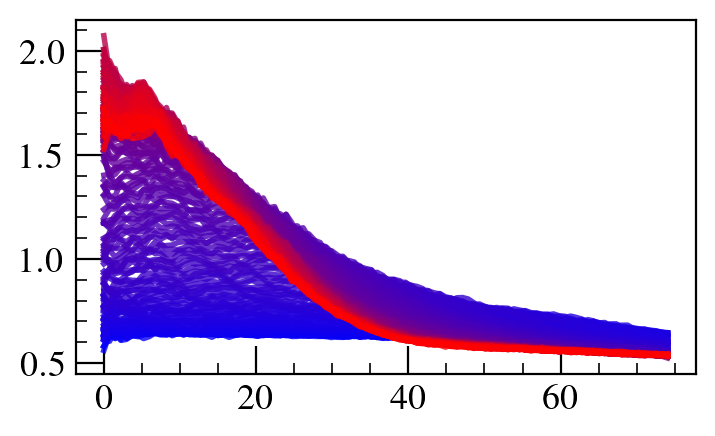

In [54]:
for i in range(200):
    plt.plot(motorSummary['r_unif_ls_um'], motorSummary['avg_ls'][i], color=(i/200, 0, 1-i/200, 0.8))

20241018 ana: Total motors

In [77]:
#based on all the radii over time, pick aster radius
#print(radii*um_per_pixel)
#specify chosen radius
aster_chosenrad = 43

#Look at motors in the chosen aster rad
max_chosenindex = np.where(motorSummary['r_unif_ls_um']<aster_chosenrad)[0][-1]

#define depth of flow cell
depth=70 #um

#compute volume of each shell
toroid_area = []
deltar = motorSummary['r_unif_ls_um'][1]-motorSummary['r_unif_ls_um'][0]
#for first point because here it is zero which means the area is half all the other sections and a circle not a donut
toroid_area.append(2*np.pi*(deltar/2))
#for all radii except the first because the first is 0 so volume will be zero 
for r, radius in enumerate(tqdm(motorSummary['r_unif_ls_um'][1:])):
    area = 2*np.pi*radius*deltar #(r + deltar/2)^2 - (r - deltar/2)^2 = r^2 + rdeltar + deltar^2/4 - r^2 + rdeltar - deltar^2/4
    toroid_area.append(area)
toroid_area = np.array(toroid_area) #um^2
toroid_vol = toroid_area*depth #um^3
toroid_vol_m3 = toroid_vol*1e-18
toroid_vol_L = toroid_vol_m3*1000

#Find total number of motors in chosen radius
tot_mot = []
N_A = scipy.constants.N_A
for t in range(200):
    tot_mot.append(np.sum(motorSummary['avg_ls'][t][:max_chosenindex]*toroid_vol_L[:max_chosenindex])*N_A*1e-6)

  0%|          | 0/99 [00:00<?, ?it/s]

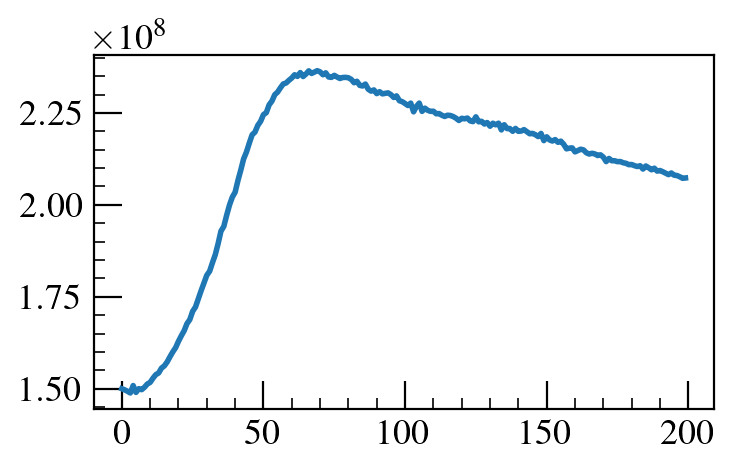

In [78]:
plt.plot(tot_mot)

In [74]:
scipy.constants.N_A

6.02214076e+23

In [59]:
np.trapz(motorSummary['avg_ls'][10][:41], motorSummary['r_unif_ls_um'][:41])

19.262866052731574

In [66]:
np.where(motorSummary['r_unif_ls_um']<31)[0][-1]

41

Text(0, 0.5, 'integrated motor concentration\n$\\int_0^r \\rho(r)~dr$')

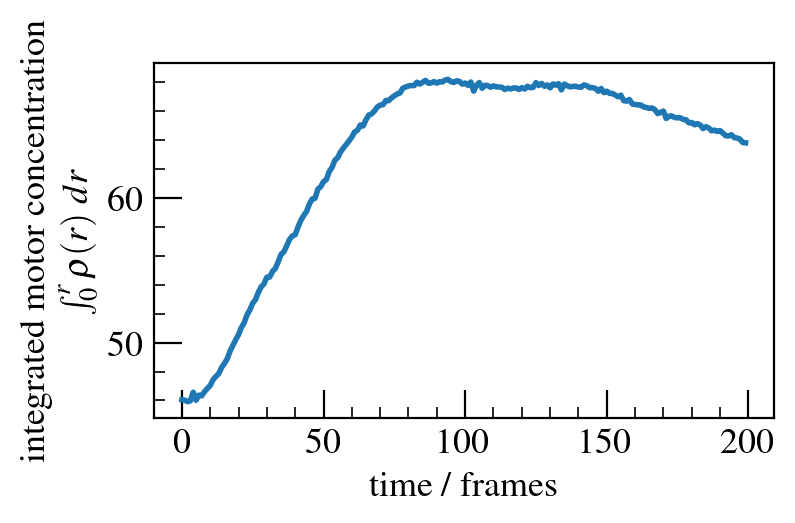

In [51]:
totMotConcs=[]
for t in range(200):
    totMotConcs.append(np.trapz(motorSummary['avg_ls'][t], motorSummary['r_unif_ls_um']))
    
plt.plot([t for t in range(200)], totMotConcs)
plt.xlabel('time / frames')
plt.ylabel('integrated motor concentration\n'+r'$\int_0^r \rho(r)~dr$')

In [51]:
um_per_pixel = 0.59/2 #microscope thought that the magnification was 5x when it was actually 10x meaning there are fewer um for the same amount of pixels

ATP_Summary = profile_fn(ATP_conc_ims_cropped,
           um_per_pixel,
           r_min=0,
           dr=1.5,
           r_max=int(min_dist),
           avg_method='median',
           n_positions=100,
           n_wedge=16)

/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(200, 16, 100)


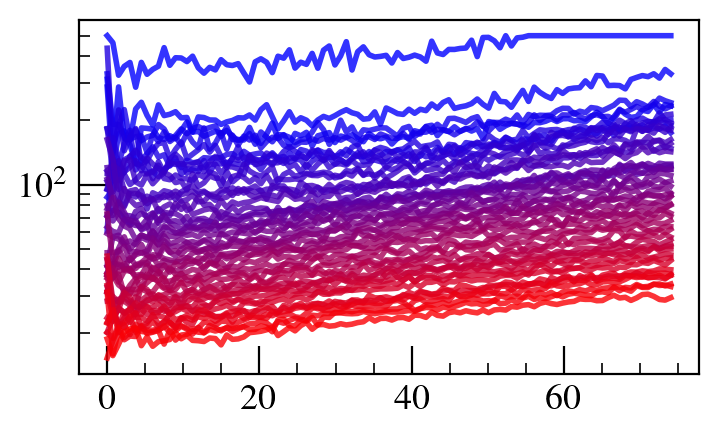

In [52]:
for i in range(0,200,4):
    plt.plot(ATP_Summary['r_unif_ls_um'], ATP_Summary['avg_ls'][i], color=(i/200, 0, 1-i/200, 0.8))
    
plt.yscale('log')

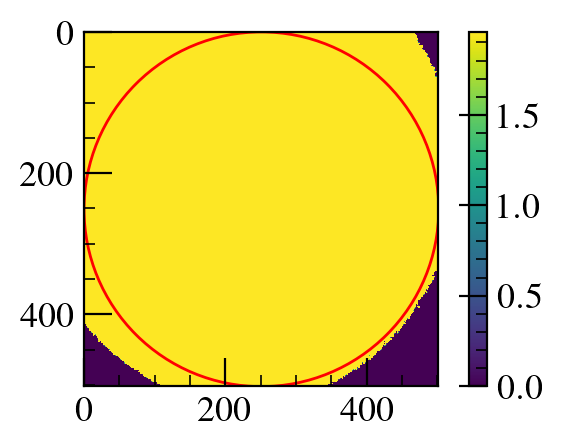

In [49]:
fig, ax = plt.subplots()
plt.imshow(ATP_conc_ims_cropped[120], vmin=0, vmax=np.percentile(mot_conc_ims_cropped, 99.9))
plt.colorbar()
circ1 = patches.Circle((min_dist, min_dist), min_dist, edgecolor='r', fill=False)
ax.add_patch(circ1)

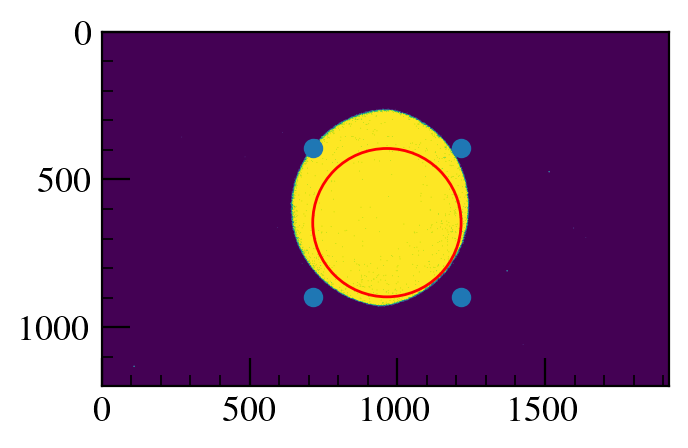

In [50]:
test=120
fig,ax=plt.subplots()
plt.imshow(mango_mask)
plt.scatter([centers[test][0]-min_dist,centers[test][0]-min_dist, centers[test][0]+min_dist, centers[test][0]+min_dist],  
           [centers[test][1]-min_dist,centers[test][1]+min_dist, centers[test][1]-min_dist, centers[test][1]+min_dist])
circ1 = patches.Circle((centers[test][0], centers[test][1]), min_dist, edgecolor='r', fill=False)
ax.add_patch(circ1)

# define time and crop params

In [81]:
#define the time  of each frame
times_sec = np.arange(len(mot_conc_ims_cropped))*exp_params['interval']
times_min = times_sec/60

#square inscribed in circle
side_length = int(min_dist/np.sqrt(2))
inscribe_crop_all = np.s_[:, round(min_dist)-side_length:round(min_dist)+side_length,
                     round(min_dist)-side_length:round(min_dist)+side_length]


# Downsampling

## `Downsample` in space for movie too!

In [95]:
def justSpaceAvg(imgArray, spatialBlock, mode='valid', clip=True):
    """ Also try mode='valid' if you want to only compute time points where the window fits """
    # first, take time running average
    #window = np.ones(numTimesWindow) / numTimesWindow
    # 0 refers to first axis (assumed to be time, if imgArray = numTimes x height x width)
    #timeAvgd= np.apply_along_axis(lambda m: np.convolve(m, window, mode=mode), 0, imgArray)
    
    # next, do space average
    spaceAvgd=np.zeros((imgArray.shape[0], imgArray.shape[1]//spatialBlock[0], imgArray.shape[1]//spatialBlock[0]))
    for t in range(imgArray.shape[0]):
        spaceAvgd[t,:,:]=skimage.measure.block_reduce(imgArray[t,:,:],block_size=spatialBlock, func=np.mean)
    
    ## optionally, clip to 99th percentile
    if clip:
        percentile=99.99
        for t in range(spaceAvgd.shape[0]):
            cutOff=np.percentile(spaceAvgd[t,:,:].flatten(), percentile)
            spaceAvgd[t,:,:]=np.where(spaceAvgd[t,:,:]>cutOff, np.nan, spaceAvgd[t,:,:])
    
    return spaceAvgd

Apply function

In [103]:
ds_ATP=justSpaceAvg(ATP_conc_ims_cropped[inscribe_crop_all], spatialBlock=(6,6), clip=False)
ds_mot=justSpaceAvg(mot_conc_ims_cropped[inscribe_crop_all], spatialBlock=(6,6), clip=False)

plot

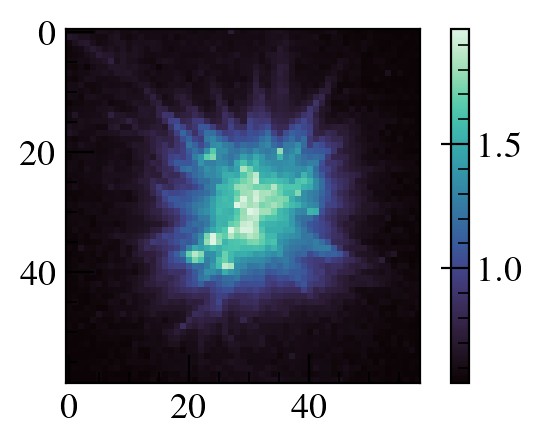

In [98]:
# side_length = int(min_dist/np.sqrt(2))
# inscribe_crop = np.s_[round(min_dist)-side_length:round(min_dist)+side_length,
#                      round(min_dist)-side_length:round(min_dist)+side_length]
fig, ax = plt.subplots()
plt.imshow(ds_mot[133], vmin=np.percentile(ds_mot, 2), 
                                                   vmax=np.percentile(ds_mot, 99.9),
          cmap=sns.color_palette('mako', as_cmap=True))#)
          #cmap=sns.color_palette('rocket', as_cmap=True))
plt.colorbar()
# circ1 = patches.Circle((min_dist, min_dist), min_dist, edgecolor='r', fill=False)
# ax.add_patch(circ1)


## `Downsample` in space AND time, for movie

In [100]:
def spaceTimeAvg(imgArray, numTimesWindow, spatialBlock, mode='valid', clip=True):
    """ Also try mode='valid' if you want to only compute time points where the window fits """
    # first, take time running average
    window = np.ones(numTimesWindow) / numTimesWindow
    # 0 refers to first axis (assumed to be time, if imgArray = numTimes x height x width)
    timeAvgd= np.apply_along_axis(lambda m: np.convolve(m, window, mode=mode), 0, imgArray)
    
    # next, do space average
    spaceTimeAvgd=np.zeros((timeAvgd.shape[0], timeAvgd.shape[1]//spatialBlock[0], timeAvgd.shape[1]//spatialBlock[0]))
    for t in range(timeAvgd.shape[0]):
        spaceTimeAvgd[t,:,:]=skimage.measure.block_reduce(timeAvgd[t,:,:],block_size=spatialBlock, func=np.mean)
    
    ## optionally, clip to 99th percentile
    if clip:
        percentile=99.99
        for t in range(spaceTimeAvgd.shape[0]):
            cutOff=np.percentile(spaceTimeAvgd[t,:,:].flatten(), percentile)
            spaceTimeAvgd[t,:,:]=np.where(spaceTimeAvgd[t,:,:]>cutOff, np.nan, spaceTimeAvgd[t,:,:])
    
    return spaceTimeAvgd

In [101]:
# ATP Downsampling in space AND time
ds_sptm_ATP=spaceTimeAvg(ATP_conc_ims_cropped[inscribe_crop_all], numTimesWindow=2, spatialBlock=(6,6), clip=False)
# motor Downsampling in space AND time
ds_sptm_mot=spaceTimeAvg(mot_conc_ims_cropped[inscribe_crop_all], numTimesWindow=2, spatialBlock=(6,6), clip=False)

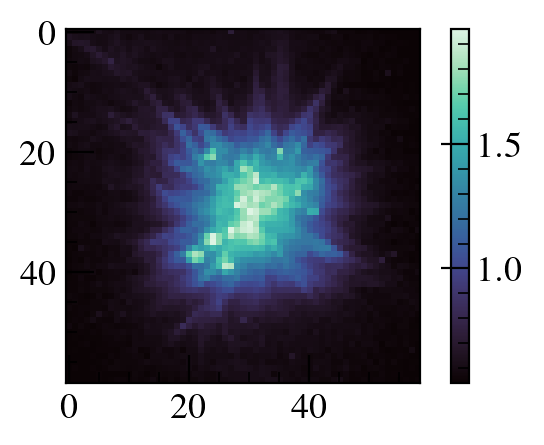

In [102]:
fig, ax = plt.subplots()
plt.imshow(ds_sptm_mot[133], vmin=np.percentile(ds_sptm_mot, 2), 
                                                   vmax=np.percentile(ds_sptm_mot, 99.9),
          cmap=sns.color_palette('mako', as_cmap=True))#)
          #cmap=sns.color_palette('rocket', as_cmap=True))
plt.colorbar()
# circ1 = patches.Circle((min_dist, min_dist), min_dist, edgecolor='r', fill=False)
# ax.add_patch(circ1)


## `Downsample` in just time, for movie

In [104]:
def justTimeAvg(imgArray, numTimesWindow, mode='valid'):
    """ Also try mode='valid' if you want to only compute time points where the window fits """
    # first, take time running average
    window = np.ones(numTimesWindow) / numTimesWindow
    # 0 refers to first axis (assumed to be time, if imgArray = numTimes x height x width)
    timeAvgd= np.apply_along_axis(lambda m: np.convolve(m, window, mode=mode), 0, imgArray)
    
#     # next, do space average
#     spaceTimeAvgd=np.zeros((timeAvgd.shape[0], timeAvgd.shape[1]//spatialBlock[0], timeAvgd.shape[1]//spatialBlock[0]))
#     for t in range(timeAvgd.shape[0]):
#         spaceTimeAvgd[t,:,:]=skimage.measure.block_reduce(timeAvgd[t,:,:],block_size=spatialBlock, func=np.mean)
    
#     ## optionally, clip to 99th percentile
#     if clip:
#         percentile=99.99
#         for t in range(spaceTimeAvgd.shape[0]):
#             cutOff=np.percentile(spaceTimeAvgd[t,:,:].flatten(), percentile)
#             spaceTimeAvgd[t,:,:]=np.where(spaceTimeAvgd[t,:,:]>cutOff, np.nan, spaceTimeAvgd[t,:,:])
    
    return timeAvgd

In [105]:
# ATP Downsampling in time only
ds_tm_ATP=justTimeAvg(ATP_conc_ims_cropped[inscribe_crop_all], numTimesWindow=2)
# motor downsample in time only
ds_tm_mot=justTimeAvg(mot_conc_ims_cropped[inscribe_crop_all], numTimesWindow=2)

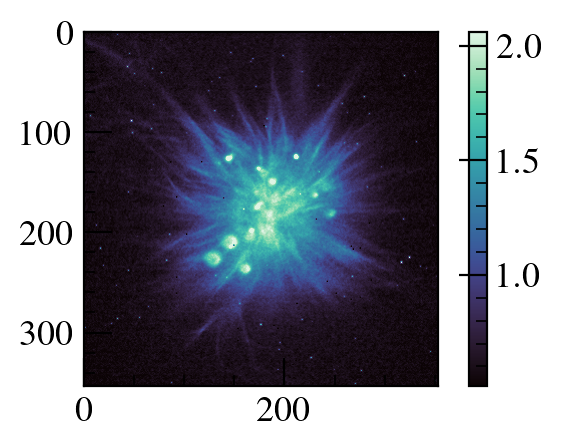

In [106]:
fig, ax = plt.subplots()
plt.imshow(ds_tm_mot[133], vmin=np.percentile(ds_tm_mot, 2), 
                                                   vmax=np.percentile(ds_tm_mot, 99.9),
          cmap=sns.color_palette('mako', as_cmap=True))#)
          #cmap=sns.color_palette('rocket', as_cmap=True))
plt.colorbar()
# circ1 = patches.Circle((min_dist, min_dist), min_dist, edgecolor='r', fill=False)
# ax.add_patch(circ1)


# movies eek!!!!!!

Find the square that inscribes the circle

# motor movie`

  0%|          | 0/200 [00:00<?, ?it/s]

/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


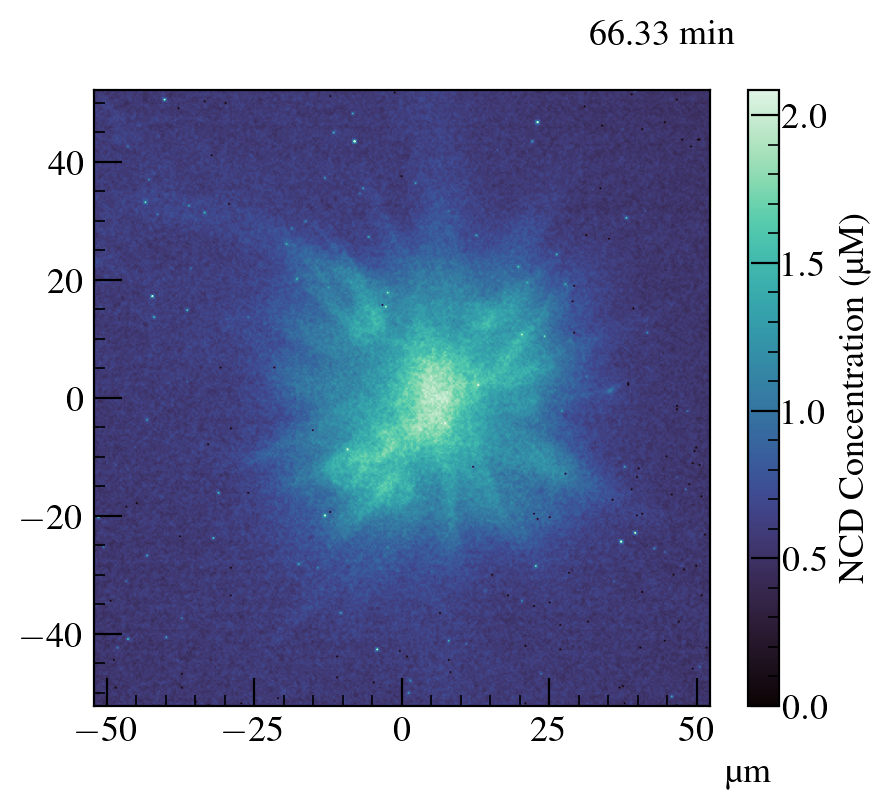

In [94]:
ims = []
side_length = int(min_dist/np.sqrt(2))
inscribe_crop = np.s_[round(min_dist)-side_length:round(min_dist)+side_length,
                     round(min_dist)-side_length:round(min_dist)+side_length]
plot_array = mot_conc_ims_cropped[inscribe_crop_all]#ds_sptm_mot
plot_times = times_min #min
winsize_um = side_length*um_per_pixel
cmap = sns.color_palette('mako', as_cmap=True)#cm.get_cmap('binary_r')
colorbar_min = np.percentile(plot_array, 0)
colorbar_max = np.percentile(plot_array, 99.9)
normalizer = Normalize(colorbar_min, colorbar_max)
cb_setting = cm.ScalarMappable(norm=normalizer, cmap=cmap)
extent = [-winsize_um, winsize_um, -winsize_um, winsize_um]

fig, ax = plt.subplots(figsize = (5,4))

#ax.set_title("NCD Kinesin Motors")

camera = cell.Camera(fig)

for i, time in enumerate(tqdm(plot_times)):
    im_temp = plot_array[i]
    im = ax.imshow(im_temp,
                   vmin=colorbar_min,
                   vmax=colorbar_max,
                   cmap = cmap,
                   animated=True,
                   extent=extent,
                   zorder=0)
    # ax.text(-105, 100, str(round(time, 2)), color = 'w')
    # ax.text(-80, 100, " min", color = 'w')
    ax.text(32, 60, str(round(time, 2)), color = 'k')
    ax.text(47, 60, " min", color = 'k')
    ax.text(55,-65, " µm", color = 'k')
    camera.snap()
cbar = plt.colorbar(cb_setting, label = "NCD Concentration (µM)")#, ticks = cbar_range)
cbar.ax.tick_params(pad=1)
# plt.xlabel('µm')
# plt.ylabel('µm')
    
animation = camera.animate()
save_path ='../../analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/'
animation.save(save_path+"20240911_motor_movie.mp4",dpi=400, fps=20)

# ATP movie

# downsample movie in space and time

In [163]:
ds_sptm_ATP.shape

(199, 59, 59)

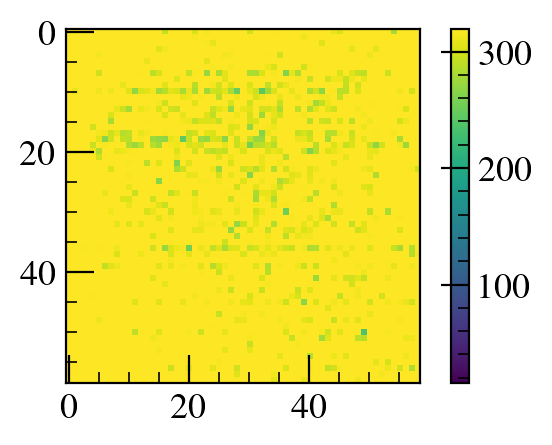

In [161]:
plt.imshow(ds_sptm_ATP[0], vmin= np.percentile(ds_sptm_ATP, 0), vmax= np.percentile(ds_sptm_ATP, 99))
plt.colorbar()

  0%|          | 0/199 [00:00<?, ?it/s]

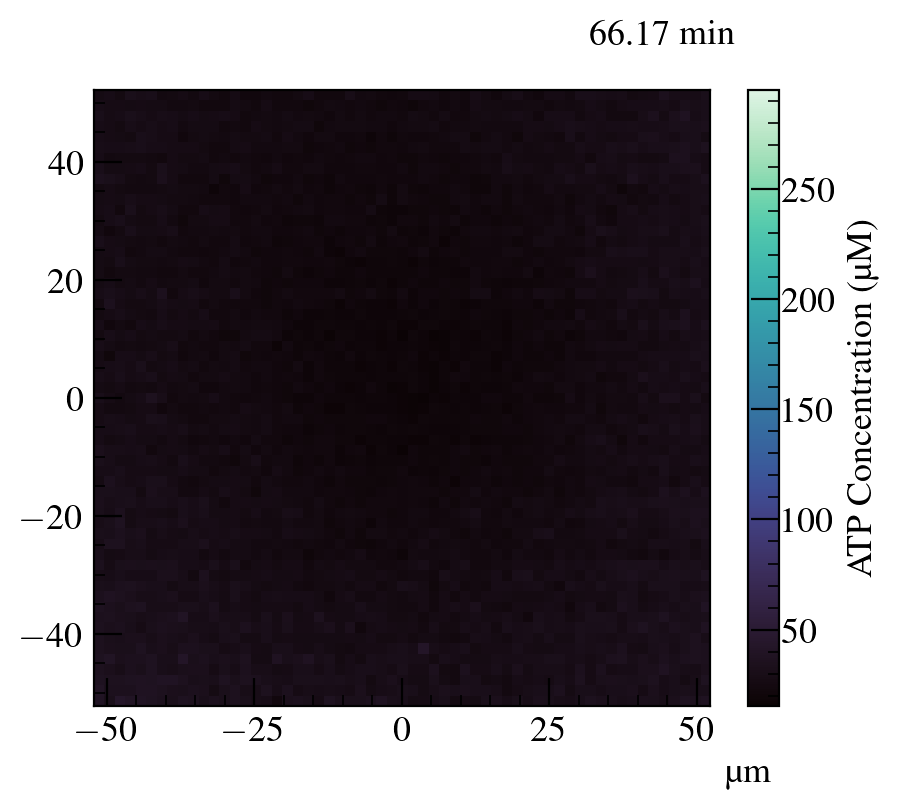

In [165]:
ims = []

side_length = int(min_dist/np.sqrt(2))
inscribe_crop = np.s_[round(min_dist)-side_length:round(min_dist)+side_length,
                     round(min_dist)-side_length:round(min_dist)+side_length]
plot_array = ds_sptm_ATP
plot_times = (times_sec[1:] - exp_params['interval']/2)/60 #min
winsize_um = side_length*um_per_pixel
extent = [-winsize_um, winsize_um, -winsize_um, winsize_um]


cmap = sns.color_palette('mako', as_cmap=True)
colorbar_min = np.percentile(plot_array, 0)
colorbar_max = np.percentile(plot_array, 98)
#cbar_range = [np.percentile(ratios_plot[40], 9), np.percentile(ratios_plot[40], 36), np.percentile(ratios_plot[40],63), np.percentile(ratios_plot[40], 90)]
#cbar_range_ATP = ATP_inten_to_conc(np.array(cbar_range), 742,  1.49,   0.78,   2.02)
# cbar_range_ATPint = []
# for i, val in enumerate(cbar_range_ATP):
#     cbar_range_ATPint.append(int(val))

normalizer = Normalize(colorbar_min, colorbar_max)
cb_setting = cm.ScalarMappable(norm=normalizer, cmap=cmap)
fig, ax = plt.subplots(figsize=(5,4))

#ax.set_title("ATP")

camera = cell.Camera(fig)

for i, time in enumerate(tqdm(plot_times)):
    im_temp = plot_array[i]
    im = ax.imshow(im_temp,
                   vmin=colorbar_min,
                   vmax=colorbar_max,
                   cmap = cmap,
                   animated=True,
                   extent = extent,
                   zorder=0)
    ax.text(32, 60, str(round(time, 2)), color = 'k')
    ax.text(47, 60, " min", color = 'k')
    ax.text(55,-65, " µm", color = 'k')
    camera.snap()
cbar = plt.colorbar(cb_setting, label = "ATP Concentration (µM)")#, ticks = cbar_range)

#cbar.ax.set_yticklabels([colorbar_min, colorbar_max]) 
cbar.ax.tick_params(pad=1)
#cbar.ax.set_yticklabels(cbar_range_ATPint)
#plt.xlabel('µm')
#plt.ylabel('µm')
    
animation = camera.animate()
save_path ='../../analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/'
animation.save(save_path+"20240911_ATP_movie_ds_sp6x6_tm2.mp4",dpi=400, fps=20)

# Radial Trace plot

# Gabe code radial trace maker

In [51]:
### hackish binning alternative
## assume square
def cartesianToPolar(image):
    """ Assumes image is a m x m (square, 2d) array, and the origin is the closest-to-central pixel.
        Returns:
            list of all r values of each pixel
    """
    
    m = image.shape[0]
    center = (m // 2, m // 2)
    
    # Create grid of coordinates
    y, x = np.indices((m, m))
    x = x - center[1]
    y = y - center[0]
    
    # Convert to polar coordinates
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    
    return r, theta

def polarAverage(image, bins=20, aggFunct=np.nanmedian):
    r, theta = cartesianToPolar(image)
    
    if type(bins)==int:
        # if just an integer, automatically find the radial bins
        max_radius = np.max(r)
        radial_bins = np.linspace(0, max_radius, bins)
        radial_profile = np.zeros(bins - 1) #preallocate
    
    else:
        # else, if bins is an array, assume that the bin edges are supplied explicitly.
        radial_bins=bins;
        radial_profile = np.zeros(bins.shape[0] - 1)
    
    for i in range(len(radial_bins) - 1):
        mask = (r >= radial_bins[i]) & (r < radial_bins[i + 1])
        radial_profile[i] = aggFunct(image[mask])
    
    return (radial_bins[:-1]+radial_bins[1:])/2, radial_profile # this returns the MIDPOINT of the radii defining the annuli bins

def getSensibleBins(image, numBins=15):
    rmax=image.shape[0]//2
    return np.linspace(0, rmax, numBins)

In [52]:
numRbins=30

# preallocate
all_rbins=np.zeros((mot_conc_ims_cropped.shape[0], numRbins-1))
all_rMotavgs=np.zeros((mot_conc_ims_cropped.shape[0], numRbins-1))

for t in range(mot_conc_ims_cropped.shape[0]):
    frame=mot_conc_ims_cropped[t,:,:]
    rbins_thist, radAvgmot_thist= polarAverage(frame, getSensibleBins(frame, numBins=numRbins), aggFunct=np.median)
    all_rbins[t, :]=rbins_thist
    all_rMotavgs[t, :]=radAvgmot_thist

In [53]:
numRbins=30

# preallocate
all_rbins=np.zeros((ATP_conc_ims_cropped.shape[0], numRbins-1))
all_rATPavgs=np.zeros((ATP_conc_ims_cropped.shape[0], numRbins-1))

for t in range(ATP_conc_ims_cropped.shape[0]):
    frame=ATP_conc_ims_cropped[t,:,:]
    rbins_thist, radAvgATP_thist= polarAverage(frame, getSensibleBins(frame, numBins=numRbins), aggFunct=np.median)
    all_rbins[t, :]=rbins_thist
    all_rATPavgs[t, :]=radAvgATP_thist

# ANA YOU USED THIS ONE

NameError: name 'save_path' is not defined

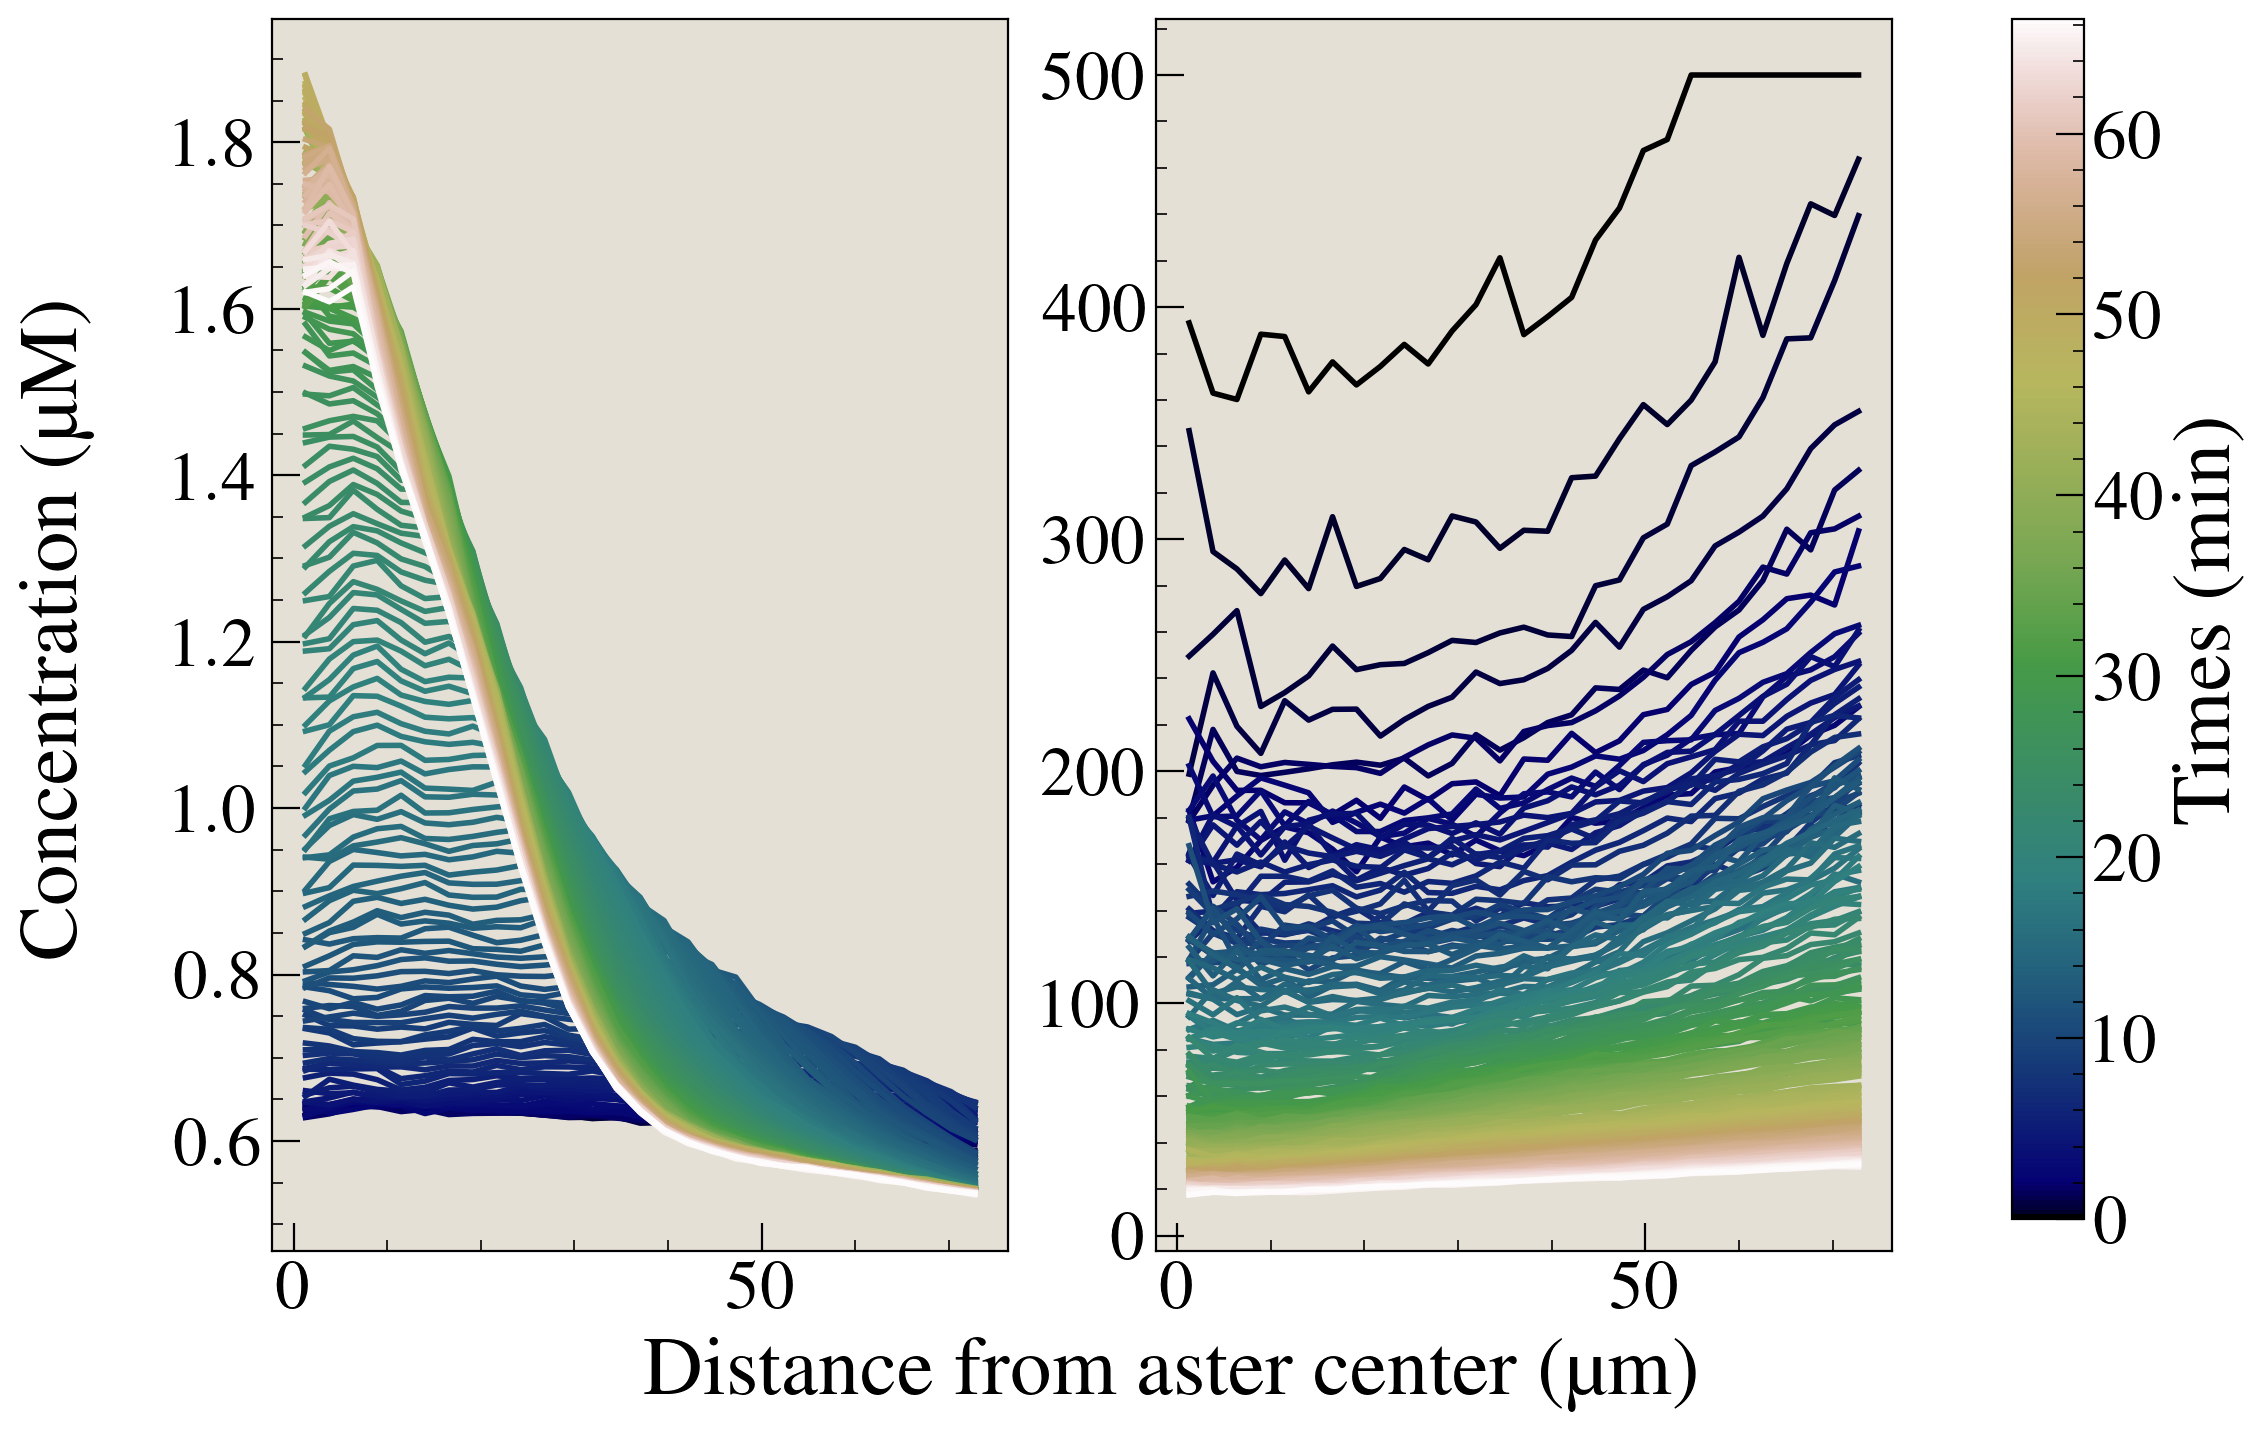

In [54]:
### Plot alternative binning
#plot_times = #np.arange(len(ATP_Summary['avg_ls']))*exp_params['interval']
plot_times = np.arange(len(all_rATPavgs))*exp_params['interval']/60 #min

mod_num = 1

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=0, vmax=plot_times.max())
colormap = cm.gist_earth
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(plot_times)

for i, time in enumerate(plot_times):
#for time in range(200):
    if i%mod_num==0:
        ax[1].plot(all_rbins[i,:]*um_per_pixel,
                 all_rATPavgs[i,:],
                 lw=2,
                 color = colormap(normalize(time)),
                 label=str(round(time, 2)))

        ax[0].plot(all_rbins[i,:]*um_per_pixel,
                 all_rMotavgs[i,:],
                 lw=2,
                 color = colormap(normalize(time)),
                 label=str(round(time, 2)))

#ax[0].set_box_aspect(1.5)
#ax[1].set_box_aspect(1.5)

#ax[0].set_xscale('log')

fig.supxlabel('Distance from aster center (µm)', fontsize=30)
fig.supylabel('Concentration (µM)', fontsize=30)
# ax[0].set_ylabel('Motor Concentration (µM)')
# ax[1].set_ylabel('ATP Concentration (µM)')
# ax[0].set_xlabel('Distance from aster center (µm)')
# ax[1].set_xlabel('Distance from aster center (µm)')

ax[0].set_facecolor(color_background)
ax[1].set_facecolor(color_background)

ax[0].tick_params('both', labelsize=25)
ax[1].tick_params('both', labelsize=25)
#ax[1].set_ylim(0, 375)

fig.subplots_adjust(right=0.8)
color_bar_ax = fig.add_axes([0.85, 0.13, 0.03, 0.75])
cbar = fig.colorbar(scalarmappable, cax=color_bar_ax)
cbar.ax.tick_params(labelsize=25)
cbar.set_label(label="Times (min)", size=30, weight='bold')

# scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
# scalarmappable.set_array(plot_times)
# cbar = plt.colorbar(scalarmappable, label = "Times (min)")

fig.savefig(save_path+'20240909_Motor_ATP_Traces.pdf')


# POWWWWWA

In [55]:
def power_prof(times, conc_trace, toroid_vol_m3, deltat):
    #subtract the traces in the region
    pow_uM_per_s = -np.diff(conc_trace, axis=0)/deltat
    pow_umol_per_s = np.zeros(len(pow_uM_per_s))
    for i, p in enumerate(pow_uM_per_s):
        pow_umol_per_s[i] = np.sum(p*toroid_vol_m3*1000) #*1000 bc 1000L/m^3
    pow_ATP_per_s = pow_umol_per_s*1e-6*N_A
    return pow_ATP_per_s#np.array(power)

In [211]:
def power_prof_perum(times, conc_trace, toroid_vol_m3, deltat):
    #subtract the traces in the region
    pow_uM_per_s = -np.diff(conc_trace, axis=0)/deltat
    uM_to_permicron3 = 1e3*(1e-6)**3*1e-6*N_A # 1000 L/m^3 * (m/10^6 um)^3 * (mol/10^6 umol) * (6*10^23 ATP/mol)
    return pow_uM_per_s*uM_to_permicron3

In [226]:
pow_perum3.shape, pow_perum3_smoo.shape

((199, 29), (29, 199))

Text(0, 0.5, '$\\frac{\\mathrm{ATPs}}{\\mu m^3\\cdot s}$')

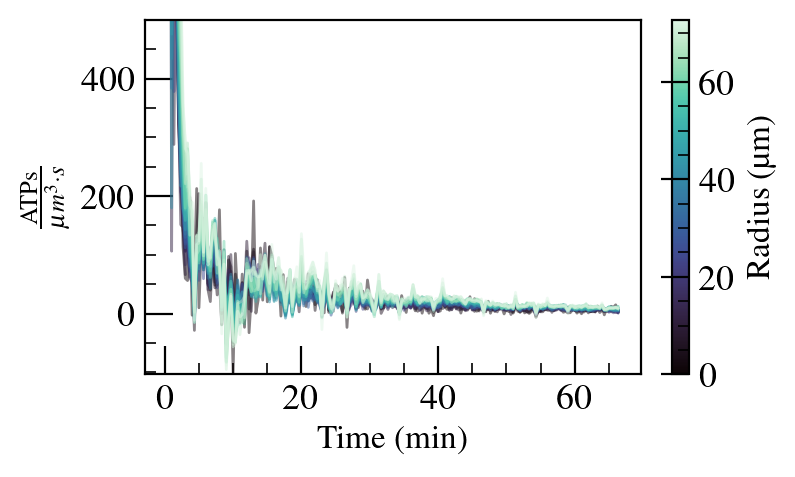

In [266]:
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=0, vmax=(all_rbins*um_per_pixel).max())
colormap = sns.color_palette('mako', as_cmap=True)
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(all_rbins[0]*um_per_pixel)

pow_perum3 = power_prof_perum(times_sec, all_rATPavgs, toroid_vol_m3, deltat).T
pow_perum3_smoo = np.zeros_like(pow_perum3)
for i in range(len(pow_perum3_smoo)):
    pow_perum3_smoo[i] = float_avg(pow_perum3[i],4)
for i, p in enumerate(pow_perum3_smoo):
    plt.plot(times_min[1:], p, lw=1, alpha=0.5, color = colormap(normalize(all_rbins[0][i]*um_per_pixel)))#color=(i/len(pow_perum3_smoo), 0, 1-i/len(pow_perum3_smoo), 0.8)
plt.ylim(pow_perum3_smoo.min(), 500)
cbar = plt.colorbar(scalarmappable)
cbar.set_label(label="Radius (µm)", size=12, weight='bold')
plt.xlabel('Time (min)', size=12)
plt.ylabel(r'$\frac{\mathrm{ATPs}}{\mu m^3\cdot s}$', size=12)

In [56]:
def float_avg(array, window):
    """ 
    Smooths noisy data by replacing individual values with the average of neighboring values
    
    Params:
    array: array of data to smooth
    window: half the interval (how many points to each side) you want to average over. - note this function does something strange 
    at the end where the last point takes the interval before and averages forgetting the interval after.So if your window is 1, 
    you average over 3 points, i-1, i, i+1. For the last point in the array, you only average two i-1, and i. I don't understand 
    why it isn't throwing an error but I am going with it. Note, I am keeping the first window value of points equal to their original 
    value without averageing. So in this case i=0 stays its original value and we start averaging when i=1
    
    Returns:
    Smoothed array witht he same length as the inputted array
    
    """
    smoo_array = []
    for i in range(len(array)):
        if i<window:
            smoo_array.append(array[i])
        else:
            smoo_array.append(np.average(array[i-window:i+window+1]))
    smoo_array = np.array(smoo_array)
    return smoo_array

volume of each cylinder shell

In [57]:
plot_times = np.arange(len(all_rATPavgs))*exp_params['interval']

deltat = round((plot_times[1]-plot_times[0])) # seconds
deltar = np.diff(all_rbins[0])[0]*um_per_pixel #um
N_A = scipy.constants.Avogadro
depth = 70 #um

print('delta t: ' + str(deltat))
print('delta r: ' + str(round(deltar,2)))

toroid_area = []
for r, radius in enumerate(tqdm(all_rbins[0]*um_per_pixel)):
    area = 2*np.pi*radius*deltar #(r + deltar/2)^2 - (r - deltar/2)^2 = r^2 + rdeltar + deltar^2/4 - r^2 + rdeltar - deltar^2/4
    toroid_area.append(area)
toroid_area = np.array(toroid_area) #um^2
toroid_vol = toroid_area*depth #um^3
toroid_vol_m3 = toroid_vol*1e-18

delta t: 20
delta r: 2.55


  0%|          | 0/29 [00:00<?, ?it/s]

Find power and smooth

In [58]:
plot_times = np.arange(len(all_rATPavgs))*exp_params['interval'] #sec
ratios_power_smoo = float_avg(power_prof(plot_times, all_rATPavgs, toroid_vol_m3, deltat),4)

Average whole movie

In [59]:
#plt.scatter(plot_times[2:],-np.diff(np.sum(ds_sptm_ATP, axis=(1,2)))/deltat, s=5)
inscrib_convert = 2*np.pi # Acircle/√2π = π(min_dist)^2/√2π = (side_length)^2 = Asquare
plt.scatter(plot_times[2:],float_avg(-np.diff(np.sum(ds_sptm_ATP, axis=(1,2)))/deltat,1)*depth*side_length**2 * um_per_pixel**2*inscrib_convert, s=5)
#plt.yscale('log')


NameError: name 'ds_sptm_ATP' is not defined

In [60]:
def power_prof_movfirst(times, conc_trace, toroid_vol_m3, deltat):
    #subtract the traces in the region
    pow_uM_per_s = -np.diff(conc_trace, axis=0)/deltat
    pow_umol_per_s = np.zeros(len(pow_uM_per_s))
    for i, p in enumerate(pow_uM_per_s):
        pow_umol_per_s[i] = np.sum(p*toroid_vol_m3*1000) #*1000 bc 1000L/m^3
    pow_ATP_per_s = pow_umol_per_s*1e-6*N_A
    return pow_ATP_per_s#np.array(power)

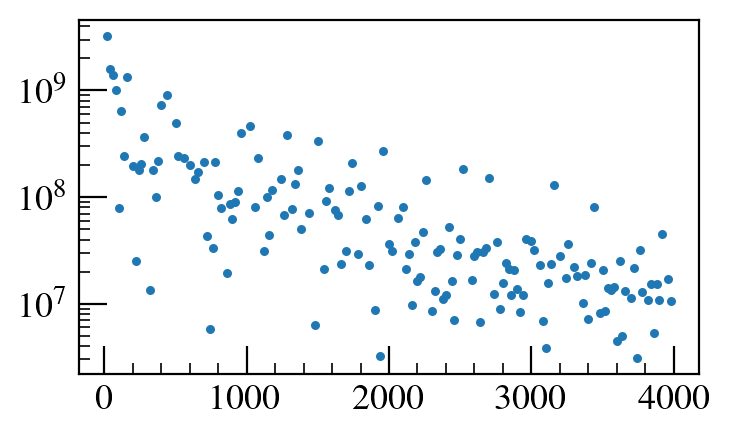

In [61]:
plt.scatter(plot_times[1:], power_prof(plot_times, all_rATPavgs, toroid_vol_m3, deltat), s=5)
plt.yscale('log')

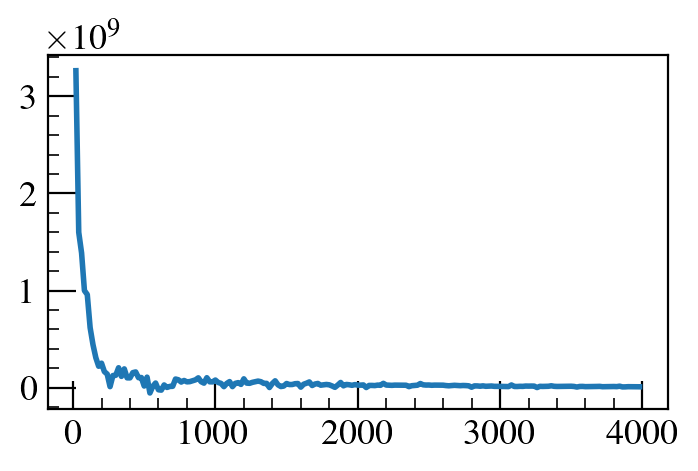

In [62]:
ratios_power_smoo = float_avg(power_prof(plot_times, all_rATPavgs, toroid_vol_m3, deltat),4)
plt.plot(plot_times[1:], ratios_power_smoo)
#plt.yscale('log')

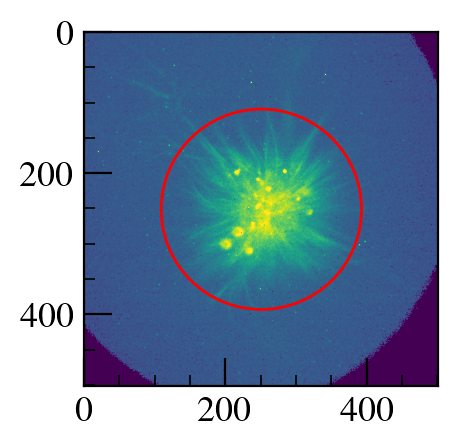

In [63]:
testi=130
fig,ax=plt.subplots()
ax.imshow(mot_conc_ims_cropped[testi], vmin=0, vmax=2)
circ1 = patches.Circle((min_dist, min_dist), radii[testi], edgecolor='r', fill=False)
ax.add_patch(circ1)

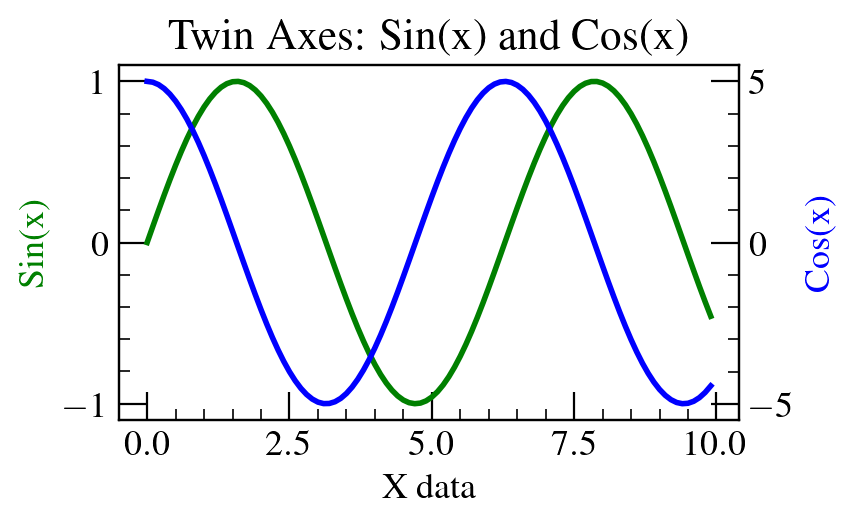

In [64]:
# Create sample data
x = np.arange(0, 10, 0.1)
y1 = np.sin(x)
y2 = 5*np.cos(x)

# Create figure and first axis
fig, ax1 = plt.subplots()

# Plot on the first y-axis
ax1.plot(x, y1, 'g-', label='Sin(x)')
ax1.set_xlabel('X data')
ax1.set_ylabel('Sin(x)', color='g')

# Create second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(x, y2, 'b-', label='Cos(x)')
ax2.set_ylabel('Cos(x)', color='b')

# Show plot
plt.title("Twin Axes: Sin(x) and Cos(x)")
plt.show()

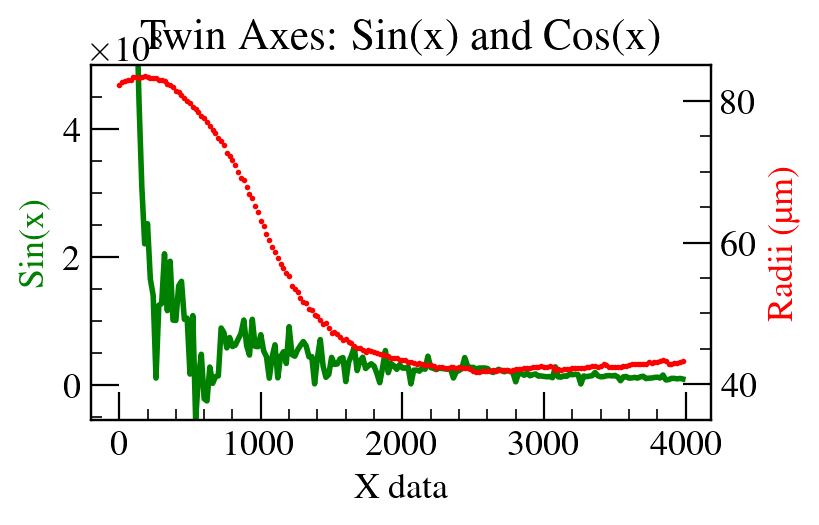

In [65]:
# Create figure and first axis
fig, ax1 = plt.subplots()
# Plot on the first y-axis
ax1.plot(plot_times[1:], ratios_power_smoo, c='g', label='Sin(x)')
ax1.set_xlabel('X data')
ax1.set_ylim(ratios_power_smoo.min(), 5e8)
ax1.set_ylabel('Sin(x)', color='g')

# Create second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.scatter(plot_times, radii*um_per_pixel, c='r', s=1, label='radii (µm)')
ax2.set_ylabel('Radii (µm)', color='r')
ax2.set_ylim(35, 85)
# Show plot
plt.title("Twin Axes: Sin(x) and Cos(x)")
plt.show()


# power movie

try with twin axis

In [370]:
all_rATPavgs.shape, ratios_power_smoo.shape

((200, 29), (199,))

  0%|          | 0/200 [00:00<?, ?it/s]

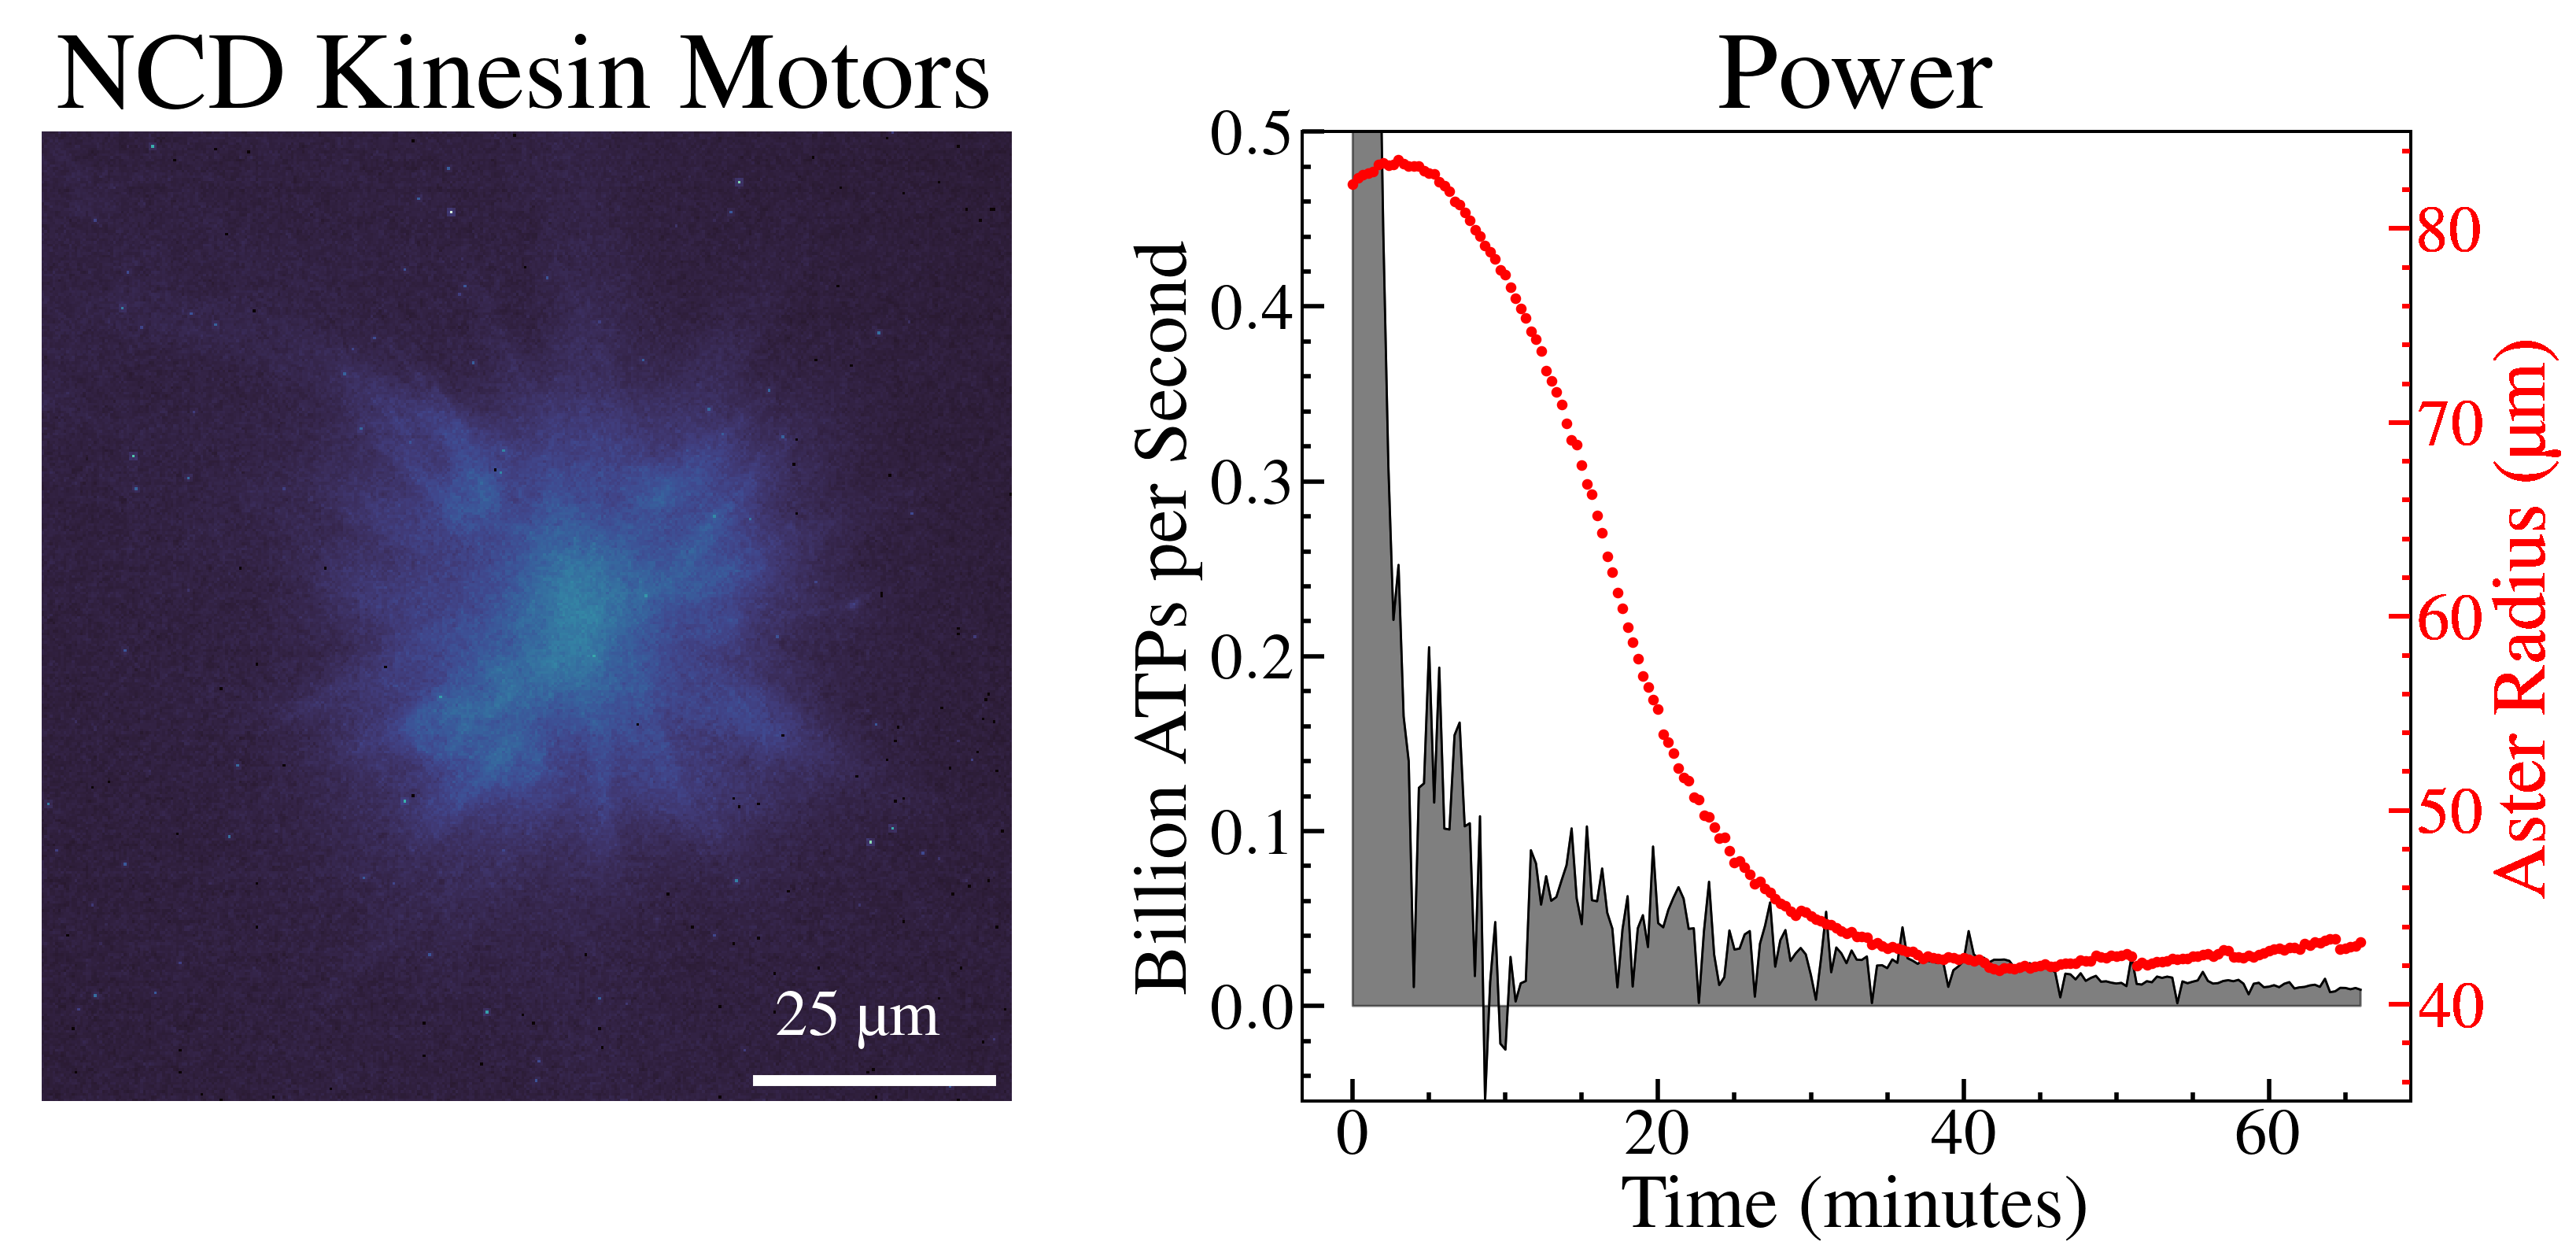

In [376]:
plot_times = (np.arange(len(all_rATPavgs))*exp_params['interval']/60)
ims = []
cmap = sns.color_palette('mako', as_cmap=True)#cm.get_cmap('binary_r')
colorbar_min = np.percentile(mot_conc_ims_cropped[inscribe_crop_all], 0)
colorbar_max = np.percentile(mot_conc_ims_cropped[inscribe_crop_all], 99.99)
normalizer = Normalize(colorbar_min, colorbar_max)
cb_setting = cm.ScalarMappable(norm=normalizer, cmap=cmap)
extent = [-winsize_um, winsize_um, -winsize_um, winsize_um]

fig, ax = plt.subplots(1, 2, figsize = (20, 8 ))
camera = cell.Camera(fig)

for i, time in enumerate(tqdm(plot_times)):
    im_temp = mot_conc_ims_cropped[inscribe_crop_all][i]
    ax[0].imshow(im_temp,
                   vmin=colorbar_min,
                   vmax=colorbar_max,
                   cmap = cmap,
                   animated=True,
                   extent=extent,
                   zorder=0)
    ax[0].axis('off')
    ax[0].plot([25, 50], [-50, -50], 'w', lw=5)
    ax[0].text(27, -45, '25 µm', color = 'w', fontsize = 30)
    ax[0].text(-55, 60, str(round(time, 2)), color = 'w', fontsize = 30)
    ax[0].text(-37, 60, " min", color = 'w', fontsize = 30)
    ax[0].set_title("NCD Kinesin Motors", fontsize = 50) 
    
    ax[1].plot(plot_times[:i],
         ratios_power_smoo[:i]/1e9,
         lw=1,
        color = 'k')#'#76B4A6')
    ax[1].fill_between(plot_times[:i],
         ratios_power_smoo[:i]/1e9,
         alpha = 0.5,
         color = 'k')#'#6CA58F')
    ax[1].set_ylim(ratios_power_smoo.min()/1e9, 5e8/1e9)
    #make second y-axis sharing same x-axis
    ax2 = ax[1].twinx()
    # ax2.plot(np.arange(len(radii*um_per_pixel)),#*5/3 + 2/3)[:2+int((i+4)/5)],
    #          R2Pow(radii*um_per_pixel),#[:2+int((i+4)/5)],
    #          lw=3,
    #         linestyle='-',
    #         label = 'Aster Radius',
    #         color = 'r',)#'#76B4A6')
    ax2.scatter(plot_times[:i],#,*5/3 + 2/3)[:2+int((i+4)/5)],
             radii[:i]*um_per_pixel, #[:2+int((i+4)/5)],
             s=15,
             color = 'r',)
    ax2.set_ylim(35, 85)

    ax[1].tick_params('both', labelsize = 30)
    ax[1].set_title('Power', fontsize = 50)
    ax[1].set_ylabel('Billion ATPs per Second', fontsize=35)
    ax[1].set_xlabel('Time (minutes)', fontsize = 35)
    ax[1].tick_params('both', which = 'both', width=2)
    
    ax2.set_ylabel('Aster Radius (µm)', fontsize = 35, color = 'r')
    ax2.tick_params('both', labelsize = 30, which = 'both', color = 'r', labelcolor='r', width=2)

    camera.snap()
    
animation = camera.animate()
animation.save(save_path+"20240910_MotorFormation-And-Power+Radius.mp4", fps = 10)

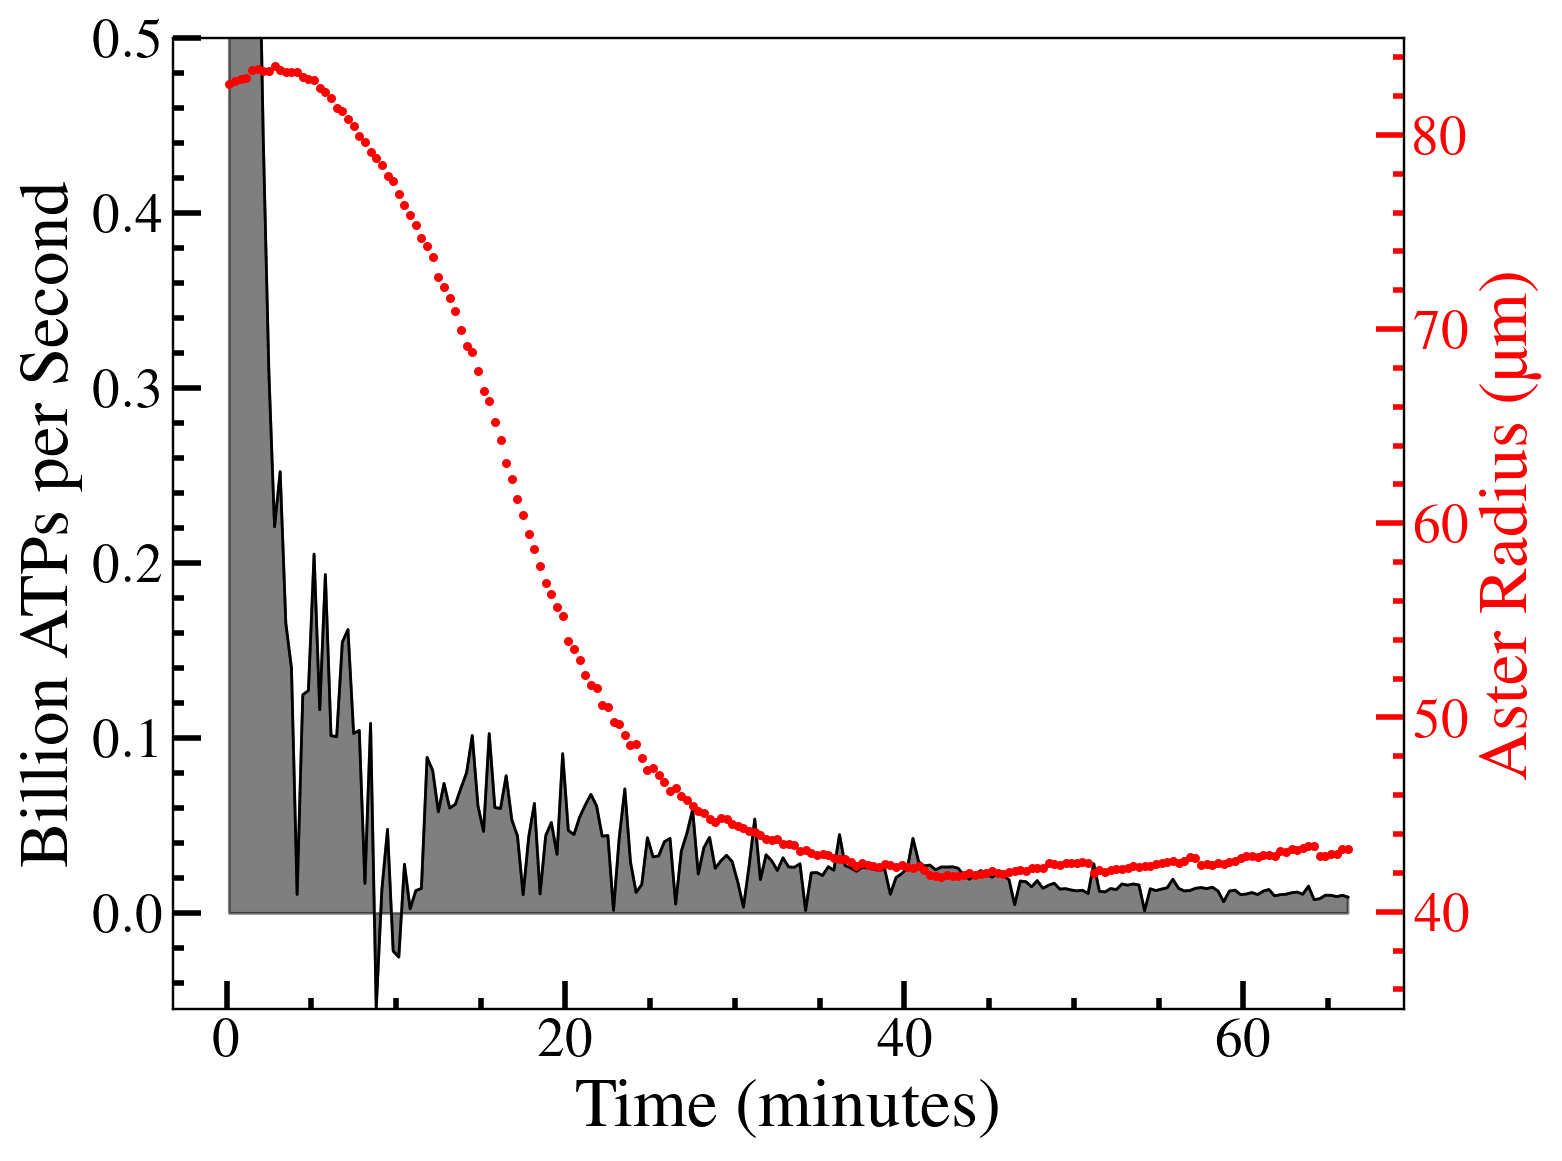

In [203]:
plot_times = (times_min[:-1]+times_min[1:])/2
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(plot_times,
        ratios_power_smoo/1e9,
         lw=1,
        color = 'k')
ax.fill_between(plot_times,
     ratios_power_smoo/1e9,
     alpha = 0.5,
     color = 'k')
ax.set_ylim(ratios_power_smoo.min()/1e9, 5e8/1e9)
#make second y-axis sharing same x-axis
ax2 = ax.twinx()
# ax2.plot(np.arange(len(radii*um_per_pixel)),#*5/3 + 2/3)[:2+int((i+4)/5)],
#          R2Pow(radii*um_per_pixel),#[:2+int((i+4)/5)],
#          lw=3,
#         linestyle='-',
#         label = 'Aster Radius',
#         color = 'r',)#'#76B4A6')
ax2.scatter(plot_times,#,*5/3 + 2/3)[:2+int((i+4)/5)],
         radii[1:]*um_per_pixel, #[:2+int((i+4)/5)],
         s=5,
         color = 'r',)
ax2.set_ylim(35, 85)

ax.tick_params('both', labelsize = 20)

ax.set_ylabel('Billion ATPs per Second', fontsize=25)
ax.set_xlabel('Time (minutes)', fontsize = 25)
ax.tick_params('both', which = 'both', width=2)
ax2.set_ylabel('Aster Radius (µm)', fontsize = 25, color = 'r')
ax2.tick_params('both', labelsize = 20, which = 'both', color = 'r', labelcolor='r', width=2)

plt.tight_layout()
#fig.savefig(save_path+'20240913totPow&Radius.pdf', dpi=400)

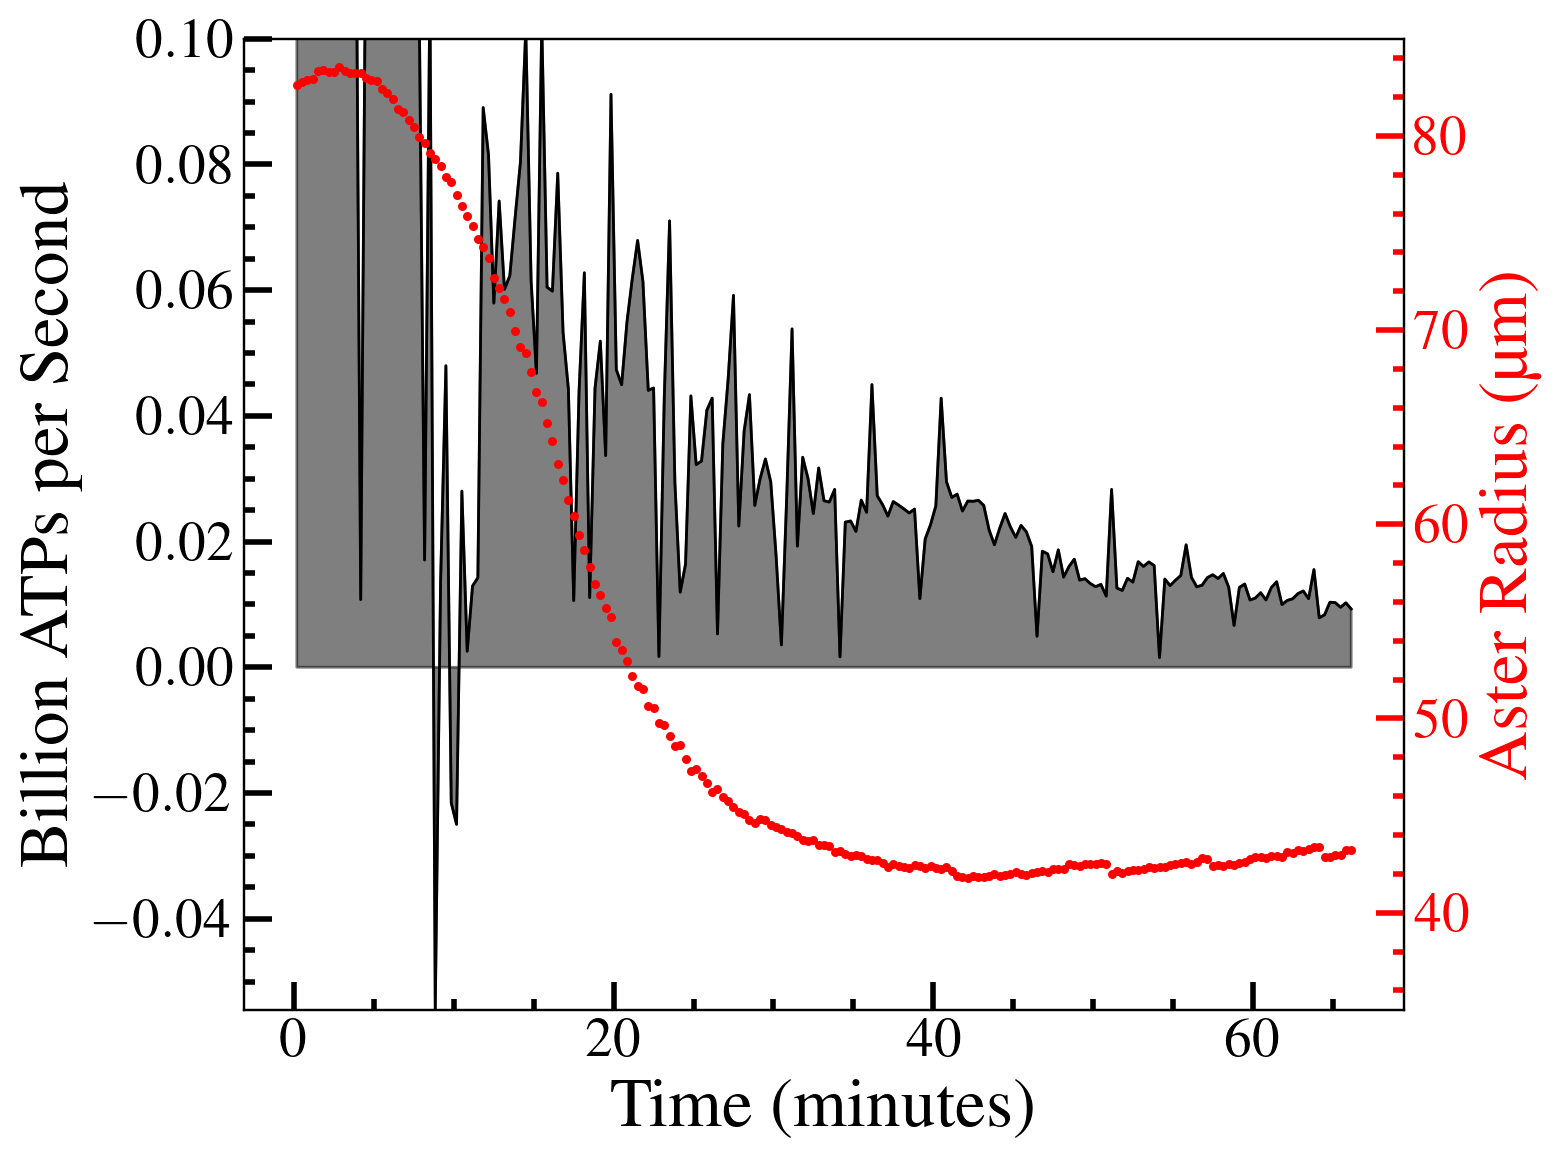

In [565]:
plot_times = (times_min[:-1]+times_min[1:])/2
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(plot_times,
        ratios_power_smoo/1e9,
         lw=1,
        color = 'k')
ax.fill_between(plot_times,
     ratios_power_smoo/1e9,
     alpha = 0.5,
     color = 'k')
ax.set_ylim(ratios_power_smoo.min()/1e9, 1e8/1e9)
#make second y-axis sharing same x-axis
ax2 = ax.twinx()
# ax2.plot(np.arange(len(radii*um_per_pixel)),#*5/3 + 2/3)[:2+int((i+4)/5)],
#          R2Pow(radii*um_per_pixel),#[:2+int((i+4)/5)],
#          lw=3,
#         linestyle='-',
#         label = 'Aster Radius',
#         color = 'r',)#'#76B4A6')
ax2.scatter(plot_times,#,*5/3 + 2/3)[:2+int((i+4)/5)],
         radii[1:]*um_per_pixel, #[:2+int((i+4)/5)],
         s=5,
         color = 'r',)
ax2.set_ylim(35, 85)

ax.tick_params('both', labelsize = 20)

ax.set_ylabel('Billion ATPs per Second', fontsize=25)
ax.set_xlabel('Time (minutes)', fontsize = 25)
ax.tick_params('both', which = 'both', width=2)
ax2.set_ylabel('Aster Radius (µm)', fontsize = 25, color = 'r')
ax2.tick_params('both', labelsize = 20, which = 'both', color = 'r', labelcolor='r', width=2)

plt.tight_layout()
#fig.savefig(save_path+'20240913totPow&Radius.pdf', dpi=400)

prev method

# Fit motor prfiel

In [66]:
def norm(x):
    """
    Normalizes an array
    parameters:
        x: array
    returns:
        normx: normalized array
    """
    normx = (x-x.min())/(x.max()-x.min())
    return normx

def normprof(mot_prof, R_c=15):
    """ 
    For a profile finds the peak and normalizes the relevant side
    parameters:
        mot_prof: array of concentration values for different radii 
        R_c: radius of the aster core - all radii lower than this will be mapped to this value as we only care from edge of core to tips or arms
    returns:
        norm_mot_prof[peak:]: the normalized profile to the right of the greatest value
        peak: location of the greatest value
    """
    mmax = np.max(mot_prof)
    peak = np.where(mot_prof==mmax)[0][0]
    if peak*um_per_pixel < R_c:
        peak = int(R_c/um_per_pixel)
        mmax = mot_prof[peak]
    mmin = np.min(mot_prof)
    norm_mot_prof = (mot_prof - mmin)/(mmax - mmin)
    return norm_mot_prof[peak:], peak

#-----------------------------------------------

# def ss_res(data, fit):
#     return np.sum((data-fit)**2)

#-----------------------------------------------

def normexp(x, l):
    """ 
    Function for an exponenetial
    parameters:
        x: array of x values 
        l: decay constant
    returns:
        exponential function
    """
    return np.exp(-(x/l))


def expfit(x, y, p0):
    """ 
    Fit to a exponential
    parameters:
        x: array of x values 
        y: array of y values
        p0: predicted parameter values
    returns:
        param: fit parameters
        curve: fit curve
        xfitvals: x values to match the fit curve
    """
    param,_ = curve_fit(normexp, x, y, p0)
    return param
    
    #------------------------------------------------

def normgauss(x, l):
    """ 
    Function for a gaussian
    parameters:
        x: array of x values
        l: decay constant
    returns:
        gaussian function
    """
    return np.exp(-(x/l)**2)


def gaussfit(x, y, p0):
    """ 
    Fit to a gaussian
    parameters:
        x: array of x values 
        y: array of y values
        p0: predicted parameter values
    returns:
        param: fit parameters
    """
    param,_ = curve_fit(normgauss, x, y, p0)
    return param


#--------------------------------------------------

def gaussexp(x,lgauss, lexp):
    """ 
    Function for a gauss*exp
    parameters:
        x: array of x values 
        lgauss: gaussian decay constant
        lexp: exponential decay constant
    returns:
        gaussian multiplied by an exponential function
    """
    return np.exp(-(x/lgauss)**2 - (x/lexp))


def gaussexpfit(x, y, p0):
    """ 
    Fit to a gauss+exp
    parameters:
        x: array of x values 
        y: array of y values
        p0: predicted parameter values
    returns:
        param: fit parameters
    """
    param,_ = curve_fit(gaussexp, x, y, p0)
    return param

#-----------------------------------------------

def exppow(x,l,n):
    """ 
    Function for a exponential times power law
    parameters:
        x: array of x values 
        l: exponential decay constant
        n: power-law exponent
    returns:
        exponential multiplied by an power-law function
    """
    return np.exp(-x/l)/(x**n)


def exppowfit(x, y, p0):
    """ 
    Function for a exponential times power law
    parameters:
        x: array of x values 
        y: array of y values
        p0: predicted parameter values
    returns:
        param: fit parameters
    """
    param,_ = curve_fit(exppow, x, y, p0, bounds = (np.zeros(2), np.array([np.inf, np.inf])))
    return param
#--------------------------------------------------

def fitter(method, mot_prof, mot_radii, p0):
    """ 
    Combo function for any of the fits
    parameters:
        method: gauss - will fit to a gaussian, 
                exp - will fit to an exponential
                ovr - will fit to a 1/r
        mot_prof: array of concentration values
        mot_radii: array of radii values corresponding to concentrations in mot_prof
        p0: predicted parameter values
    returns:
        norm_mot_prof[peak:]: the normalized profile to the right of the greatest value
        peak: location of the greatest value
        decay constant: fit parameter to the decay constant
        fit: fit curve
        dist_r: radius values to match the fit curve
    """
    norm_mot_prof, peak = normprof(mot_prof)
    mot_radii_zeroed = mot_radii[peak:]-mot_radii[peak]
    
    if method == 'gauss':
        decayconst = gaussfit(mot_radii_zeroed, norm_mot_prof, p0)
    elif method == 'exp':
        decayconst = expfit(mot_radii_zeroed, norm_mot_prof, p0)
    elif method == 'ovr':
        decayconst = ovrfit(mot_radii_zeroed, norm_mot_prof, p0)
    elif method == 'gaussexp':
        decayconst = gaussexpfit(mot_radii_zeroed[5:], norm_mot_prof[5:], p0)
    elif method == 'exppow':
        decayconst = exppowfit(mot_radii_zeroed[1:], norm_mot_prof[1:], p0)
    return decayconst

## Find peak location over time

In [67]:
# Create arrays to save the location and value of the peak at each time
peaksloc=[]
peaksval=[]

#find the peaks and save
for t, prof in enumerate(all_rMotavgs):
    _, peak = normprof(prof, R_c=0)
    peaksloc.append(peak)
    peaksval.append(prof[peak])
peaksloc=np.array(peaksloc)
peaksval=np.array(peaksval)


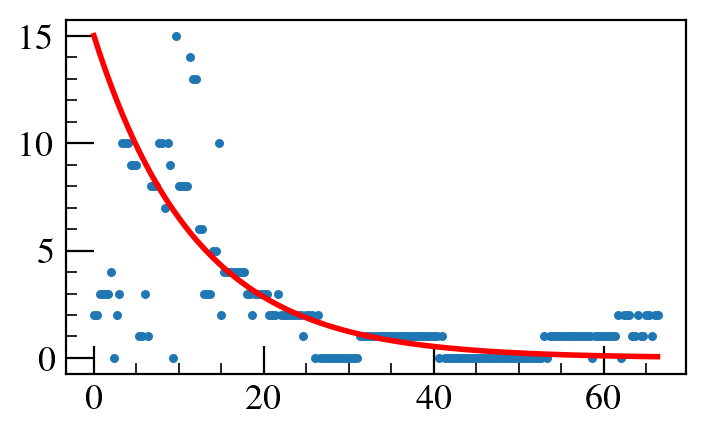

In [347]:
plt.scatter(times_min, peaksloc, s=5)
plt.plot(times_min, 15*np.exp(-times_min/12), c='r')

In [352]:
def guessed_mot_loc(time_array, weight, decayconst):
    return weight*np.exp(-time_array/decayconst)

[14.8251204]


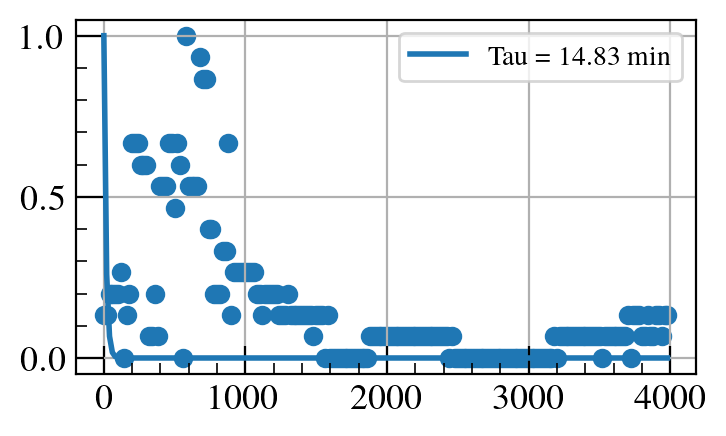

In [72]:
peaksloc_norm = norm(peaksloc)
peaksloc_max = peaksloc.max()
peaksloc_min = peaksloc.min()

temp_xdata = plot_times
temp_ydata = peaksloc_norm

#fit
peaksloc_expparam = expfit(temp_xdata, temp_ydata, [15])
peaksloc_expfit_norm = normexp(temp_xdata, peaksloc_expparam[0])

#peaksloc_expssres = ss_res(peaksloc_norm[8:46], peaksloc_expfit_norm)#*(peaksloc.max()-peaksloc.min())*um_per_pixel
print(peaksloc_expparam)

#Plot
plt.scatter(temp_xdata, temp_ydata)
plt.plot(temp_xdata, peaksloc_expfit_norm, label='Tau = ' + str(round(peaksloc_expparam[0],2)) +' min')
#plt.yscale('log')
plt.grid(True)
plt.legend()

## find steepest slope

In [432]:
def slope(yarr, xarr):
    return (yarr[1:]-yarr[:-1]) / (xarr[1:]-xarr[:-1])

def steepest(yarr, xarr):
    #a little wonky since not a true derivative
    slopes = slope(yarr, xarr)
    maxslope = np.absolute(slopes).argmax()
    pos = (xarr[maxslope+1]+xarr[maxslope])/2
    return pos

In [434]:
steep_rad = np.zeros(len(times_min))
for i, time in enumerate(times_min):
    steep_rad[i]=steepest(float_avg(all_rMotavgs[i,:],4), all_rbins[0,:]*um_per_pixel)

In [454]:
def guessed_mot_loc(time_array, weight, rinf, decayconst):
    return weight*np.exp(-time_array/decayconst)+rinf

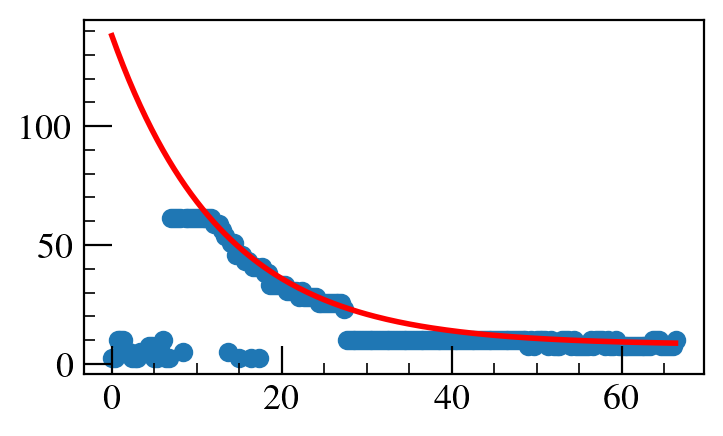

In [453]:
plt.scatter(times_min,steep_rad)
plt.plot(times_min, 130*np.exp(-times_min/13)+8, c='r')

149

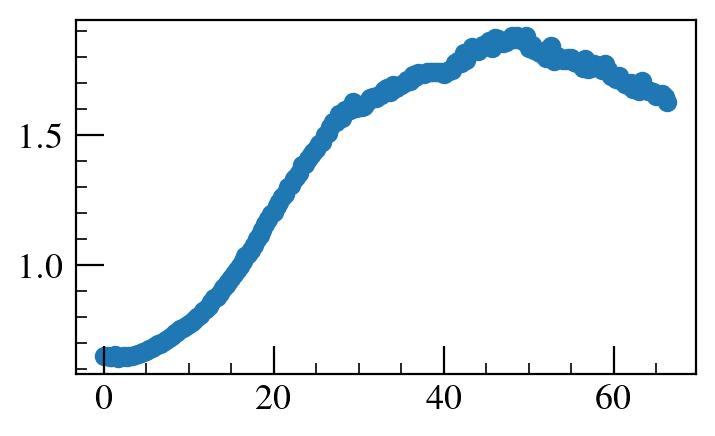

In [174]:
plt.scatter(times_min, peaksval)
peaksval.argmax()

Text(0, 0.5, 'Motor concentration (µM)')

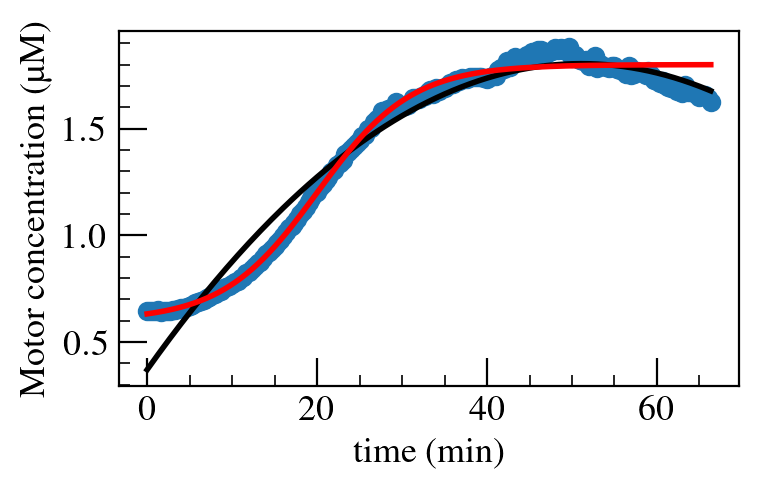

In [340]:
quadparam = np.polyfit(times_min-times_min[149], norm(peaksval), 2)

plt.scatter(times_min, peaksval)
plt.plot(times_min, (peaksval.max()-peaksval.min())*(quadparam[0]*(times_min-times_min[149])**2 + quadparam[1]*(times_min-times_min[149])                                                    + quadparam[2])+peaksval.min(), color='k')
plt.plot(times_min, (1.2/(1+np.exp(-0.18*(times_min-20)))+0.6), c='r')
plt.xlabel('time (min)')
plt.ylabel('Motor concentration (µM)')

In [354]:
def guessed_mot_height(time_array, mmax, mmin, weight, t0):
    return (mmax-mmin) / (1 + np.exp(-1 * weight * (time_array - t0))) + mmin

In [333]:
def guessed_motprof(time_array, mot_height_arr, mot_loc_arr):
    return 

6.0

In [511]:
test = np.repeat([55, 55, 60, 55, 45, 40, 30,30, 25, 25, 25, 25, 20, 20, 20, 20, 20, 20, 20, 20 ],10)

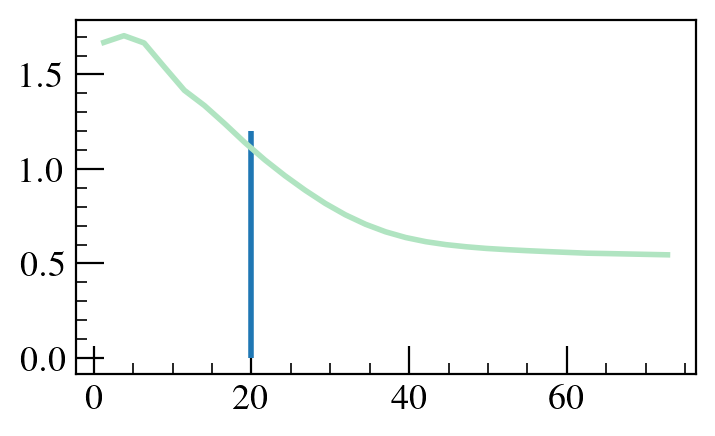

In [509]:
timei=190
plt.plot(all_rbins[0,:]*um_per_pixel,
                 float_avg(all_rMotavgs[timei,:],4),
                 lw=2,
                 color = colormap(normalize(time)),
                 label=str(round(time, 2)))
plt.vlines(20, 0, 1.2 )    

## inf point

In [540]:
float_avg(all_rMotavgs[:,-1],4).min(), float_avg(all_rMotavgs[:,-1],4).max()

(0.5366146922111511, 0.6436295145087771)

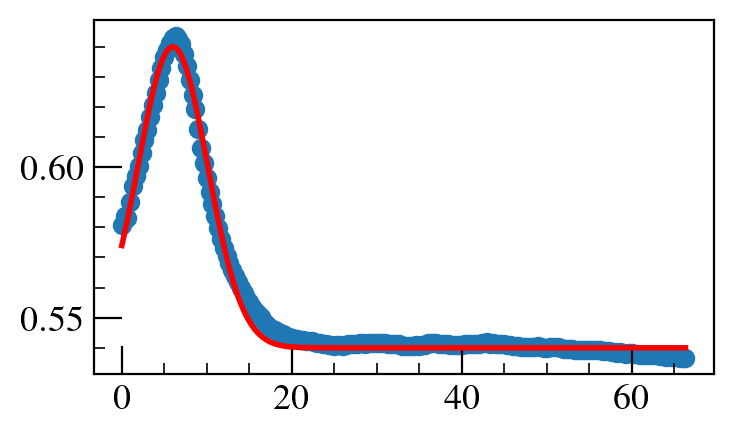

In [550]:
plt.scatter(times_min, float_avg(all_rMotavgs[:,-1],4))
plt.plot(times_min, (0.64-0.54)*np.exp(-0.03*(times_min-6)**2)+0.54, c='r')

In [551]:
def guessed_minpt(time_array, minmax, minmin, width, pos):
    return (minmax-minmin)*np.exp(-1*width*(times_min-pos)**2)+minmin

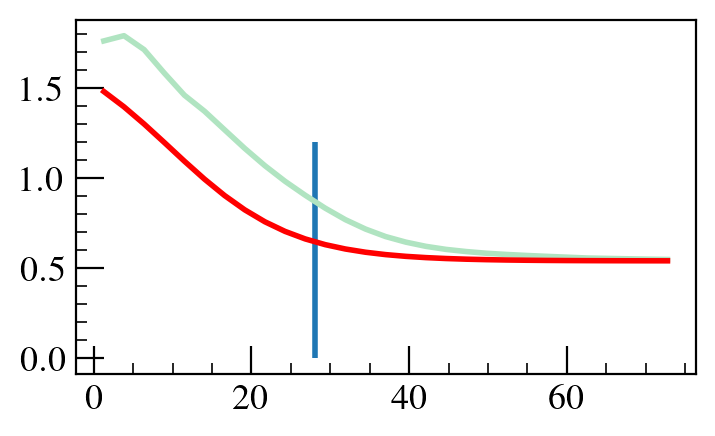

In [564]:
timei=170
plt.plot(all_rbins[0,:]*um_per_pixel,
                 float_avg(all_rMotavgs[timei,:],4),
                 lw=2,
                 color = colormap(normalize(time)),
                 label=str(round(time, 2)))
mot_min_arr = guessed_minpt(times_min, 0.64, 0.54, 0.03, 6)
mot_height_arr = guessed_mot_height(times_min, 1.8, mot_min_arr, 0.18, 20)
mot_loc_arr = guessed_mot_loc(times_min, 130, 8, 13)#uessed_mot_loc(times_min, 15, 0, 12)#
plt.plot(all_rbins[timei,:]*um_per_pixel, (mot_height_arr[timei]-mot_min_arr[timei])/(1+np.exp(-0.13*(-all_rbins[0,:]*um_per_pixel+mot_loc_arr[timei]))) +mot_min_arr[timei], c='r')
plt.vlines(28, 0, 1.2 )                                                                                                               

[ 1.  3.  5.  7.  9. 11. 13. 15. 17.]
8


8.5

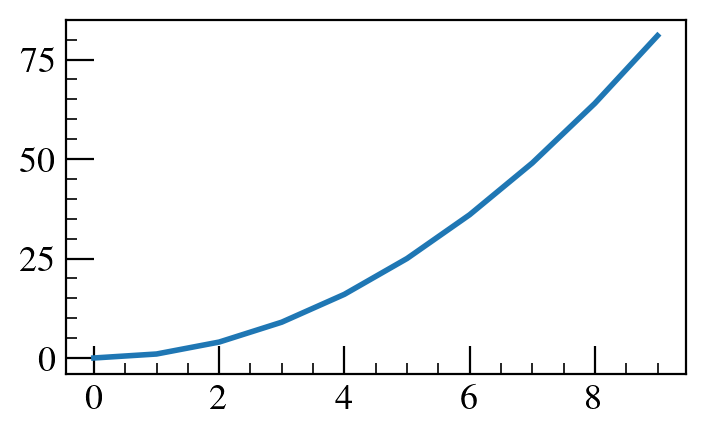

In [426]:
test_arr = np.arange(10)
test_prof = test_arr**2
plt.plot(test_arr, test_prof)
steepest(test_prof, test_arr)

In [417]:
np.absolute(first_deriv(test_prof, 1)).argmax()

8

In [413]:
test_arr = np.arange(10)
test_prof = np.exp(test_arr)
test_arr, np.exp(test_arr+0.5), first_deriv(test_prof, 1)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1.64872127e+00, 4.48168907e+00, 1.21824940e+01, 3.31154520e+01,
        9.00171313e+01, 2.44691932e+02, 6.65141633e+02, 1.80804241e+03,
        4.91476884e+03, 1.33597268e+04]),
 array([1.71828183e+00, 4.67077427e+00, 1.26964808e+01, 3.45126131e+01,
        9.38150091e+01, 2.55015634e+02, 6.93204365e+02, 1.88432483e+03,
        5.12212594e+03]))

In [410]:
(test_arr+0.5)*2

array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19.])

note to Ana:
i guessed params for height and loc whcih went ok. need to find r0 though for total overal sigmoid (since that is not the max location). maybe take derivative and find steepest. Then seems like the weight of the sigmoid can be the same regardless of time. Finally the minimum value changes a little. potentially look for that and update over time.

Biggest thing -  find max 1st deriv value for r0 and i think that should be good enough to simulate

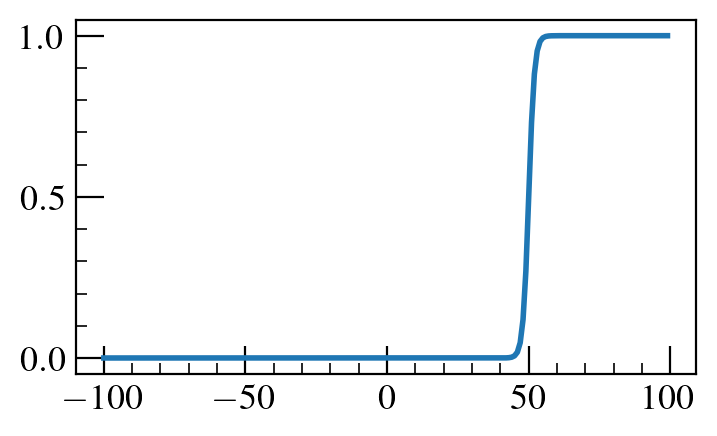

In [190]:
plt.plot(np.arange(-100, 100), 1/(1+np.exp(-np.arange(-100, 100)+50)))



## old comsol plot

In [567]:
#params
lamg1 = 0.22*60**(-1) #um/s
lamg2 = 3.81 #um
m0 = 5 #uM
minf = 1 #uM
m_a = -0.038*60**(-2) #uM/s^2
m_b = -0.0004 *60**(-1) #[uM/s]
m_c = 4.4 #[uM]
R_a = 58 #[um]
R_c = 15 #[um]
T_f = 980 #[s]
T_i = 378 #[s]
tau = 2.79*60 #[s]

In [568]:
comsol_file_path = '../../data/COMSOL/20231129_ATP_Depletion_3D_eqn-input-gaussian/'
comsol_file_name = 'xzproj_6_timedepmot'
comsol_file_type = '.txt'
comment = '%'
comsol_ATP_prof_df = pd.read_csv(comsol_file_path + comsol_file_name + comsol_file_type, comment=comment, names=["position", "ATP (µM)"])
comsol_motin_prof_df = pd.read_csv(comsol_file_path + 'motincore_xzproj_6_timedepmot' + comsol_file_type, comment=comment, names=["position", "Mot (µM)"])
comsol_motout_prof_df = pd.read_csv(comsol_file_path + 'motoutcore_xzproj_6_timedepmot' + comsol_file_type, comment=comment, names=["position", "Mot (µM)"])



t_start = T_i #initial time
t_end = 3600 # final time
spacing = 100 # seconds between each measurement
interval = 1 #plotting interval

numb_times = int((t_end-t_start)/spacing)+1

comsol_times = np.linspace(t_start, t_start+spacing*(numb_times-1), numb_times) #given in s
tot_points = len(comsol_ATP_prof_df['position'])
numb_points = int(tot_points/numb_times)

comsol_time_ls = []
for t in comsol_times:
    for i in range(numb_points):
        comsol_time_ls.append(t)
        
comsol_ATP_prof_df['time (min)']= comsol_time_ls
comsol_motin_prof_df['time (min)']= comsol_time_ls
comsol_motout_prof_df['time (min)']= comsol_time_ls

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

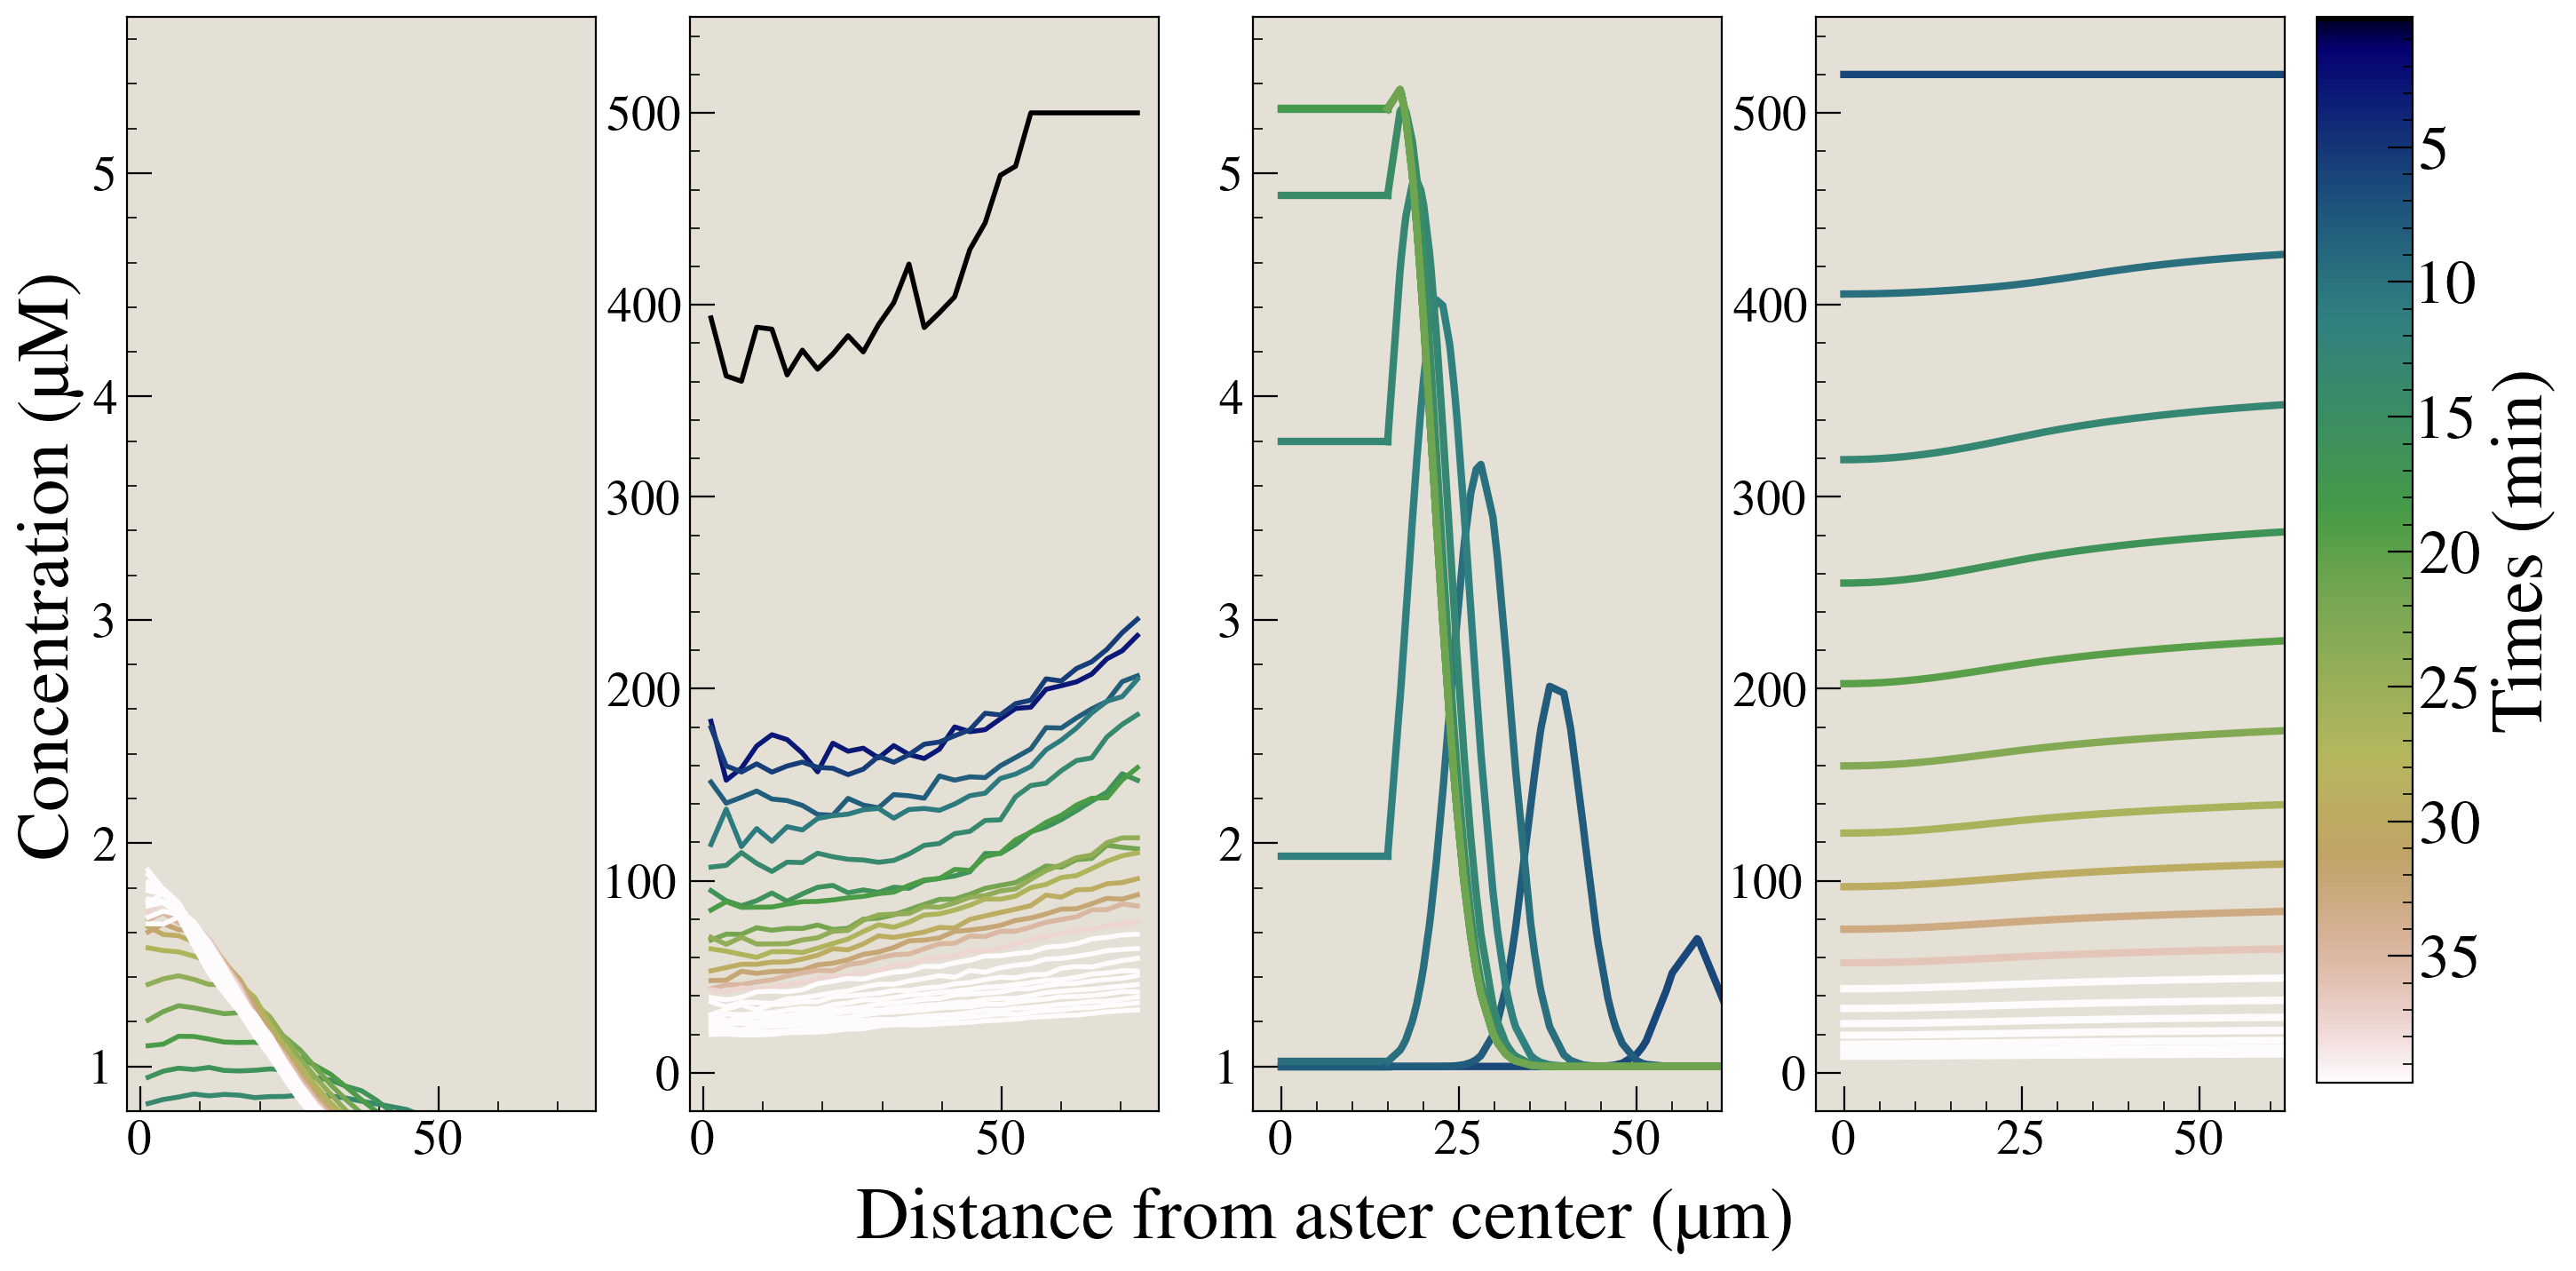

In [572]:
mod_num = 8

fig, ax = plt.subplots(1, 4, figsize=(18, 8))

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=plot_times.min(), vmax=0.6*plot_times.max())
colormap = cm.gist_earth
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(plot_times)

for i, time in enumerate(plot_times):
#for time in range(200):
    if i%mod_num==0:
        ax[1].plot(all_rbins[i,:]*um_per_pixel,
                 all_rATPavgs[i,:],
                 lw=2,
                 color = colormap(normalize(time)),
                 label=str(round(time, 2)))

        ax[0].plot(all_rbins[i,:]*um_per_pixel,
                 all_rMotavgs[i,:],
                 lw=2,
                 color = colormap(normalize(time)),
                 label=str(round(time, 2)))

#for i, frame in enumerate(plot_frames):
#     if i%mod_num==0:
#         ax[0].plot(output_Cherry[i]['r_unif_ls_um'],
#                  output_Cherry[i]['avg_ls_cu_smoo'],
#                  lw=3,
#                  color = colormap(normalize(plot_times[i])),
#                  label=str(round(plot_times[i], 2)))

#         ax[1].plot(output_ratios[i]['r_unif_ls_um'],
#                  output_ratios[i]['avg_ls_cu_smoo'],
#                  lw=3,
#                  color = colormap(normalize(plot_times[i])),
#                  label=str(round(plot_times[i], 2)))
        
# # m0 = 5 #uM
# # minf = 1 #uM
# # Ra = 40 # um
# # Rc = 15 #um
# # Tf = 10 #min
# # lamdecay = 10 #um
# # pos_data = np.arange(50)
# # dr = 1

# for t, time in enumerate(tqdm(comsol_times[:15])):
#     conc_data = motfunc(pos_data, dr, time, Tf, m0, minf, Ra, Rc, lamdecay)
#     #ax.plot(pos_data, conc_data, label= str(round(t,1)), linewidth = 4)
#     ax[2].plot(pos_data,
#              conc_data,
#              lw=3,
#              color = colormap(normalize(time)),
#              label=str(round(time, 1)))

mod_num=1   

R_c_idx = np.where(comsol_motin_prof_df.loc[comsol_motin_prof_df['time (min)'] == T_i, 'position']*1e6 <= R_c)[-1][-1]

for t, time in enumerate(tqdm(comsol_times[:8])):
    if t%mod_num==0:
        pos_data = comsol_motin_prof_df.loc[comsol_motin_prof_df['time (min)'] == time, 'position'][:R_c_idx+1].values[:]*1000000
        conc_data = comsol_motin_prof_df[comsol_motin_prof_df['time (min)'] == time]['Mot (µM)'][:R_c_idx+1].values[:]
        #ax.plot(pos_data, conc_data, label= str(round(t,1)), linewidth = 4)
        ax[2].plot(pos_data,
                 conc_data*1000,
                 lw=3,
                 color = colormap(normalize(time/60)),
                 label=str(round(time/60, 1)))
        ax[2].set_xlim(-4, 62)
        
for t, time in enumerate(tqdm(comsol_times[:10])):
    if t%mod_num==0:
        pos_data = comsol_motout_prof_df.loc[comsol_motout_prof_df['time (min)'] == time, 'position'][R_c_idx:].values[:]*1000000
        conc_data = comsol_motout_prof_df[comsol_motout_prof_df['time (min)'] == time]['Mot (µM)'][R_c_idx:].values[:]
        #ax.plot(pos_data, conc_data, label= str(round(t,1)), linewidth = 4)
        ax[2].plot(pos_data,
                 conc_data*1000,
                 lw=3,
                 color = colormap(normalize(time/60)),
                 label=str(round(time/60, 1)))
        ax[2].set_xlim(-4, 62)

mod_num=2  

for t, time in enumerate(tqdm(comsol_times[:40])):
    if t%mod_num==0:
        pos_data = comsol_ATP_prof_df.loc[comsol_ATP_prof_df['time (min)'] == time, 'position'].values[:]*1000000
        conc_data = comsol_ATP_prof_df[comsol_ATP_prof_df['time (min)'] == time]['ATP (µM)'].values[:]
        #ax.plot(pos_data, conc_data, label= str(round(t,1)), linewidth = 4)
        ax[3].plot(pos_data,
                 conc_data*1000,
                 lw=3,
                 color = colormap(normalize(time/60)),
                 label=str(round(time/60, 1)))
        ax[3].set_xlim(-4, 62)


#ax[0].set_box_aspect(1.5)
#ax[1].set_box_aspect(1.5)

fig.supxlabel('Distance from aster center (µm)', fontsize=30)
ax[0].set_ylabel('Concentration (µM)', fontsize=30)
# ax[0].set_ylabel('Motor Concentration (µM)')
# ax[1].set_ylabel('ATP Concentration (µM)')
# ax[0].set_xlabel('Distance from aster center (µm)')
# ax[1].set_xlabel('Distance from aster center (µm)')

ax[0].set_facecolor(color_background)
ax[1].set_facecolor(color_background)
ax[2].set_facecolor(color_background)
ax[3].set_facecolor(color_background)

ax[0].tick_params('both', labelsize=20)
ax[1].tick_params('both', labelsize=20)
ax[2].tick_params('both', labelsize=20)
ax[3].tick_params('both', labelsize=20)

ax[1].set_ylim(-20, 550)
ax[3].set_ylim(-20, 550)

ax[0].set_ylim(0.8, 5.7)
ax[2].set_ylim(0.8, 5.7)

fig.subplots_adjust(right=0.8)
color_bar_ax = fig.add_axes([0.81, 0.13, 0.03, 0.75])
cbar = fig.colorbar(scalarmappable, cax=color_bar_ax)
cbar.ax.tick_params(labelsize=25)
cbar.set_label(label="Times (min)", size=30, weight='bold')
cbar.ax.invert_yaxis()

# scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
# scalarmappable.set_array(plot_times)
# cbar = plt.colorbar(scalarmappable, label = "Times (min)")

#fig.savefig('../../analyzed_data/aster/2022-06-28_NCD_ATeam_UMT/2022-06-28_NCD_ATeam_UMT_R4_1/Motor_ATP_Traces-AND-COMSOL(20231129_gaussian-xz-projection_D6)', transparent=True, dpi=400)

# scratch work

In [189]:
power_prof(plot_times, all_rATPavgs, toroid_vol_m3, deltat)

array([ 3.26336652e+09,  1.59972259e+09,  1.38648678e+09,  9.99460427e+08,
        7.89870067e+07,  6.44754032e+08,  2.44808698e+08,  1.34063262e+09,
       -9.26057016e+08,  1.96702522e+08,  2.51005048e+07,  1.78107812e+08,
        2.03660670e+08,  3.62180552e+08, -1.34066479e+08,  1.34140701e+07,
        1.77913360e+08,  9.97806786e+07,  2.19384651e+08,  7.26168606e+08,
       -6.21877475e+08,  8.98508575e+08, -4.66294921e+08, -1.38932172e+08,
        4.98864401e+08,  2.42937270e+08, -4.34224189e+08,  2.35094153e+08,
       -6.04427294e+07,  2.00884302e+08, -5.68366737e+08,  1.46645816e+08,
        1.70364865e+08, -1.27015497e+08,  2.12165551e+08,  4.29337473e+07,
        5.81249892e+06,  3.30091790e+07,  2.12656848e+08,  1.04911005e+08,
        7.89223258e+07, -4.19217797e+07,  1.92151426e+07,  8.57145286e+07,
        6.22750285e+07,  8.93394257e+07,  1.12843601e+08,  4.02409136e+08,
       -2.55273602e+08, -5.36560038e+07,  4.61108458e+08, -3.60513204e+08,
        8.01114559e+07,  

In [158]:
all_rATPavgs.shape

(200, 29)

In [165]:
power_prof(plot_times, all_rATPavgs, toroid_vol_m3, deltat)

199

In [ ]:
all_rbins[i,:],
                 all_rATPavgs[i,:]

In [135]:
all_rbins[0]

array([  0.        ,   8.65517241,  17.31034483,  25.96551724,
        34.62068966,  43.27586207,  51.93103448,  60.5862069 ,
        69.24137931,  77.89655172,  86.55172414,  95.20689655,
       103.86206897, 112.51724138, 121.17241379, 129.82758621,
       138.48275862, 147.13793103, 155.79310345, 164.44827586,
       173.10344828, 181.75862069, 190.4137931 , 199.06896552,
       207.72413793, 216.37931034, 225.03448276, 233.68965517,
       242.34482759])

In [213]:
plt.scatter(mango_skin_coords[:,0], mango_skin_coords[:, 1], s=0.1, c='r')
plt.scatter(min_dist_coord[0][1], min_dist_coord[0][0], c='k')

plt.imshow(mot_conc_ims[min_dist_time][0], vmin=0, vmax=500)
plt.colorbar()

NameError: name 'mango_skin_coords' is not defined

In [95]:
#def shortest_dist(centers, mask_coords):
mango_mask = coords_to_mask(mask_coords, np.shape(mot_conc_ims[0]))
not_mango_mask = np.array(np.where(mango_mask==0)).T
#reshapes stuff and broadcasts to do subtraction
dists = np.sum((not_mango_mask[:, np.newaxis, :] - centers[np.newaxis, :, :])**2, axis=2)
min_dist = np.min(np.min(dists, axis=1), axis=0)
min_coord_dist = np.argmin(np.min(dists, axis=1), axis=0)

In [99]:
np.min(dists, axis=1)

array([1246700.5       , 1245510.5       , 1244322.5       , ...,
       1657150.41261194, 1659684.82179162, 1662221.23097131])

In [75]:
dists.shape, not_mango_mask.shape

((2000469, 200), (2000469, 2))

In [111]:
not_mango_mask[min_coord_dist], mango_mask[953, 599], mango_mask_filled[953, 599]

(array([953, 599]), 0.0, False)

In [108]:
#put coordinates into binary image
mango_mask = coords_to_mask(mask_coords, np.shape(mot_conc_ims[0]))
#find the interior values (erode)
mango_flesh = binary_erosion(mango_mask_filled)
#find the border pixels
mango_skin = mango_mask - mango_flesh
#find border coordinates
skin_coords = np.argwhere(mango_skin == 1)

In [112]:
mango_mask_filled = binary_fill_holes(mango_mask)
np.unique(mango_mask_filled)

array([False,  True])

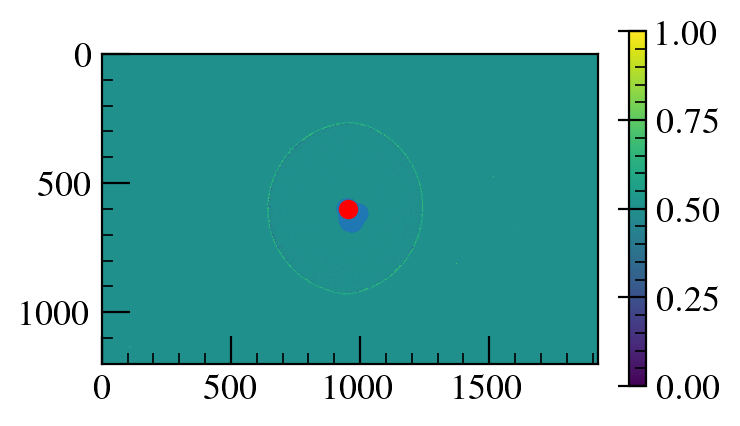

In [110]:
plt.imshow(mango_skin)
plt.scatter(centers.T[0], centers.T[1])
plt.scatter(not_mango_mask[min_coord_dist][0], not_mango_mask[min_coord_dist][1], color='r')

In [ ]:
## IN case for some reason manual for-looping is better
def allCentID(movie, mask_coords, area_thresh=0):
    results=[]
    for im in movie:
        results.append(center_identification(im, mask_coords, area_thresh))
    return results

In [ ]:
cent_and_radii[0][0]

# Find largest possible circle crop

In [ ]:
mango_mask = np.zeros_like(arrs_sub[0][0])
mango_mask[mask_coords] = 1

#find contour
mango_skin, _ = cv2.findContours(mango_mask.astype(np.uint8), 1, 2)[0]

#min dist
#START HERE ANA
dists = np.sqrt((mango_skin.T[0]-centx)**2 + (mango_skin.T[1]-centy)**2)

def largest_rad_inIllum(array, centers):
    #instantiate arrays to save radii and coordinates
    min_dists = np.zeros(len(array))
    loc_min_dists = np.zeros((len(array), 2))
    for i, im in enumerate(array):
        #define aster centers
        centx = centers[i][0]
        centy = centers[i][1]
        
        #Make binary image to isolate illumination
        otsu = skimage.filters.threshold_otsu(im)
        im_ot = im>otsu
        
        #Find contours of binary image
        contours, heirarchy = cv2.findContours(im_ot.astype(np.uint8), 1, 2)
        #iterate through contours (for most connected region)
        max_area = 0
        max_index = None
        for j, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                max_index = j
                
        #Find the coordinates of the illumination pattern contour
        cnt = contours[max_index]
        cnt = np.array(cnt)
        cnt = np.squeeze(cnt)

        #Find the minimum distance between the aster center and the contour
        dists = np.sqrt((cnt.T[0]-centx)**2 + (cnt.T[1]-centy)**2)
        min_dists[i] = dists.min()
        loc_min_dists[i] = (cnt.T[0][dists.argmin()],  cnt.T[1][dists.argmin()])
        
    return min_dists, loc_min_dists

In [95]:
testim = normed_mot[100]
cent, radius = center_identification(testim, mask_coords)

In [87]:
normed_mot = arrs_norm[2]
testim = normed_mot[0]

image_blur = gaussian(testim, sigma=50)
    
#threshold
thresh = threshold_otsu(image_blur[mask_coords]) #Otsu threshold method
binary = (image_blur>thresh).astype(np.uint8)

#create a contour
contours, hierarchy = cv2.findContours(binary, 1, 2)

In [88]:
thresh

171.37013934851797

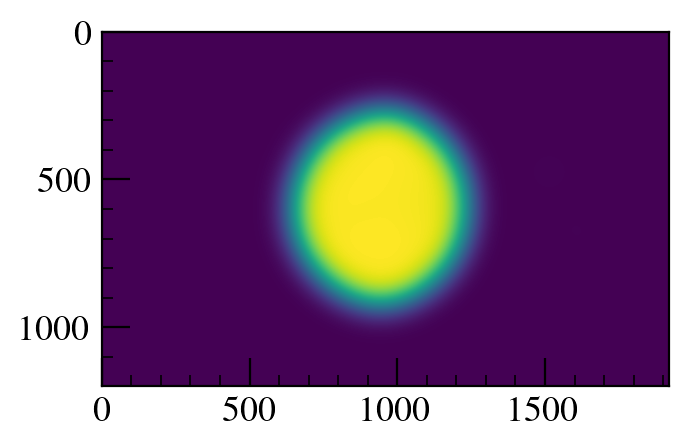

In [89]:
plt.imshow(image_blur)

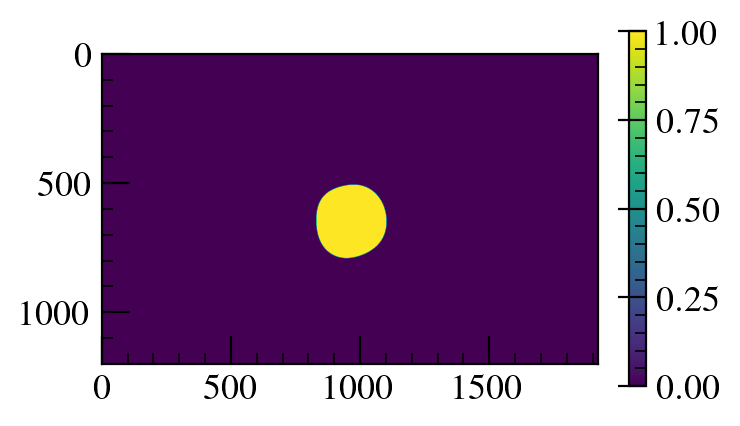

In [84]:
plt.imshow(binary, vmax=1)
plt.colorbar()

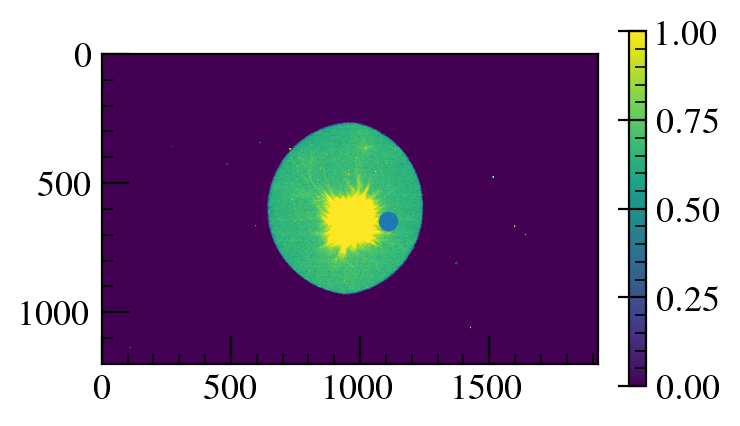

In [101]:
plt.imshow(testim, vmin=0, vmax=300)
plt.scatter([cent[0]+radius], cent[1])
plt.colorbar()

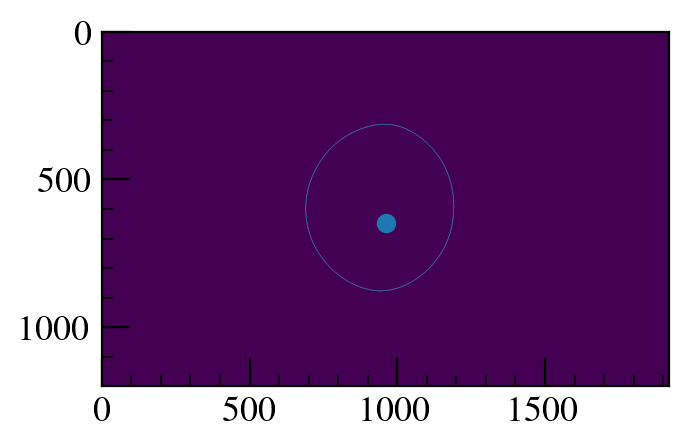

In [99]:
plt.imshow(cv2.drawContours(binary, contours, -1, color=1029))
plt.scatter(cent[0], cent[1])

### Crop
c_ymin, c_ymax, c_xmin, c_xmax = ymin_motcrop, ymax_motcrop, xmin_motcrop, xmax_motcrop
crop = np.s_[c_ymin:c_ymax, c_xmin:c_xmax]

#init empty lists for center vals, radius, frame #
centers = []
radii = []
frame_num = []
contours_plot = []

#for loop thru MT images
for i, im in enumerate(tqdm(mot_arraynorm)):
   
    #gaussian blur
    dst = gaussian(im[crop], sigma=50)
    
    #Create a binary mask for above a threshold
    thresh = threshold_otsu(dst) #Otsu threshold method
#     thresh = np.percentile(dst, 98.5) #Percentile threshold method
    binary = (dst>thresh).astype(np.uint8)
    
    #create a contour
    contours, hierarchy = cv2.findContours(binary, 1, 2)

    #iterate through contours (for most connected region)
    max_area = 0
    max_index = None

    #Find the contour that encomppasses the largest area, this will be 
    #the best center circle guess
    for j, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_index = j

    #Conditional to find the center - only look if the contour is bigger
    #than a threshold radius defined above
    if (max_area >= area_thresh and i > 10):
        cnt = contours[max_index]
        #Find a circle that best encloses the contour
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        #save the center, radii, and frame number
        centers.append([x + c_xmin, y + c_ymin])
        radii.append(radius)
        frame_num.append(i)
        
        #fromat the contour indices for plotting
        cnt = np.array(cnt)
        cnt = np.squeeze(cnt)
        cnt[:,0] += c_xmin
        cnt[:,1] += c_ymin
        contours_plot.append(cnt)
    
    #If the contour is not well defined for the image, abort
    else:
        print("**CENTER NOT FOUND** - Frame " + str(i))
        cnt = contours[max_index]
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        centers.append([x + c_xmin, y + c_ymin])
        radii.append(radius)
#         frame_num.append(i)
        
        cnt = np.array(cnt)
        cnt = np.squeeze(cnt)
        cnt[:,0] += c_xmin
        cnt[:,1] += c_ymin
        contours_plot.append(cnt)

#Convert lists to arrays
centers = np.array(centers)
radii = np.array(radii)
radii_um = radii*um_per_pixel
frame_num = np.array(frame_num)

In [25]:
# # # Load the array from the HDF5 file
# # with h5py.File(save_name, 'r') as h5file:
# #     loaded_array = h5file[save_name][:]
# plt.imshow(loaded_array[0])x

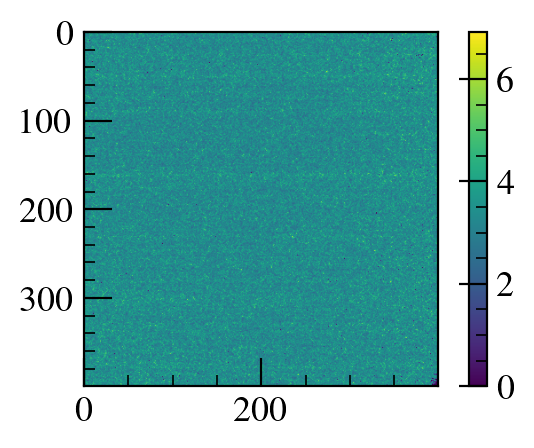

In [122]:
tempim = np.zeros_like(arrs_sub[0][0])
tempim[mask_coords]=ratios[0]
temp_crop=np.s_[400:800, 780:1180]
#plt.imshow((tempim>RinitATP)[temp_crop])
plt.imshow((tempim)[temp_crop])
plt.colorbar()

In [109]:
def profile_fn(im,
               r_min=2.5,
               dr=1.5,
               r_max=None,
               avg_method='median',
               n_positions=100,
               n_wedge=16):
    """
    Calculate the radial intensity profile of an image, 
    assuming that the (0,0) coordinate is at the center of the image.
    
    Parameters
    ----------
    im : numpy array
        The cropped image of the aster (grayscale).
      
    r_min : float
        Minimum radius beyond which the intensity profile is calculated [px].
    
    dr : float
        Radial binning size [px].
    
    avg_method : string
        The method used for doing a radial average of intensities.
        'median' - median averaging
        'mean' - mean averaging
        
    n_positions : integer
        Number of uniformly spaced radial positions where the average
        intensity is calculated.
        
    n_wedge : integer
        Number of angular bins
        
                      
    Returns
    -------
    profile_output : dictionary
        Dictionary of different outputs listed below
    
      r_unif_ls : numpy array
          Uniformly spaced radii where the average intensity is evaluated.
          
      avg_ls : numpy array
          Average intensities evaluated at 'n_positions' different uniformly
          spaced radii.
          
      std_ls : numpy array
          Standard deviations of intensity values in differents wedges
          
      avg_bin_mat : numpy array
          Two dimensional array to store the average fluorescence values
          at each of 'n_positions' radii and for each angular bin
          
      angles : numpy array
          List of average angles at different bins. E.g., if the upper and
          lower θ-limits are (30° and 60°), then the corresponding element
          in angles will be 45°.
          
      r_ls : numpy array
          Radial distances of all image pixels from the image center.
          
      im_ls : numpy array
          All pixel intensities in the same order as 'r_ls'.
    """

    # Ensure that the image is a numpy array
    if not isinstance(im, np.ndarray):
        im = np.array(im)

    # Dimensions of the image
    H, W = im.shape

    # Array of the radial distance of each point from the center
    x_mat, y_mat = np.meshgrid(np.arange(W), np.arange(H))
    x_center = 0.5 * W - 0.5
    y_center = 0.5 * H - 0.5
    r_mat = np.sqrt((x_mat - x_center)**2 + (y_mat - y_center)**2)
    angle_mat = np.mod(np.arctan2(y_mat - y_center, x_mat - x_center),
                       2 * np.pi)

    # Convert 2d arrays into 1d arrays
    r_ls = r_mat.flatten()
    im_ls = im.flatten()
    angle_ls = angle_mat.flatten()

    # Uniformly spaced radii, starting with r_min and
    # ending with the smallest dimension of the image halved,
    # if r_max is not explicitly specified
#     if type(r_max) != np.ndarray:
#         r_max = 0.5 * np.min([H, W]) - 0.5

    r_unif_ls = np.linspace(r_min, r_max, n_positions)

    # List of bin angles
    angle_bins = np.radians(np.linspace(0, 360, n_wedge + 1))
    angles = 0.5 * (angle_bins[1:] + angle_bins[0:-1])

    # Matrix to store average profiles in each radial bin
    avg_bin_mat = [[] for _ in range(n_wedge)]

    for i, r in enumerate(r_unif_ls):
        dat = im_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]
        angle_disk = angle_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]

        for k in range(n_wedge):
            dat_bin = dat[(angle_disk > angle_bins[k])
                          & (angle_disk <= angle_bins[k + 1])]

            if avg_method == 'median':
                avg_dat_bin = np.median(dat_bin)
            elif avg_method == 'mean':
                avg_dat_bin = np.mean(dat_bin)
            avg_bin_mat[k].append(avg_dat_bin)

    avg_bin_mat = np.array(avg_bin_mat)
    if avg_method == 'median':
        avg_ls = np.nanmedian(avg_bin_mat, axis=0)
    elif avg_method == 'mean':
        avg_ls = np.nanmean(avg_bin_mat, axis=0)
    else:
        raise ValueError('Incorrect averaging method specified.')

    std_ls = np.std(avg_bin_mat, axis=0)

    # Keep only the points inside the disk
    im_ls = im_ls[r_ls <= r_max]
    r_ls = r_ls[r_ls <= r_max]

    profile_output = {
        "r_unif_ls": r_unif_ls,
        "r_unif_ls_um": r_unif_ls * um_per_pixel,
        "avg_ls": avg_ls,
        "std_ls": std_ls,
        "avg_bin_mat": avg_bin_mat,
        "angles": angles,
        "r_ls": r_ls,
        "im_ls": im_ls
    }

    return profile_output

In [123]:
#Length Calibration (microns to pixels)
um_per_pixel = 0.59/2 #microscope thought that the magnification was 5x when it was actually 10x meaning there are fewer um for the same amount of pixels


profDict=profile_fn(tempim, r_min=0, dr=1.5, r_max=200)

/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


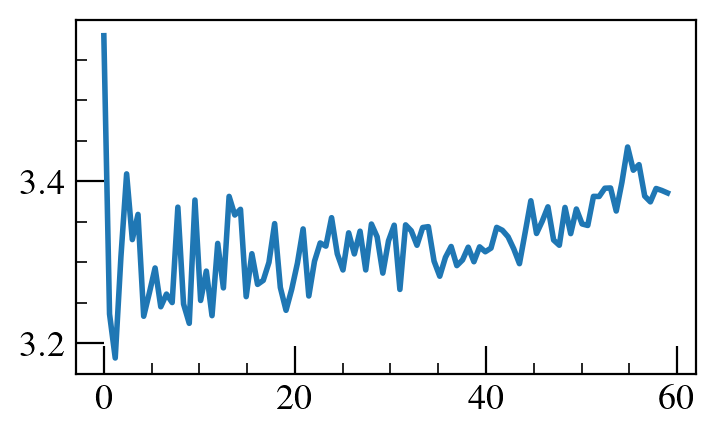

In [124]:
plt.plot(profDict['r_unif_ls_um'], profDict['avg_ls'])

True

In [ ]:
woot=(ratios[::2,:,:]+ratios[1::2,:,:])/2
woot.shape

(100, 1200, 1920)

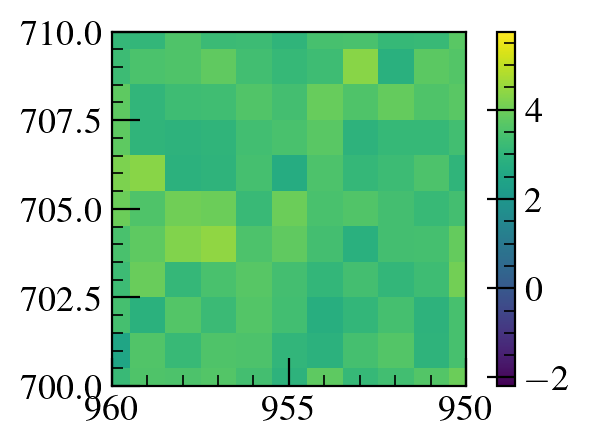

In [61]:
plt.imshow(woot[0,:,:])
plt.ylim([700,710])
plt.xlim([960, 950])
plt.colorbar()

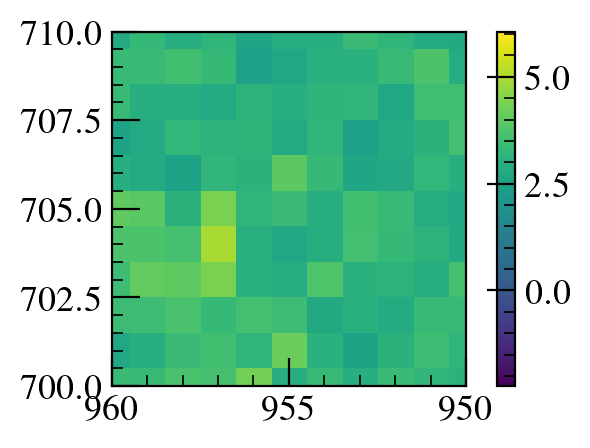

In [62]:
plt.imshow(woot[1,:,:])
plt.ylim([700,710])
plt.xlim([960, 950])
plt.colorbar()

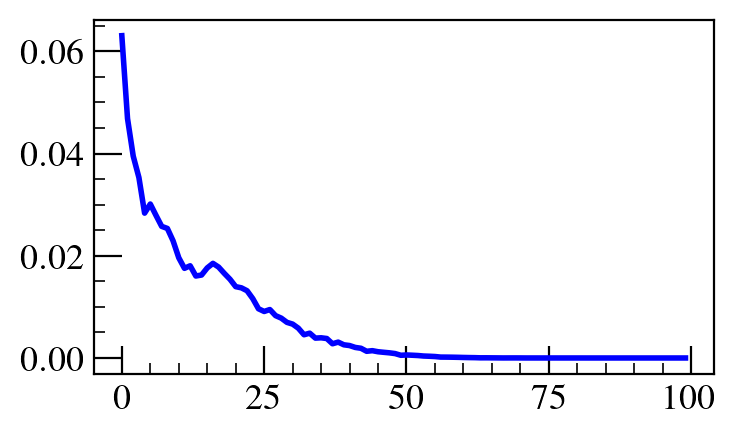

In [69]:
plt.plot([(woot[t,:,:]>=3.39).sum()/(woot.shape[1]*woot.shape[2]) for t in range(100)], 'b-')

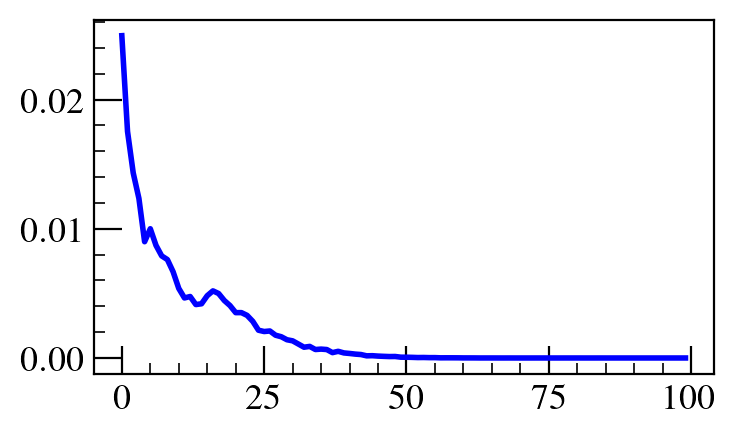

In [67]:
plt.plot([(woot[t,:,:]>=cal_params.loc['Rmax']['Value']).sum()/(woot.shape[1]*woot.shape[2]) for t in range(100)], 'b-')

In [33]:
cal_params

Value  Uncertainty
Param                        
Km     70.232953           10
Rmax    3.718097           10
Rmin    1.036695           10
nhill   1.000000            0

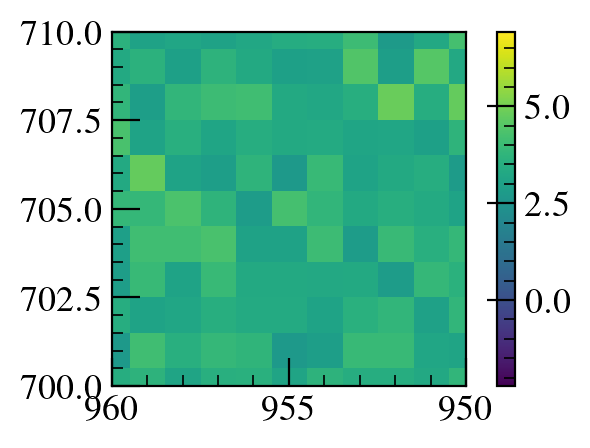

In [51]:
plt.imshow(ratios[0])#>cal_params.loc['Rmax']['Value'])
plt.ylim([700,710])
plt.xlim([960, 950])

plt.colorbar()

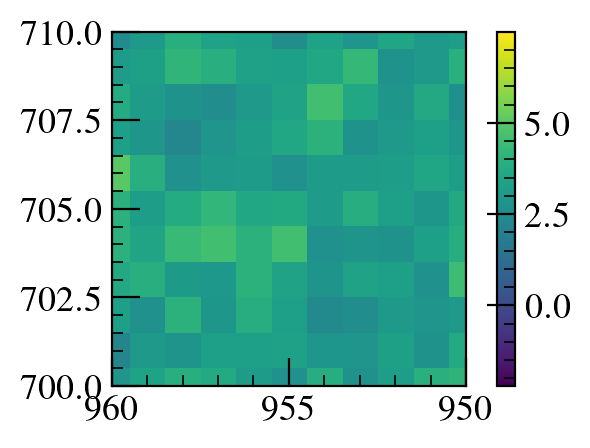

In [52]:
plt.imshow(ratios[1])#>cal_params.loc['Rmax']['Value'])
plt.ylim([700,710])
plt.xlim([960, 950])
plt.colorbar()

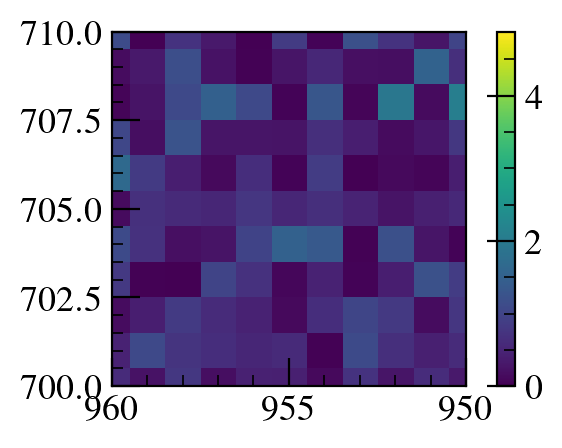

In [57]:
plt.imshow(abs(ratios[0]-ratios[1]))#>cal_params.loc['Rmax']['Value'])
plt.ylim([700,710])
plt.xlim([960, 950])

plt.colorbar()

In [53]:
cal_params.loc['Rmax']['Value']

3.718097246297439

In [47]:
abnormal[0].shape

(200, 1200, 1920)

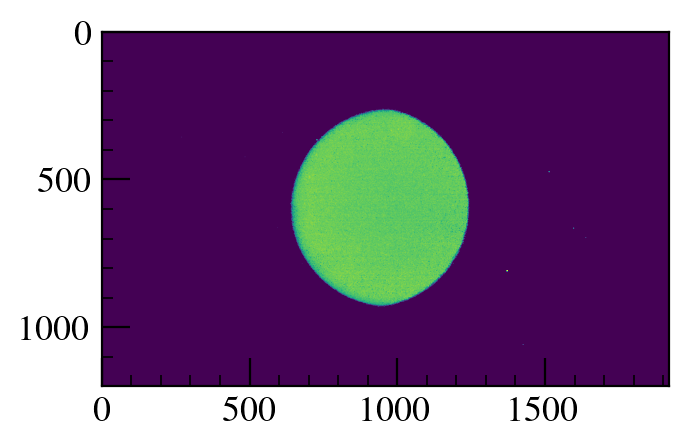

In [20]:
fig, ax = plt.subplots()
ax.imshow(abnormal[0][0,:,:],vmin=0, vmax=500)

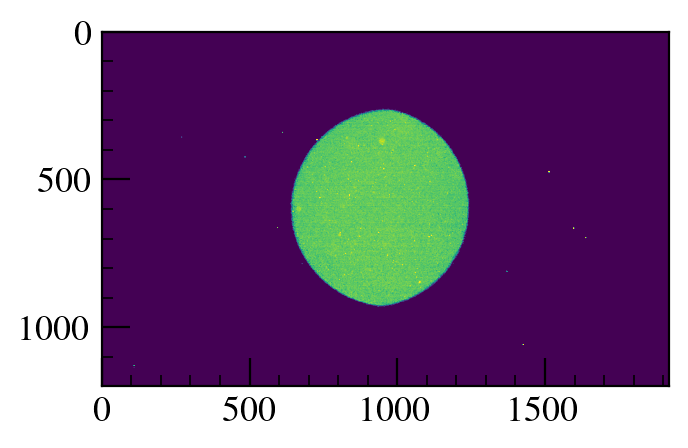

In [54]:
fig, ax = plt.subplots()
ax.imshow(abnormal[2][0,:,:],vmin=0, vmax=500)

In [26]:
np.mean(norm_mats[0][mask_coords]), np.mean(arrs_sub[0][0][mask_coords])

(380.85414669341594, 380.85414669341844)

In [27]:
np.mean(arrs_sub[0][0][mask_coords])/np.mean(arrs_sub[0][0][mask_coords]/norm_mats[0][mask_coords])

381.08343966822446

In [16]:
norm_mats = []
for arr in arrs_sub:
    norm_mat = np.zeros_like(dark_avg)
    norm_mat[mask_coords] = evaluateBivPoly_anyShape(arr[0, :, :][mask_coords], mask_coords)
    norm_mats.append(norm_mat)

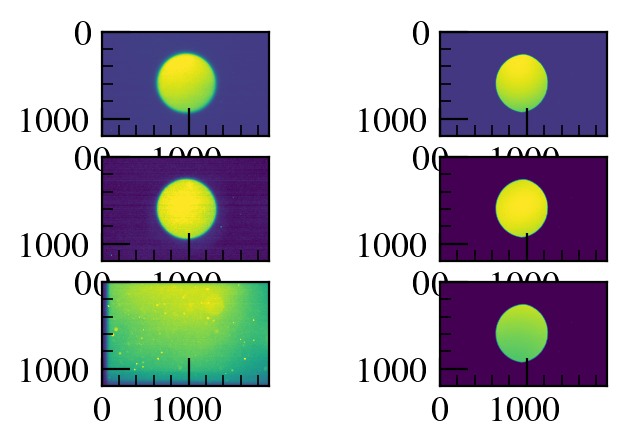

In [17]:
fig, ax = plt.subplots(3, 2)
ax[0][0].imshow(arrs_sub[0][0], vmin=norm_mats[0].min(), vmax=norm_mats[0].max())
ax[0][1].imshow(norm_mats[0])
ax[1][0].imshow(arrs_sub[1][0], vmin=norm_mats[1].min(), vmax=norm_mats[1].max())
ax[1][1].imshow(norm_mats[1])
ax[2][0].imshow(arrs_sub[2][0], vmin=norm_mats[2].min(), vmax=norm_mats[2].max())
ax[2][1].imshow(norm_mats[2])

In [113]:
testImg=arrs[0][0,:,:]
fit_bivariate_quadratic_anyShape(testImg[np.where(testBackMask)],
                                 np.where(testBackMask))

array([-3.47758592e-04, -4.53934814e-04,  1.07272348e-05,  2.26613362e-01,
        8.09367339e-01,  1.93676849e+03])

Find the illuminated region for the projector channels and apply the bivariate polynomial

next function is for circles with specified center and radius

In [ ]:
def BivPolyNormMatCirc(im, cent, radius, r_edge):
    # Make a binary image using the center and radius of the illumination patterns
    I, J = np.meshgrid(np.arange(im.shape[0]), np.arange(im.shape[1]), indexing='ij')
    testcirc = (I-illumavgcent[1])**2+(J-illumavgcent[0])**2
    coords = np.where(testcirc<=(radius-r_edge)**2)
    vals = im[coords]
    
    #Apply the bivariate polynomial fit for the ones region
    biv_filt = evaluateBivPoly_anyShape(vals, coords)
    alpha_filt = np.nanmean(biv_filt)/biv_filt

    #put the bivariate filter in the shape of the image
    im_biv = np.zeros(im.shape)
    im_biv[coords] += biv_filt
    #put the alpha filter in the shape of the image
    alpha = np.zeros(im.shape)
    alpha[coords] += alpha_filt

    return alpha

In [ ]:
bnd_alpha = BivPolyNormMatCirc(im_arraybnd_bs[0], illumavgcent_bnd, illumradius_bnd, 30)
bnd_arraynorm = im_arraybnd_bs_nonneg*bnd_alpha

unbnd_alpha = BivPolyNormMatCirc(im_arrayunbnd_bs_nonneg[0], illumavgcent_unbnd, illumradius_unbnd, 30)
unbnd_arraynorm = im_arrayunbnd_bs_nonneg*unbnd_alpha
